# Delta

> **Charlie** model trained on slightly different data

### Data

> `wrapped_10000_gaussian_spikes_five_percent_(A-D).bz2`
>
 - 10000 Entries with some spikes
 - tau randomly selected from -100 to 100 (uniform)
 - phi randomly selected from 0 to 2$\pi$
 
 
>  5% of the data has spikes (so out of 10000 entries, 500 have some spikes)
-  spikes are added to up to 1 percent of each entry
 - so for 1024 frequencies, up to 10 channels have a spike
- spikes are randomly chosen from gaussian with sigma = pi / 2 and added to the 1%

### Training
> 1500 Epochs on `wrapped_2500_gaussian_spikes_five_percent_A.bz2`

> 1500 Epochs on `wrapped_2500_gaussian_spikes_five_percent_B.bz2`

> 1500 Epochs on `wrapped_2500_gaussian_spikes_five_percent_C.bz2`

> 1500 Epochs on `wrapped_2500_gaussian_spikes_five_percent_D.bz2`

### Results

> **Delta** performs well.
>
- After 1500 Epochs
 - score : 1.4009857804455375
 - std   : 3.2882890273060177
>
>
- After 3000 Epochs
 - score :  0.8638336968531796
 - std.  :  2.4990975658085532
>
>
- After 4500 Epochs
 - score :  0.6753946518627426
 - std.  :  2.1788421463527445
>
>
- After 6000 Epochs
 - score :  0.7162757614918478
 - std.  :  2.3422929878872716
 


> This network will be used as a seed for **Echo**

### Log number
> 517631

In [1]:
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, sys, io

from sklearn.preprocessing import MinMaxScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import data
data_df = pd.read_csv('../../data/wrapped_10000_gaussian_spikes_five_percent_A.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

In [3]:
# setup layer & NN parameters
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [4]:
layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 450
layer_4_nodes = 290
layer_5_nodes = 205
layer_6_nodes = 105
layer_7_nodes = 50

learning_rate = 0.0015
training_epochs = 1500

In [5]:
# one random serial number per NN graph
# - add letters to end for repeated runs
# - only run this cell once!
log_random_serial_number = '{}'.format(np.random.randint(100000,999999))
print(log_random_serial_number)

517631


In [6]:
def log_dir(log_random_serial_number):
    master_log_path = '../../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc

In [7]:
log_direc = log_dir(log_random_serial_number)
print(log_direc)

../../logs/517631


#### 7 layers, 6 dropouts...

In [8]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
# for dropout keep_prob = 0.5, for testing keep_prob = 1
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.leaky_relu(tf.matmul(X, weights) + biases)
    
with tf.variable_scope('dropout_12'):
    drop_out_12 = tf.nn.dropout(layer_1_output, keep_prob)     
    
    
# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(drop_out_12, weights) + biases)
    
with tf.variable_scope('dropout_23'):
    drop_out_23 = tf.nn.dropout(layer_2_output, keep_prob)     
    


# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(drop_out_23, weights) + biases)

with tf.variable_scope('dropout_34'):
    drop_out_34 = tf.nn.dropout(layer_3_output, keep_prob)  
    
# Layer 4
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4",
                             shape = [layer_4_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights4",
                              shape  = [layer_3_nodes, layer_4_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_4_output = tf.nn.relu(tf.matmul(drop_out_34, weights) + biases)

with tf.variable_scope('dropout_45'):
    drop_out_45 = tf.nn.dropout(layer_4_output, keep_prob)  

# Layer 5
with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5",
                             shape = [layer_5_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights5",
                              shape  = [layer_4_nodes, layer_5_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_5_output = tf.nn.relu(tf.matmul(drop_out_45, weights) + biases)

with tf.variable_scope('dropout_56'):
    drop_out_56 = tf.nn.dropout(layer_5_output, keep_prob)  
    
# Layer 6
with tf.variable_scope('layer_6'):

    biases = tf.get_variable(name = "biases6",
                             shape = [layer_6_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights6",
                              shape  = [layer_5_nodes, layer_6_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_6_output = tf.nn.relu(tf.matmul(drop_out_56, weights) + biases)
    
with tf.variable_scope('dropout_67'):
    drop_out_67 = tf.nn.dropout(layer_6_output, keep_prob) 

# Layer 7
with tf.variable_scope('layer_7'):

    biases = tf.get_variable(name = "biases7",
                             shape = [layer_7_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights7",
                              shape  = [layer_6_nodes, layer_7_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_7_output = tf.nn.relu(tf.matmul(drop_out_67, weights) + biases)


# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_7_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_7_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.histogram('predictions', prediction)
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [9]:
saver = tf.train.Saver()

In [10]:
log_direc

'../../logs/517631'

INFO:tensorflow:Restoring parameters from ../../logs/693339/trained_model.ckpt-5999
 epoch:    0 testing_cost: 0.0034166775

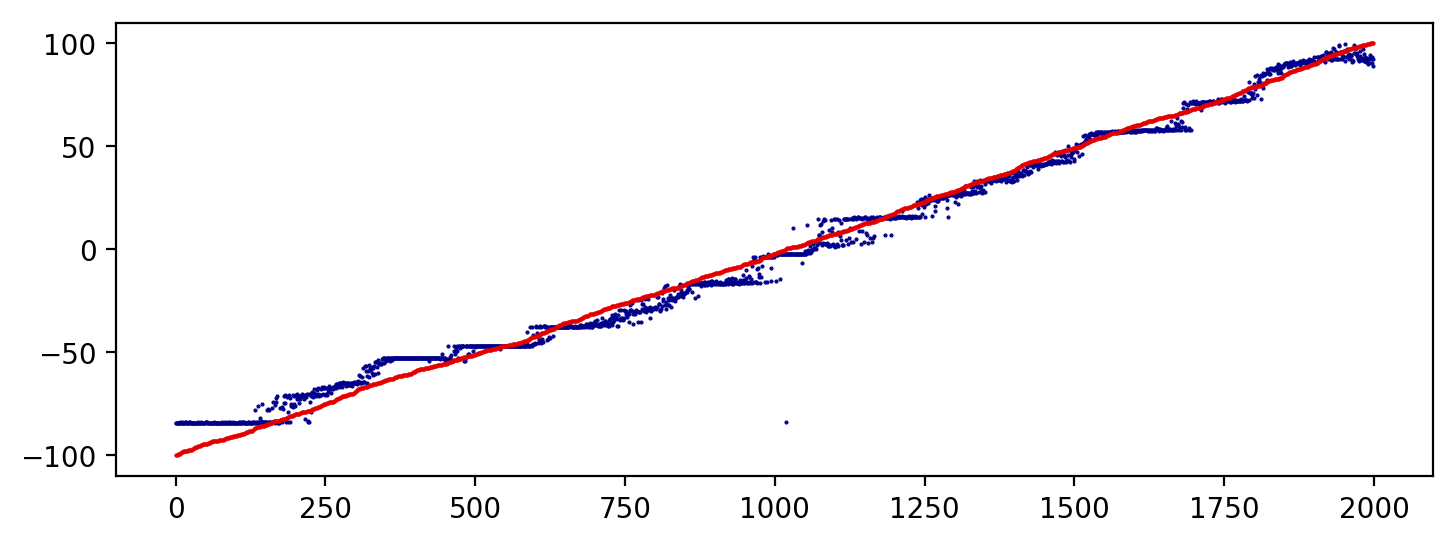

 epoch:   50 testing_cost: 0.0047052298

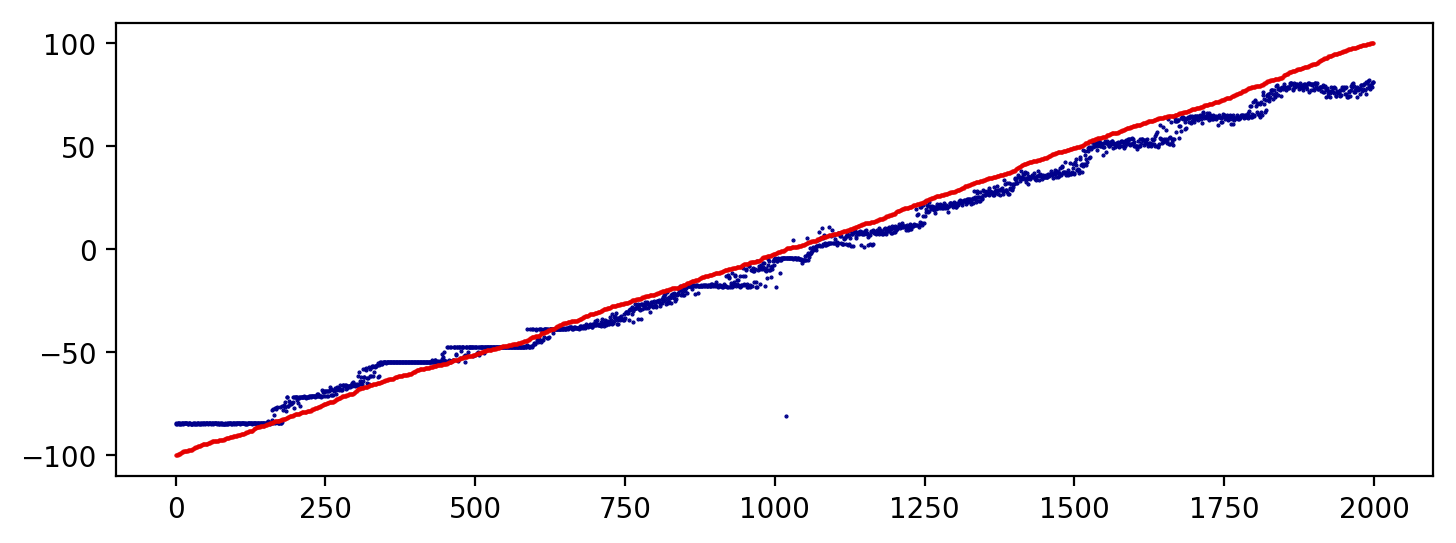

 epoch:  100 testing_cost: 0.0013792135

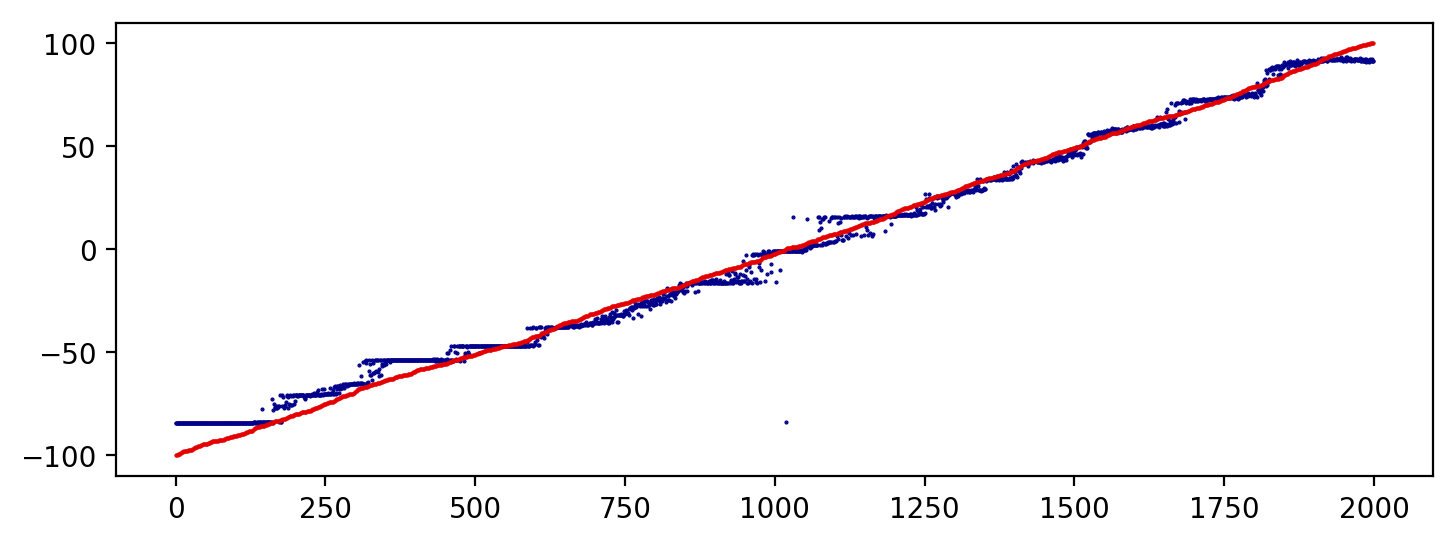

 epoch:  150 testing_cost: 0.0014190970

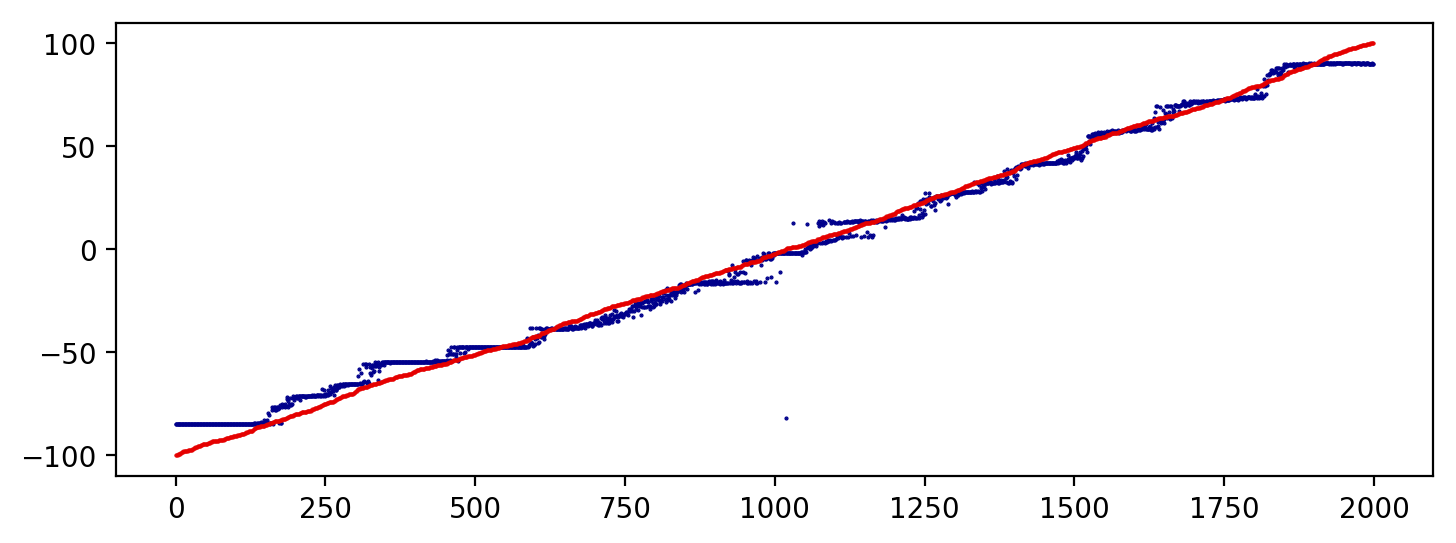

 epoch:  200 testing_cost: 0.0015384736

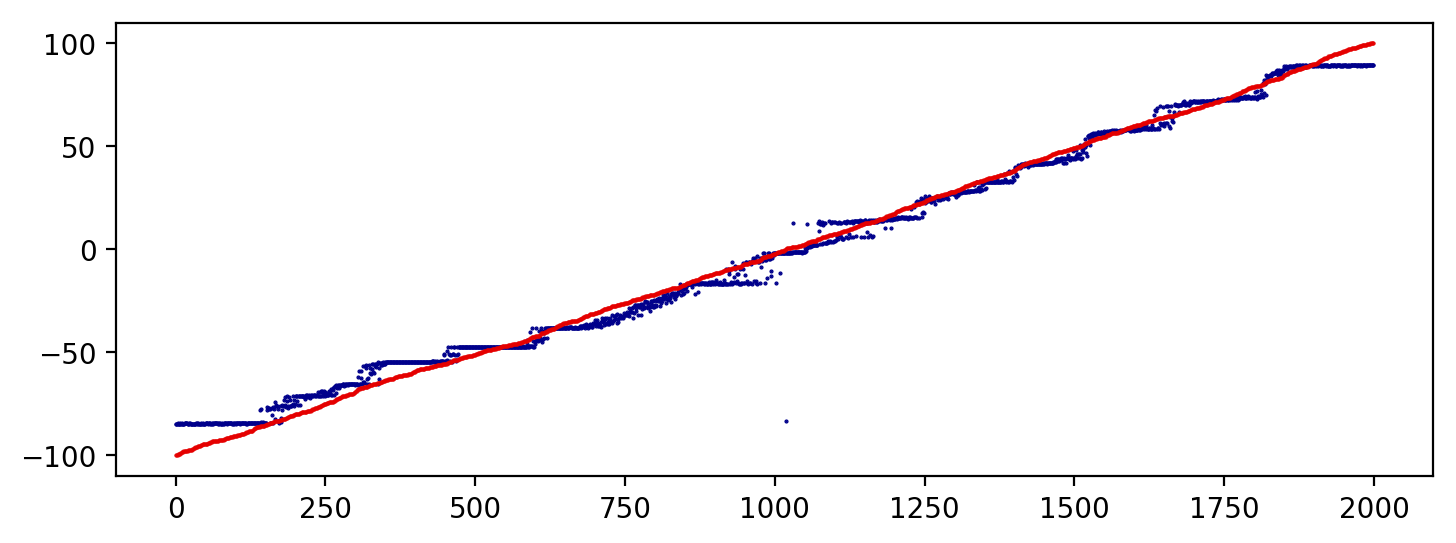

 epoch:  250 testing_cost: 0.0014515631

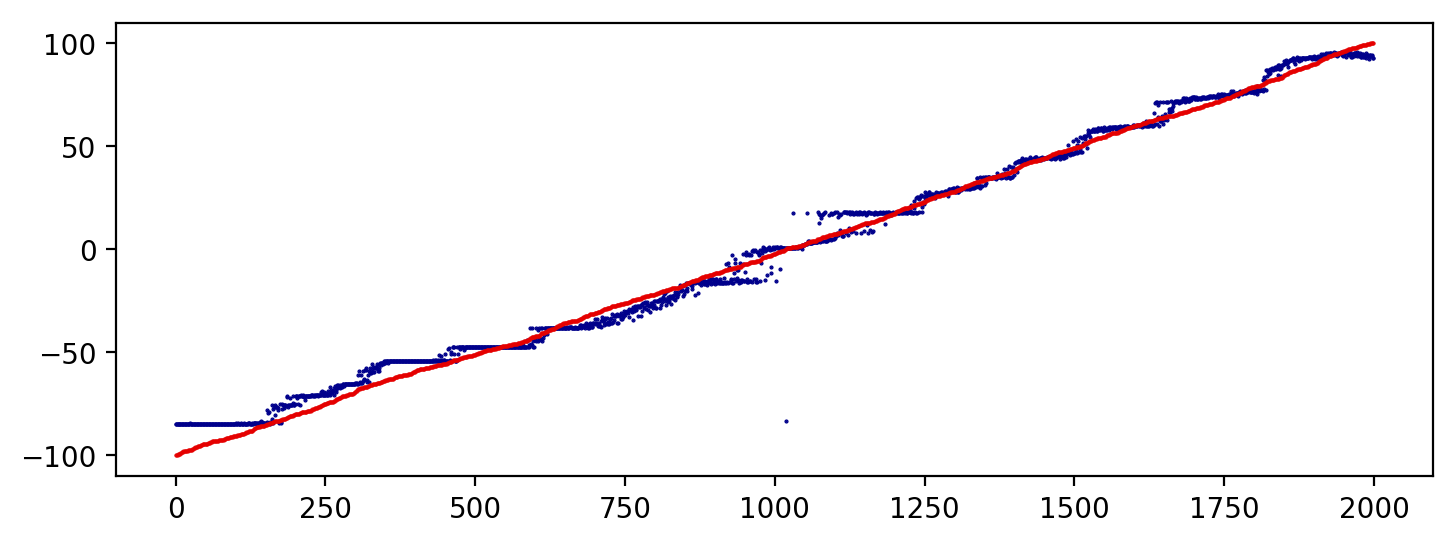

 epoch:  300 testing_cost: 0.0011973848

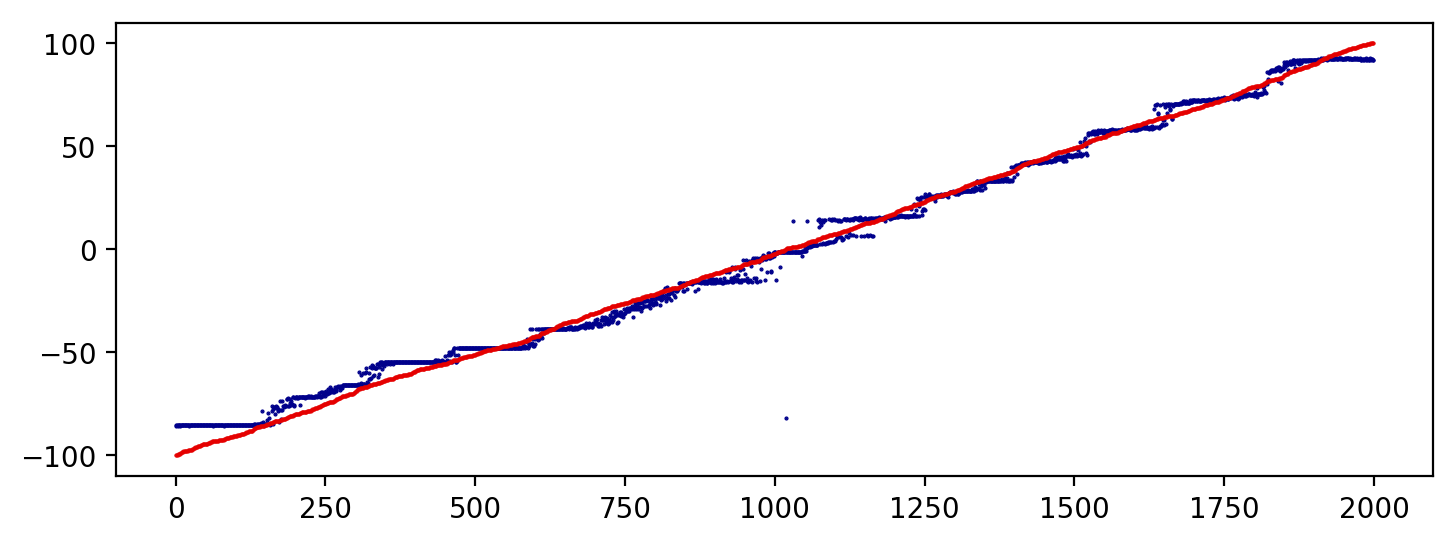

 epoch:  350 testing_cost: 0.0018762937

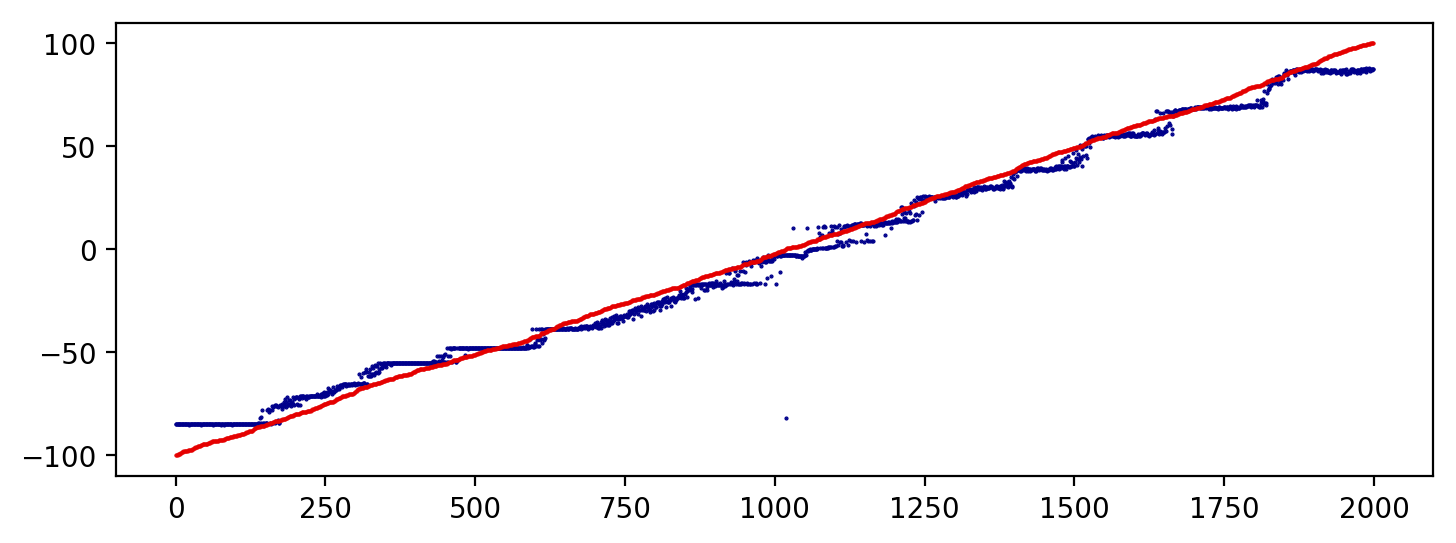

 epoch:  400 testing_cost: 0.0014892258

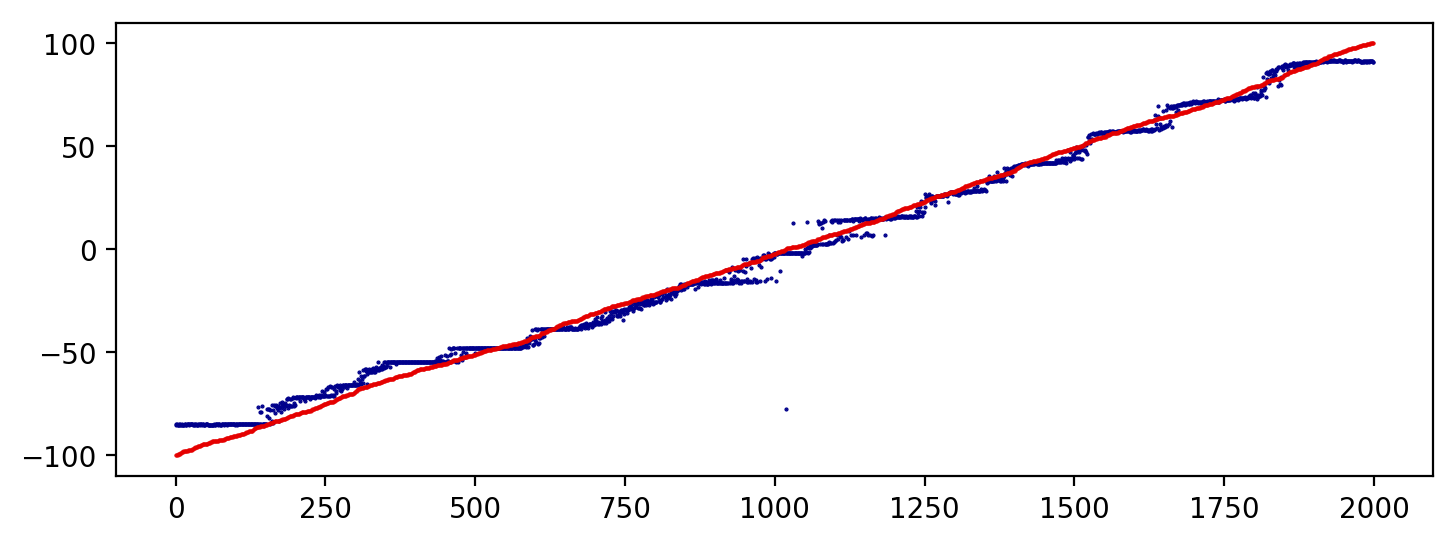

 epoch:  450 testing_cost: 0.0012480083

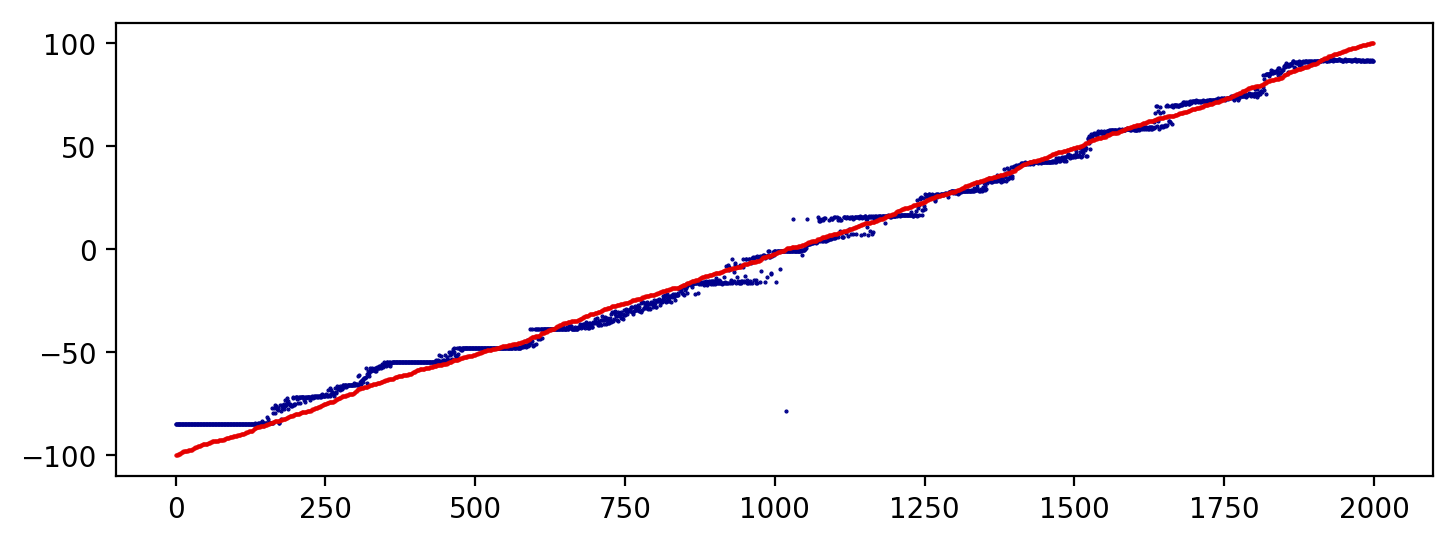

 epoch:  500 testing_cost: 0.0012367324

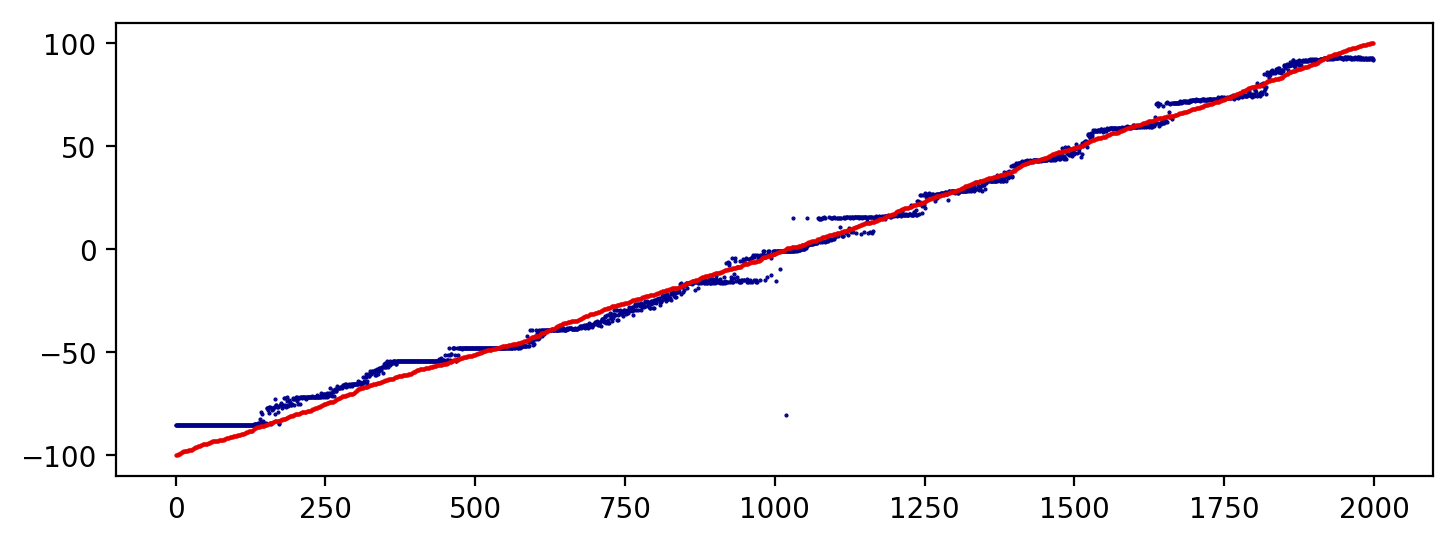

 epoch:  550 testing_cost: 0.0011960288

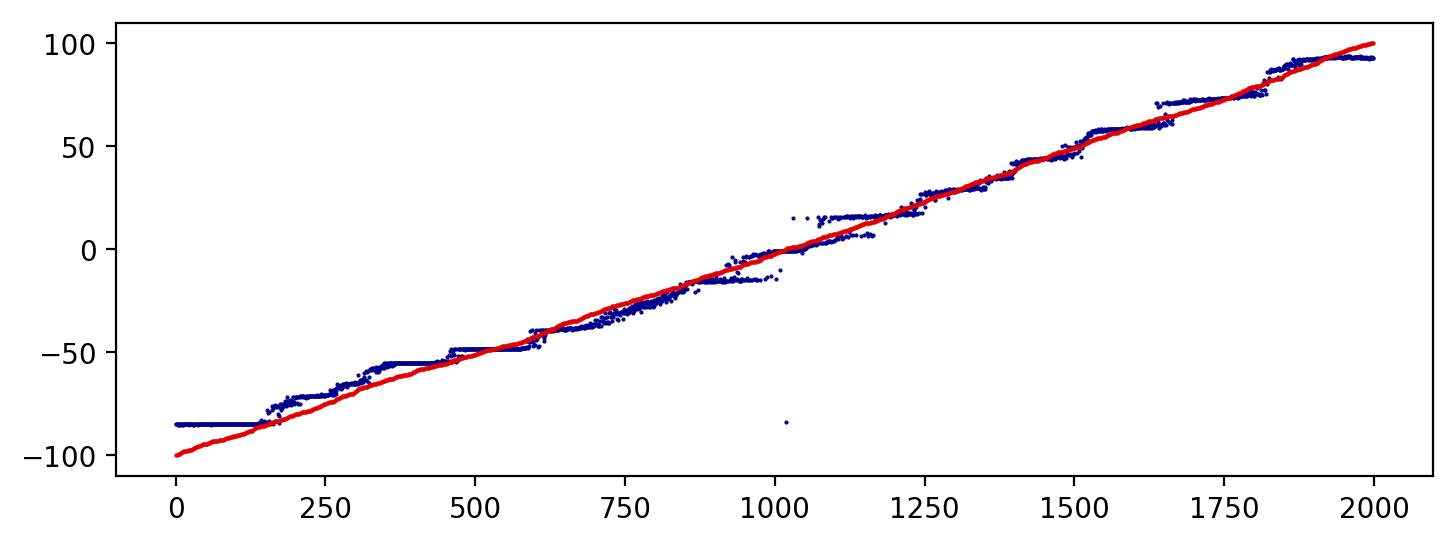

 epoch:  600 testing_cost: 0.0011148419

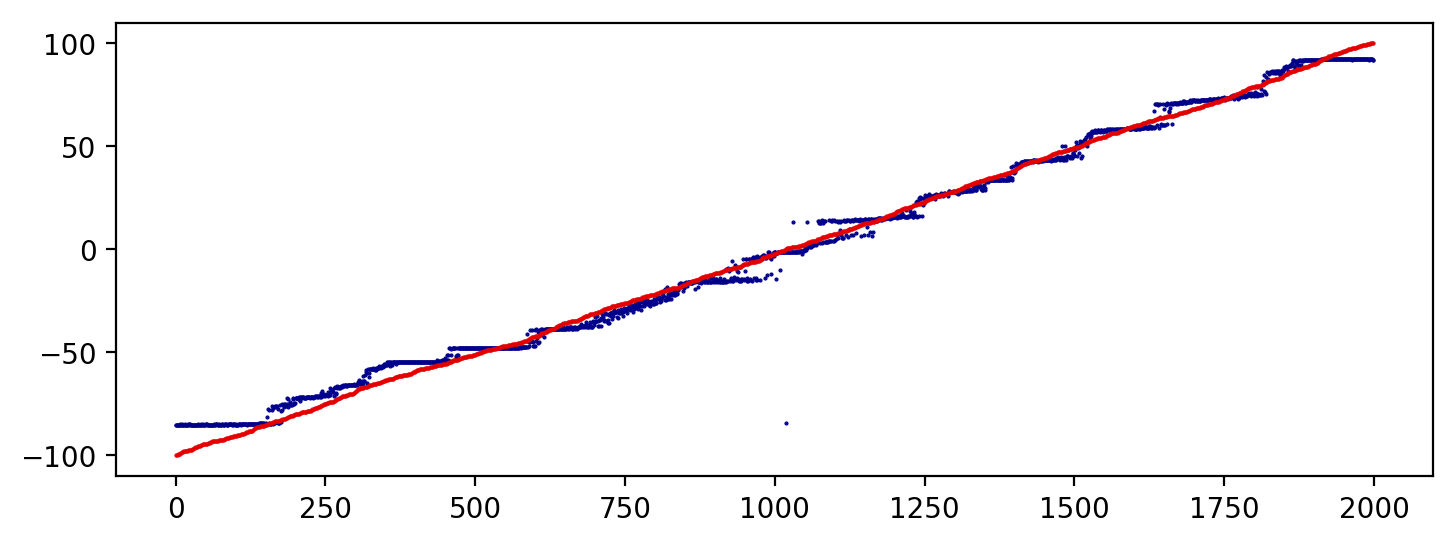

 epoch:  650 testing_cost: 0.0014658868

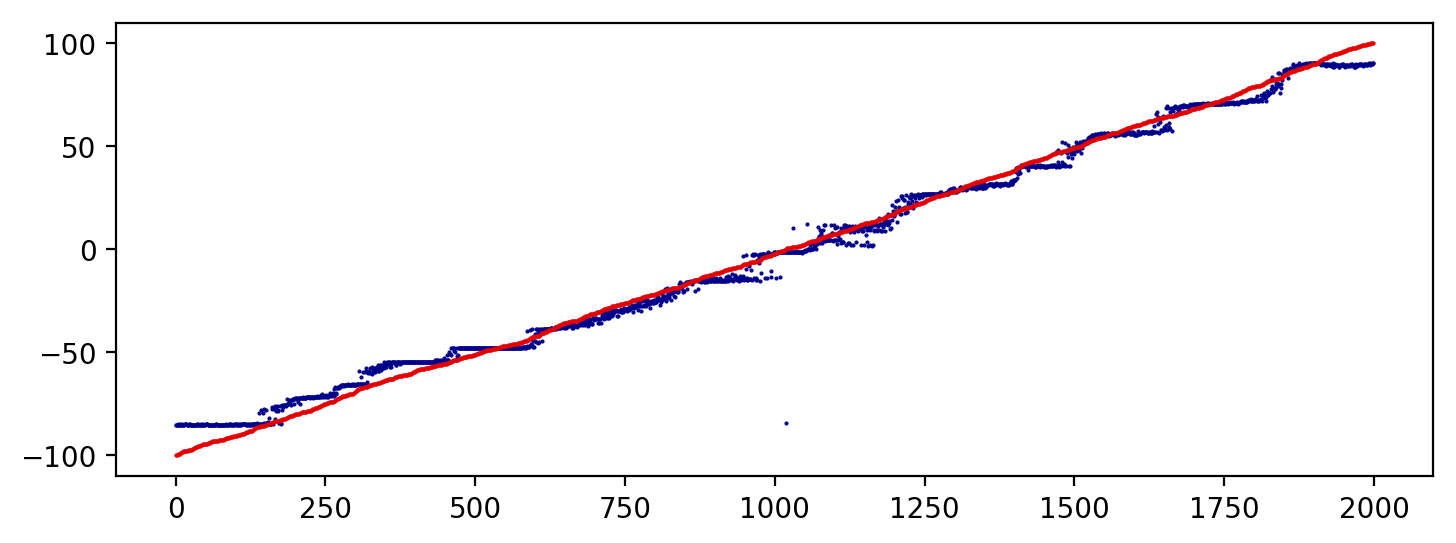

 epoch:  700 testing_cost: 0.0012740575

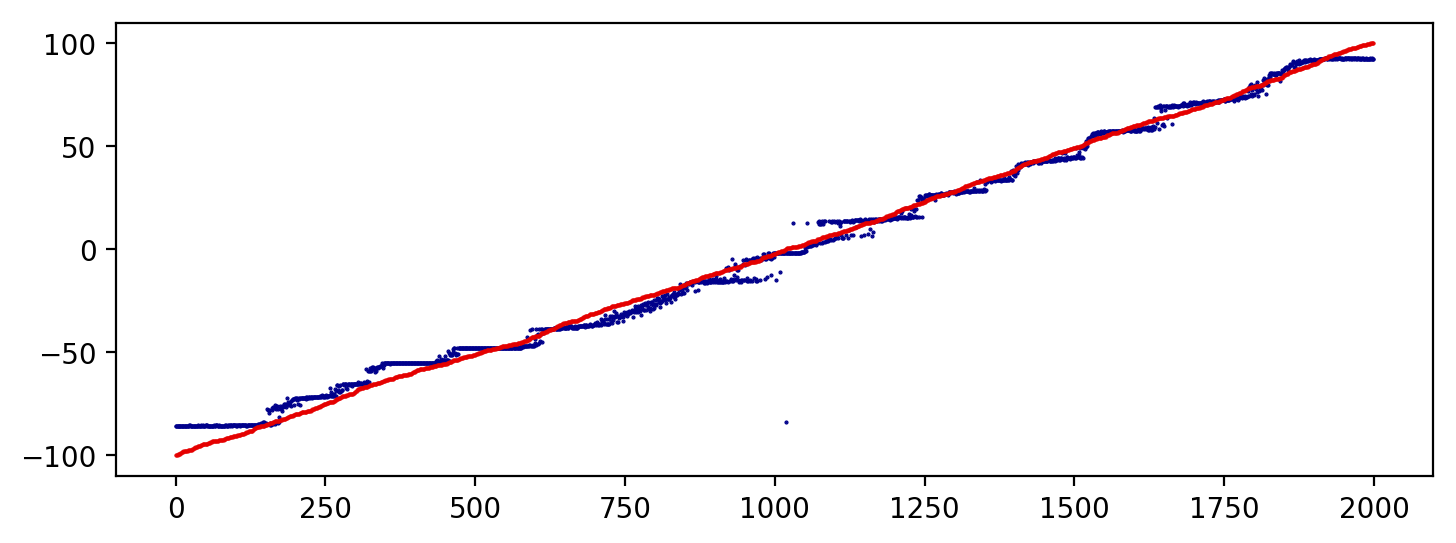

 epoch:  750 testing_cost: 0.0010740514

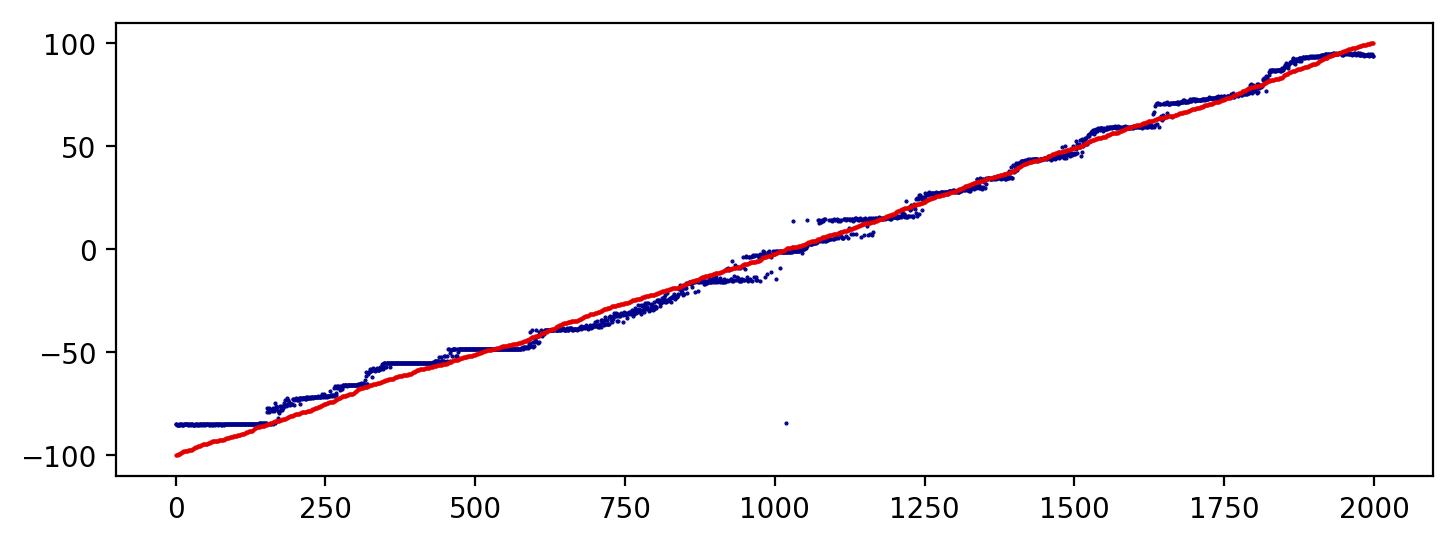

 epoch:  800 testing_cost: 0.0010132312

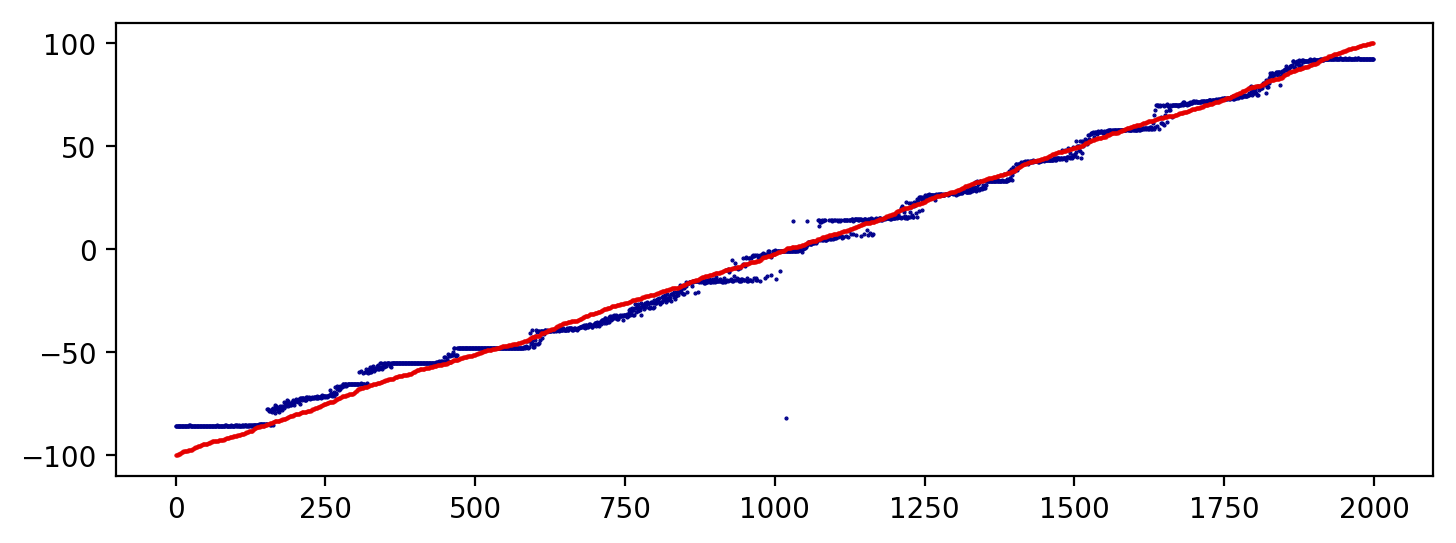

 epoch:  850 testing_cost: 0.0011311102

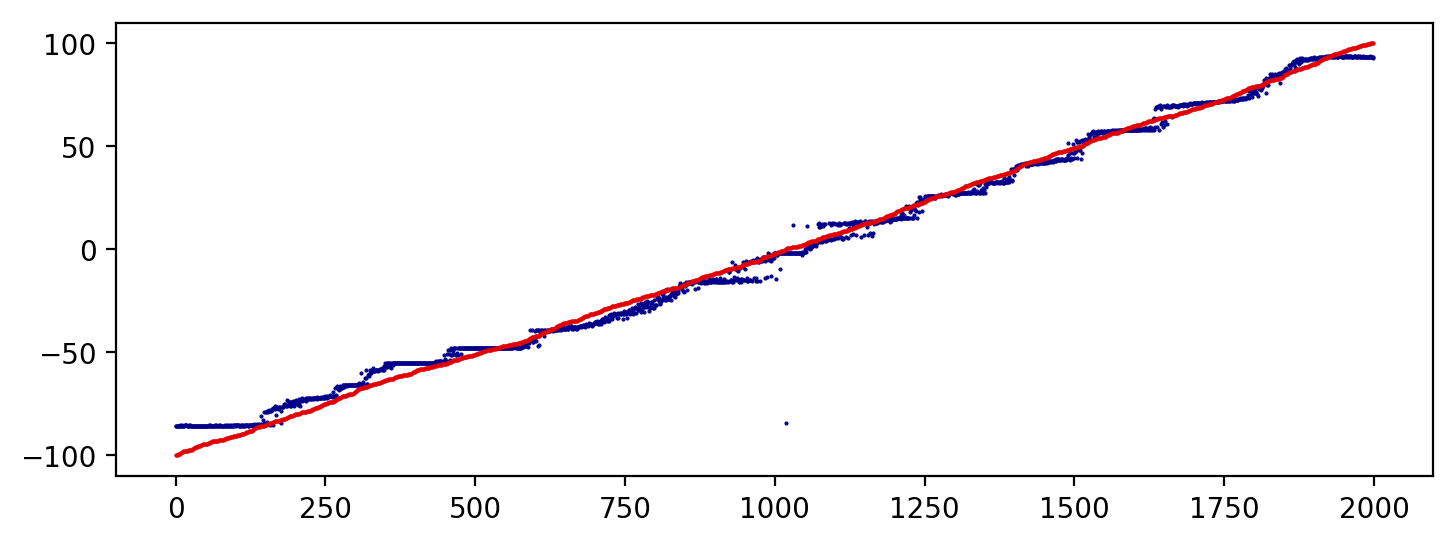

 epoch:  900 testing_cost: 0.0013788125

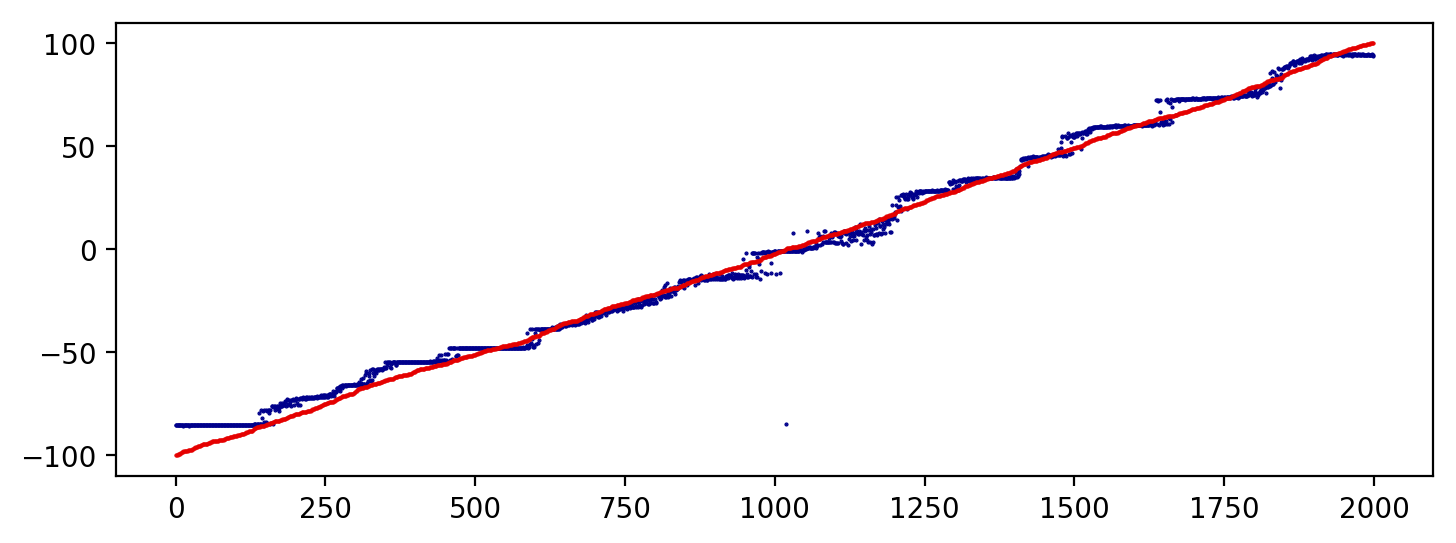

 epoch:  950 testing_cost: 0.0010220027

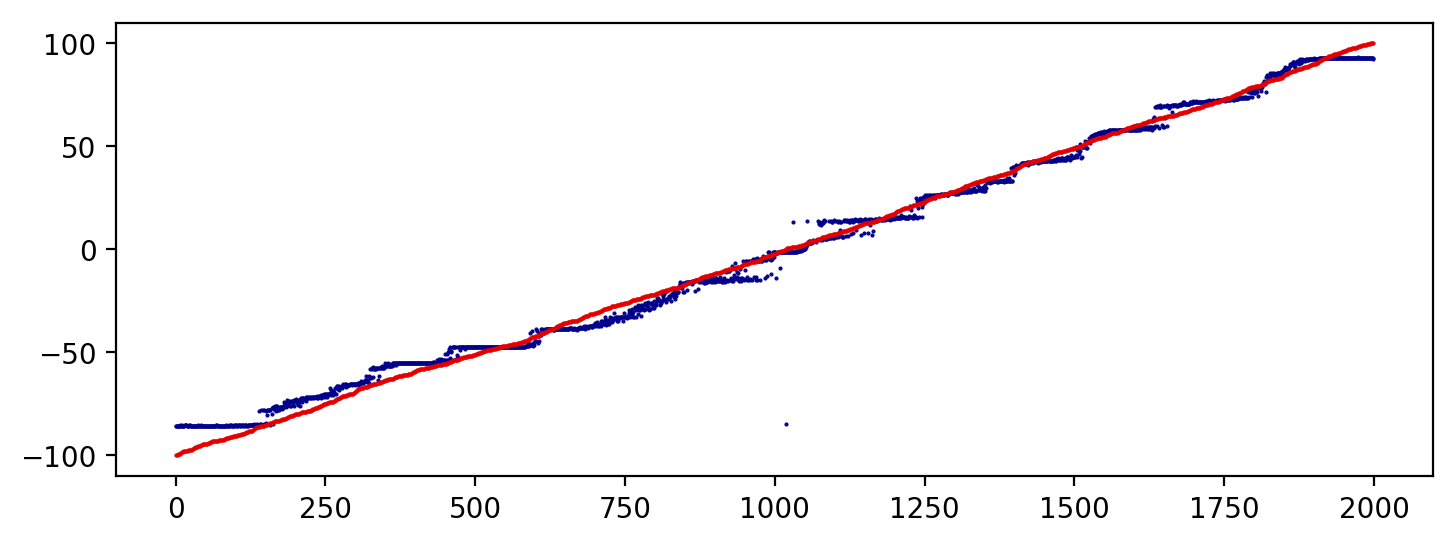

 epoch: 1000 testing_cost: 0.0015738595

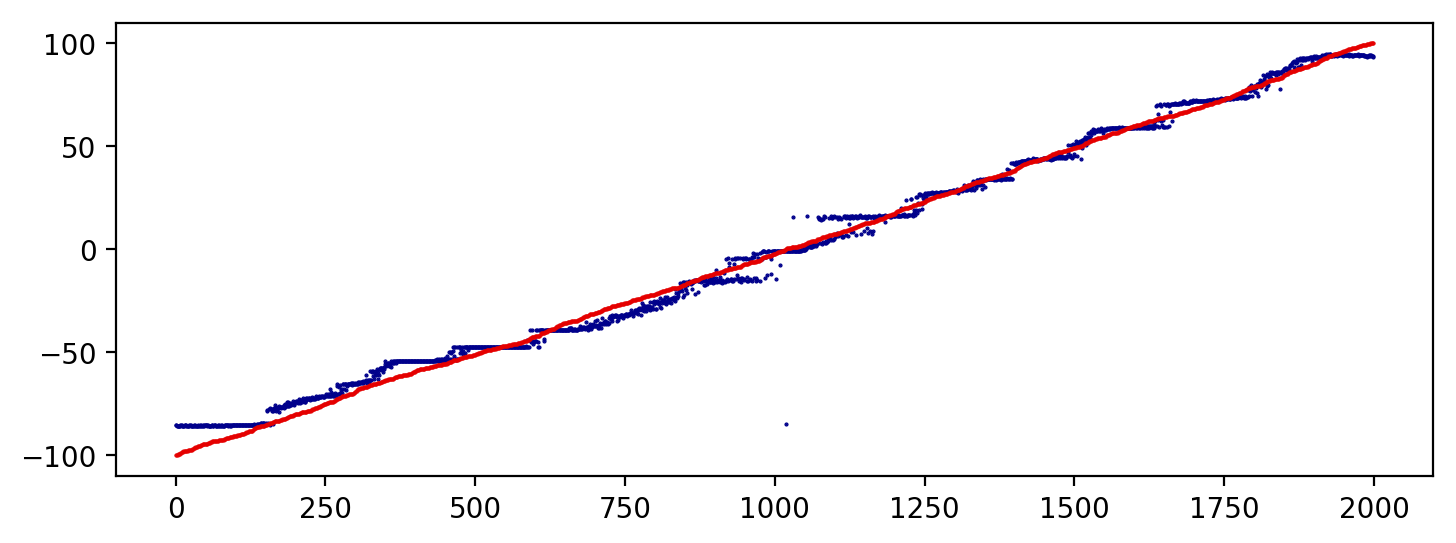

 epoch: 1050 testing_cost: 0.0012150167

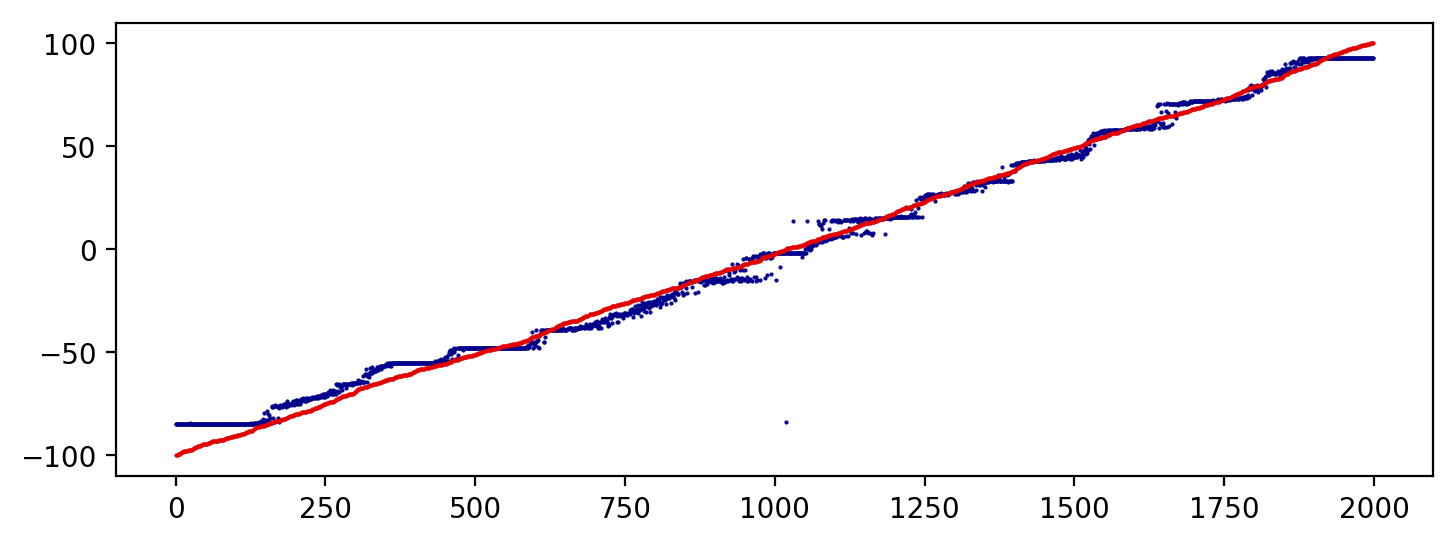

 epoch: 1100 testing_cost: 0.0010842518

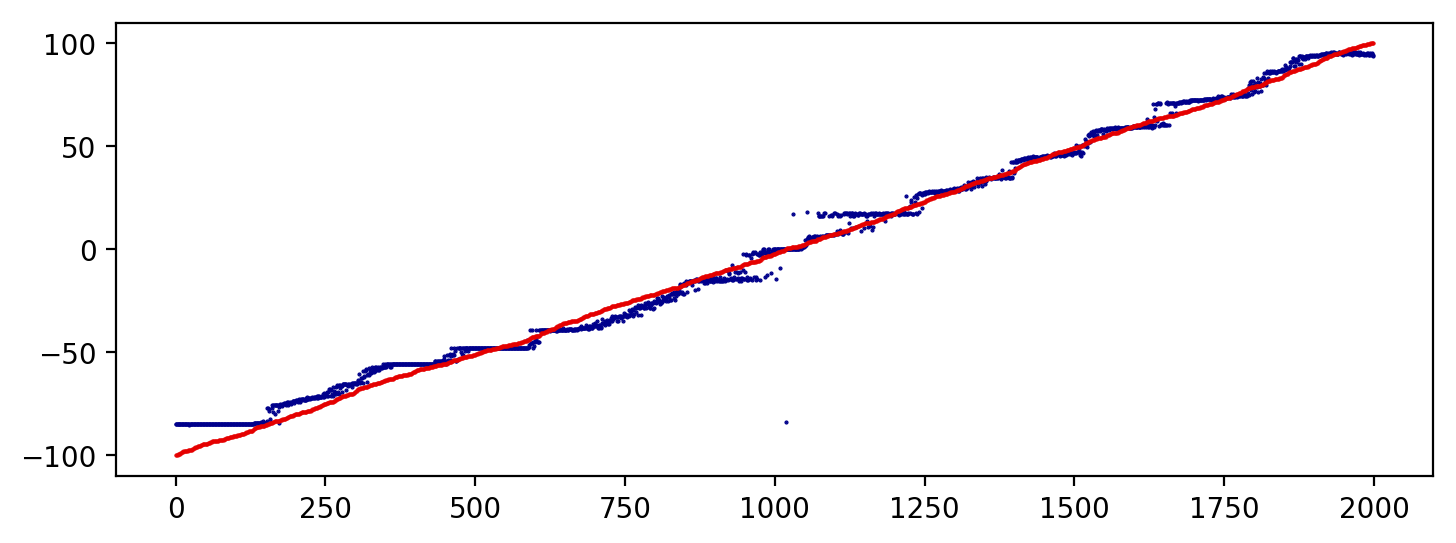

 epoch: 1150 testing_cost: 0.0009959409

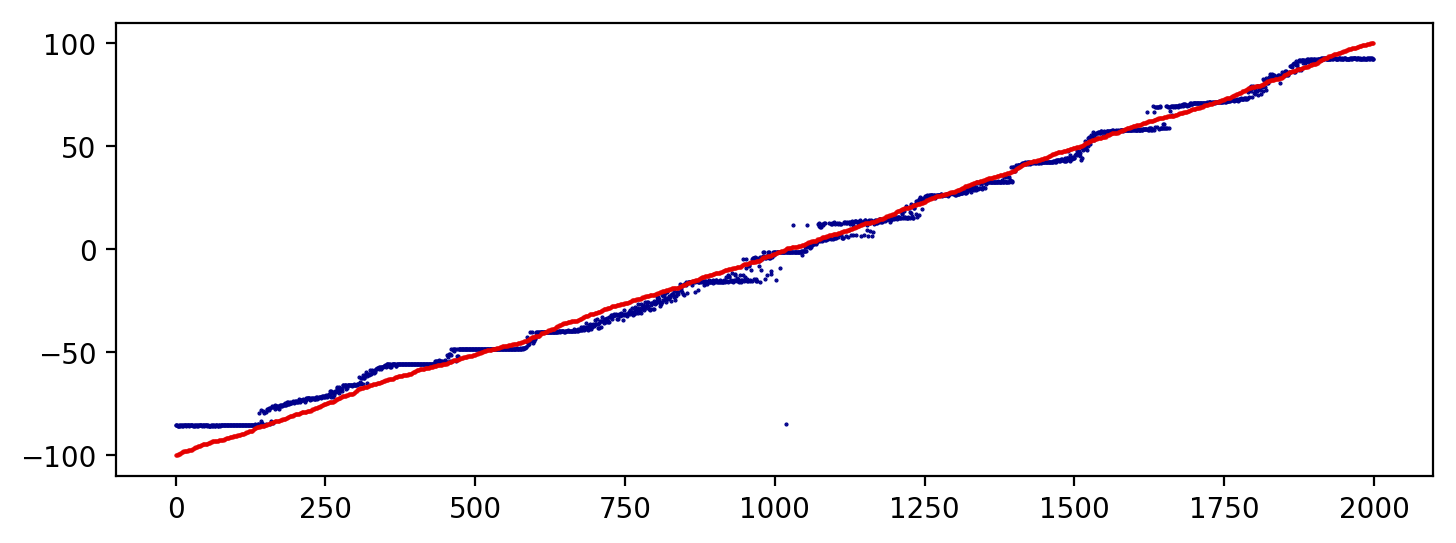

 epoch: 1200 testing_cost: 0.0012240310

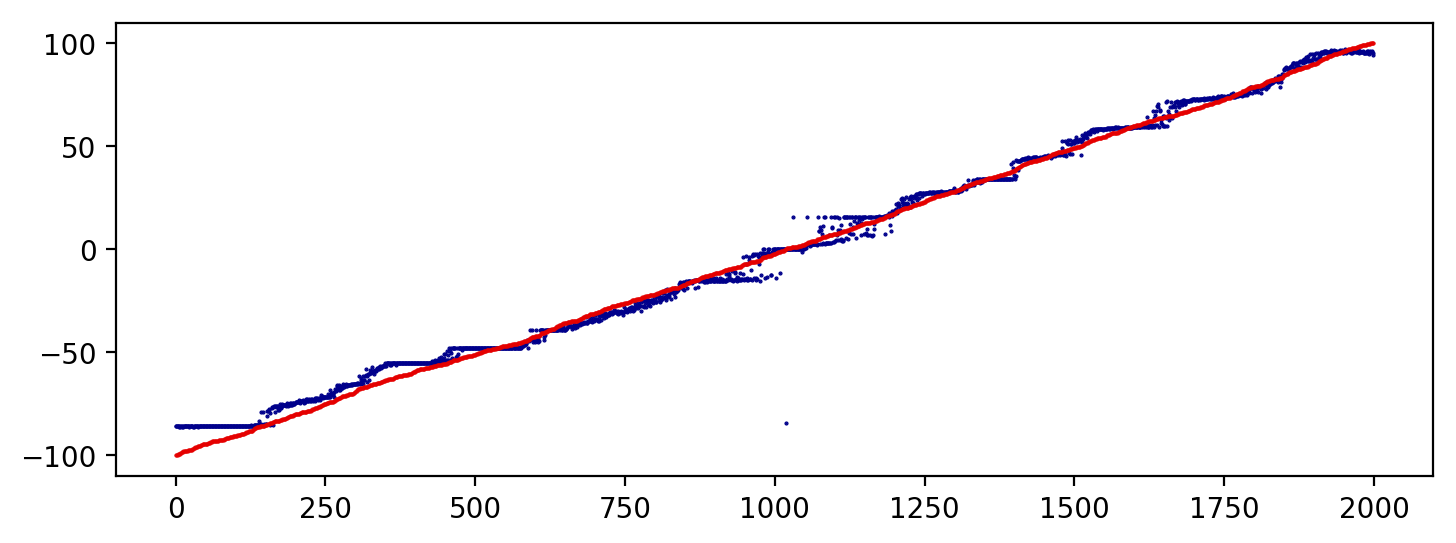

 epoch: 1250 testing_cost: 0.0010303198

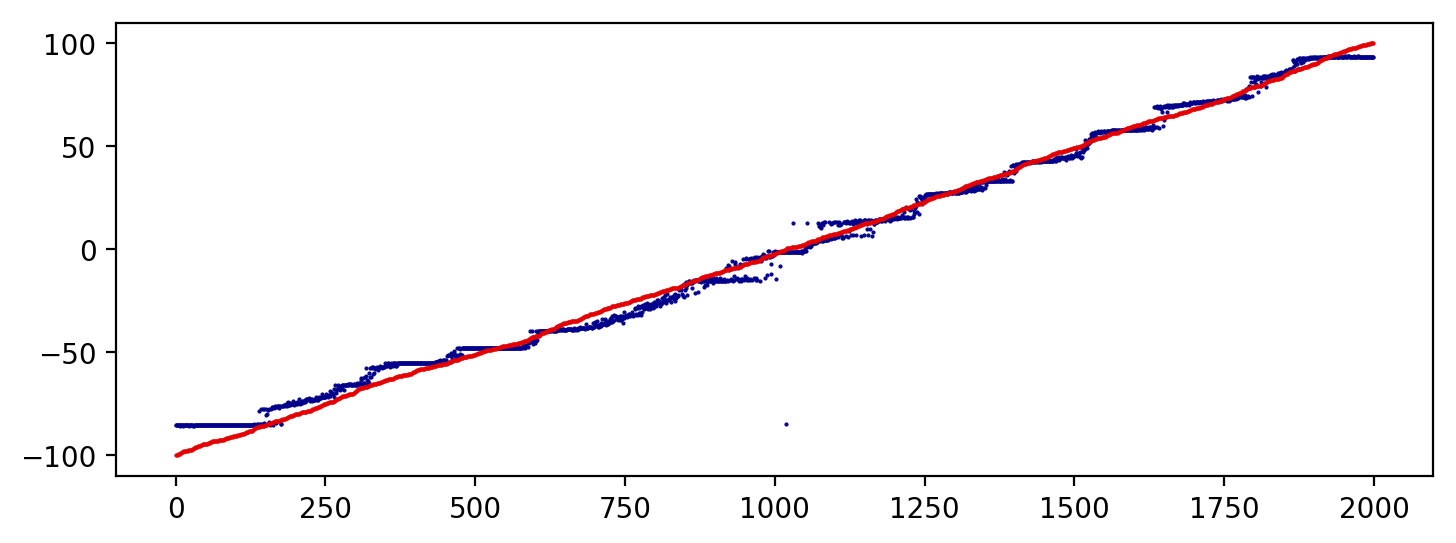

 epoch: 1300 testing_cost: 0.0013869400

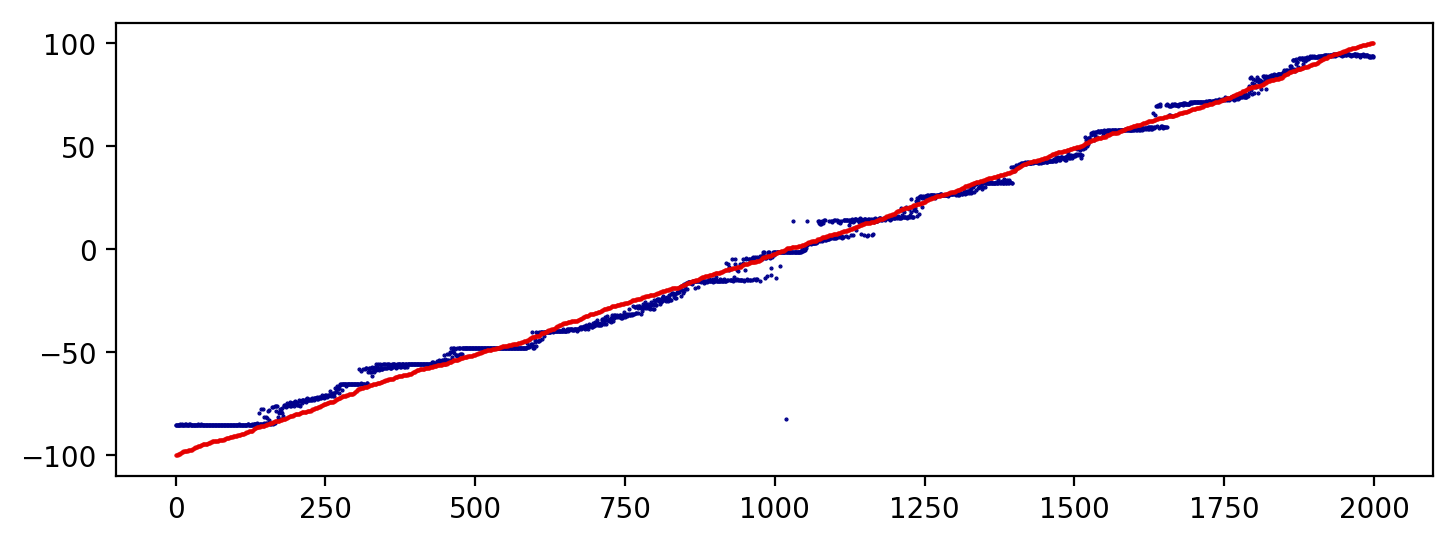

 epoch: 1350 testing_cost: 0.0011352933

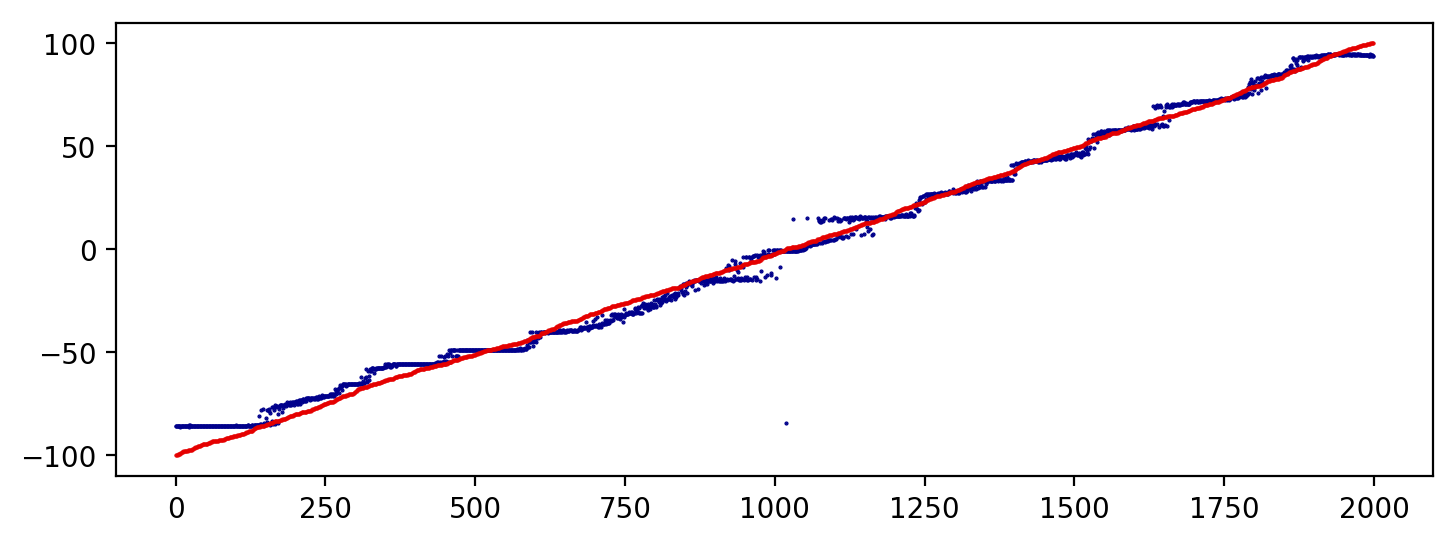

 epoch: 1400 testing_cost: 0.0010818116

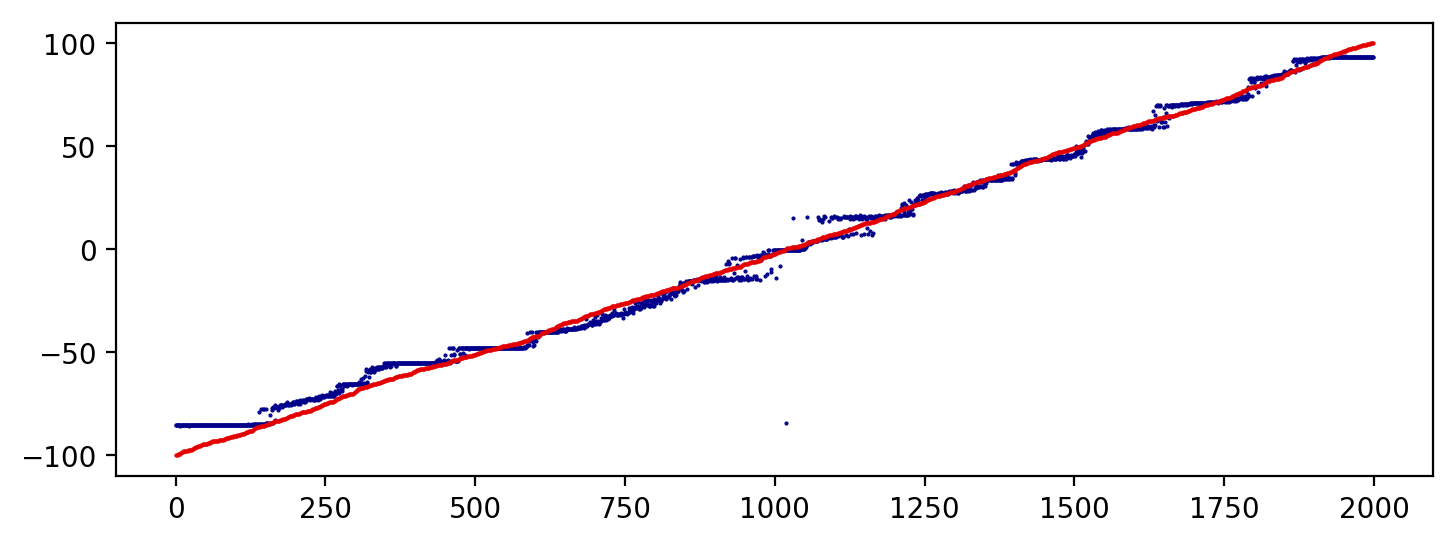

 epoch: 1450 testing_cost: 0.0015641894

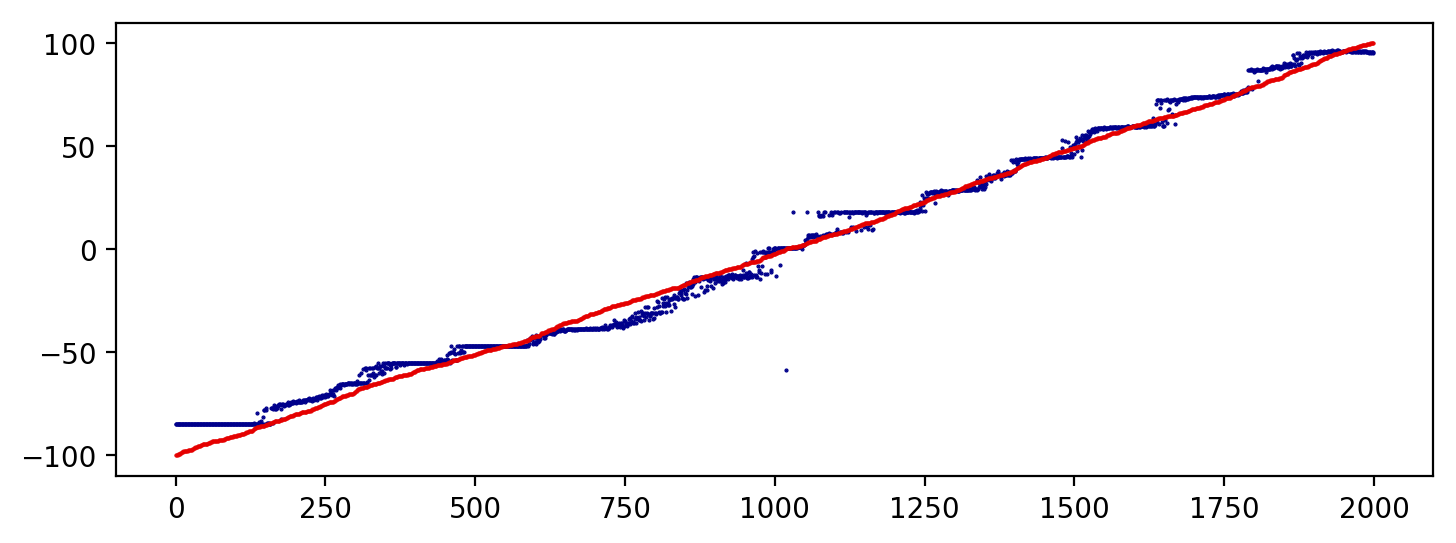

 epoch: 1499 testing_cost: 0.0009505189

In [11]:
with tf.Session() as session:

    saver.restore(session,'../../logs/693339/trained_model.ckpt-5999')


    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 0*training_epochs
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [12]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

1.4009857804455375
3.2882890273060177


In [13]:
#import data
data_df = pd.read_csv('../../data/wrapped_10000_gaussian_spikes_five_percent_B.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/517631/trained_model.ckpt-1499
 epoch: 1500 testing_cost: 0.0014122563

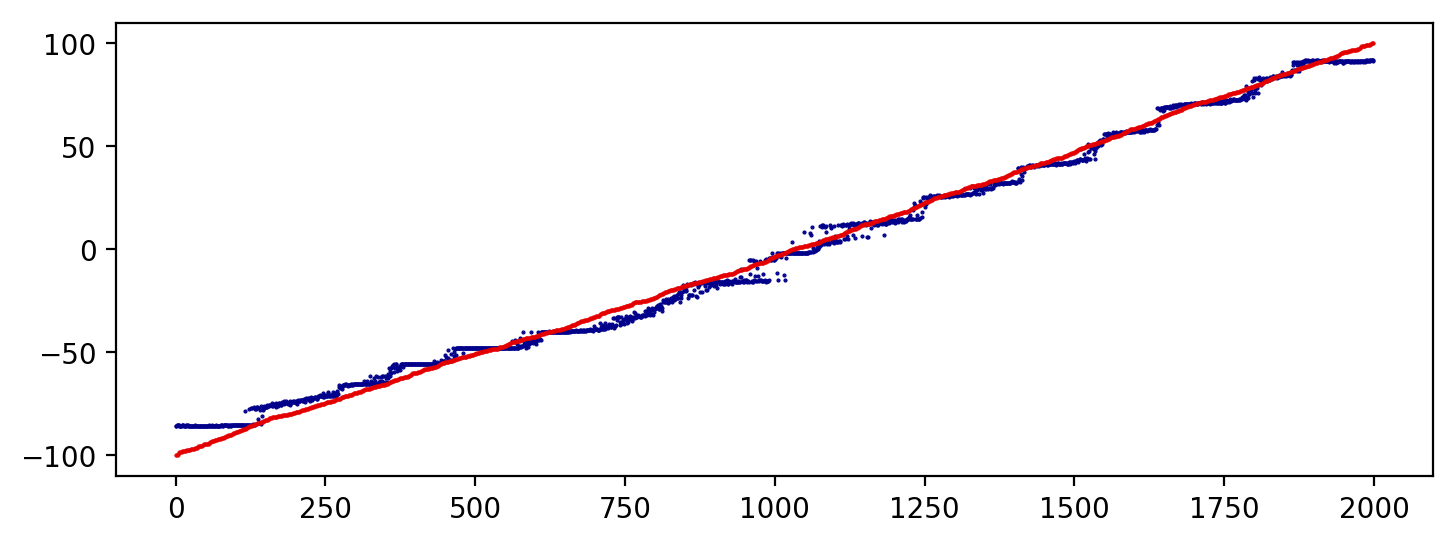

 epoch: 1550 testing_cost: 0.0012220072

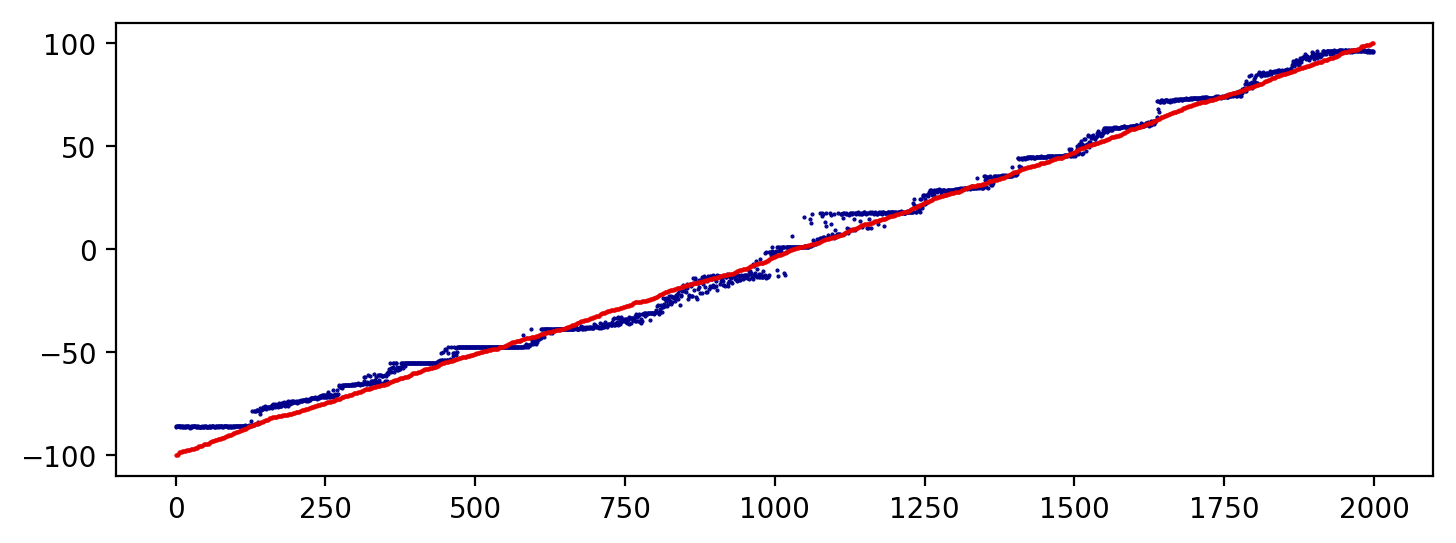

 epoch: 1600 testing_cost: 0.0012931820

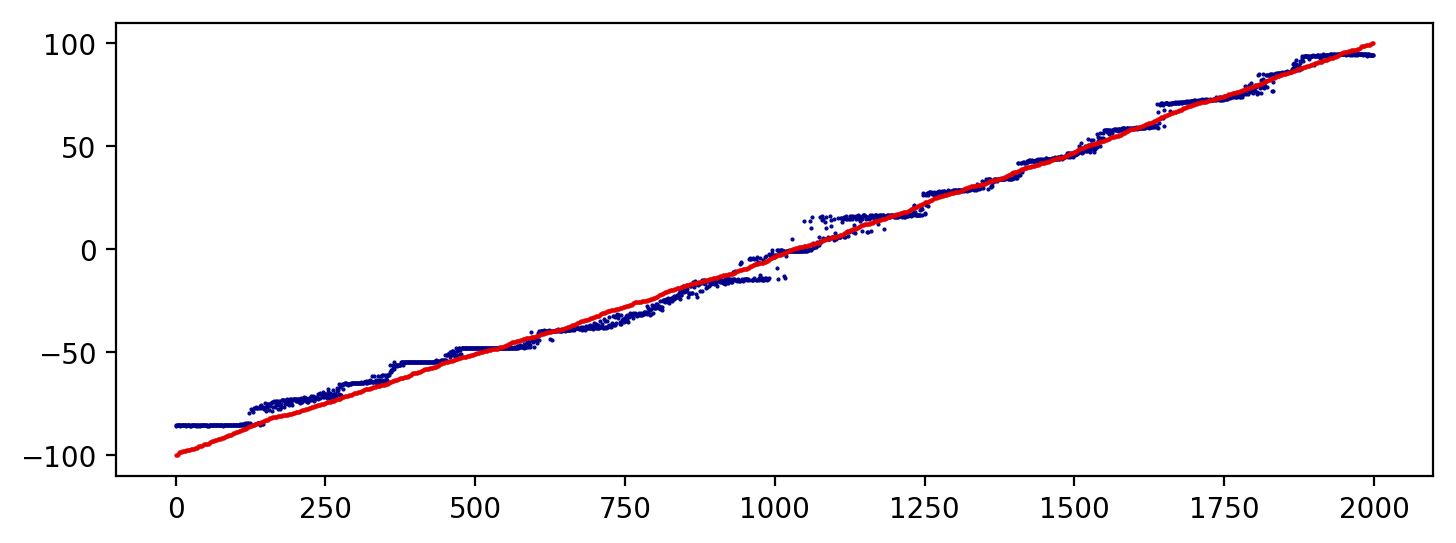

 epoch: 1650 testing_cost: 0.0010027708

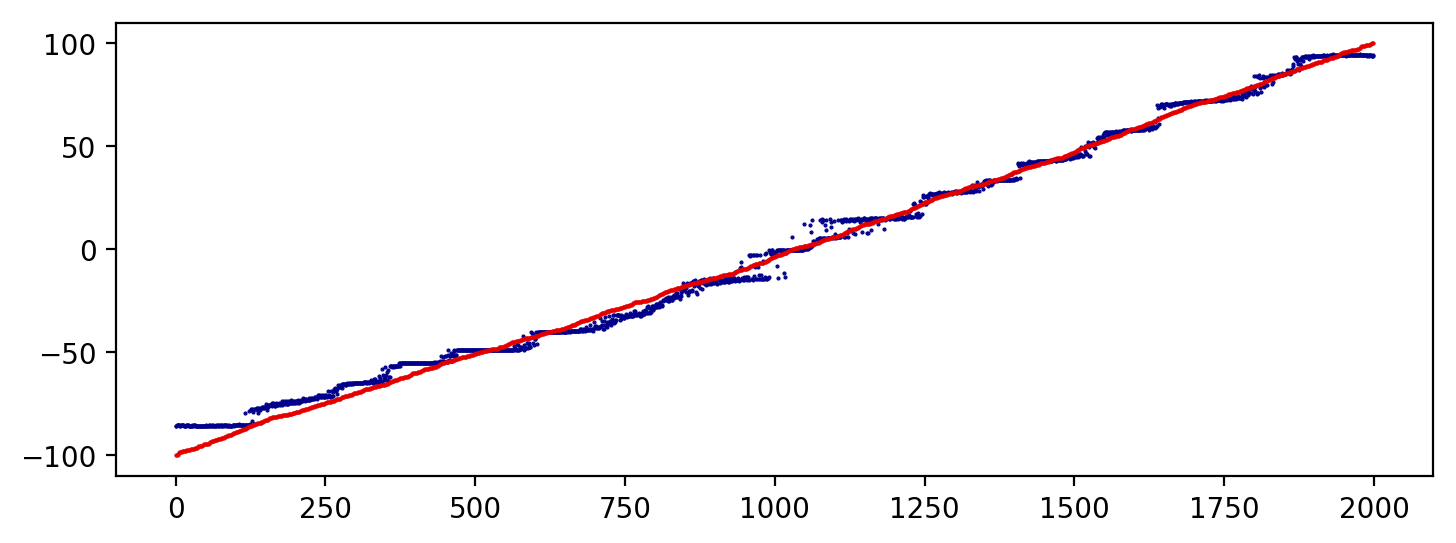

 epoch: 1700 testing_cost: 0.0011681521

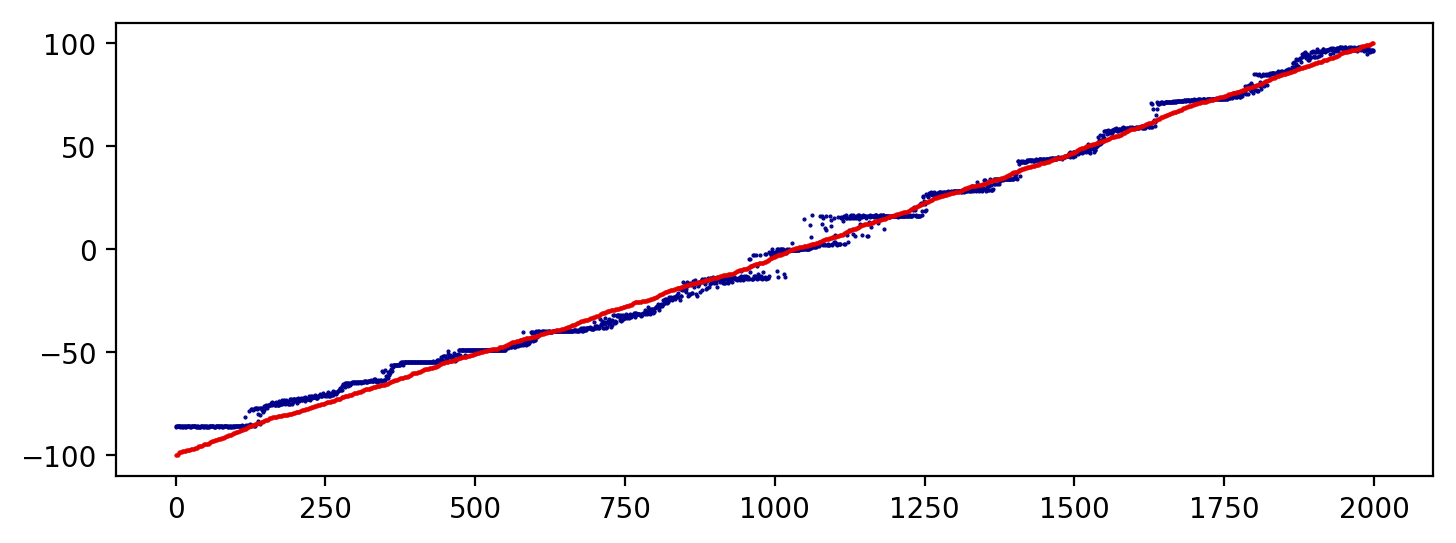

 epoch: 1750 testing_cost: 0.0009262952

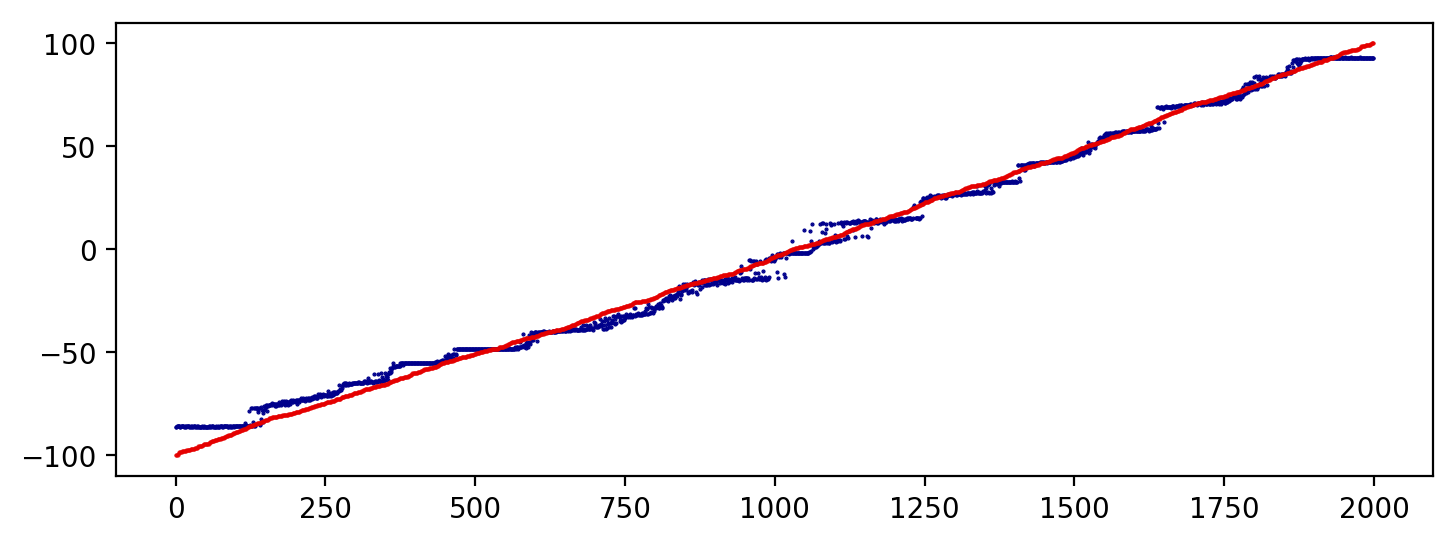

 epoch: 1800 testing_cost: 0.0011515231

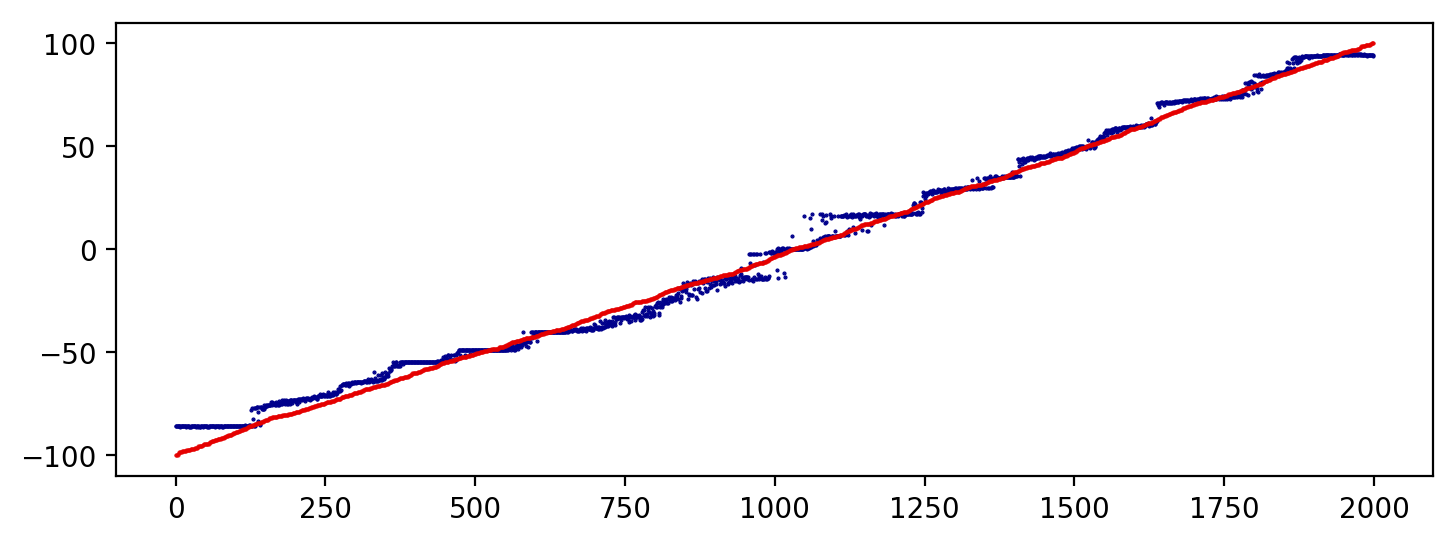

 epoch: 1850 testing_cost: 0.0012847811

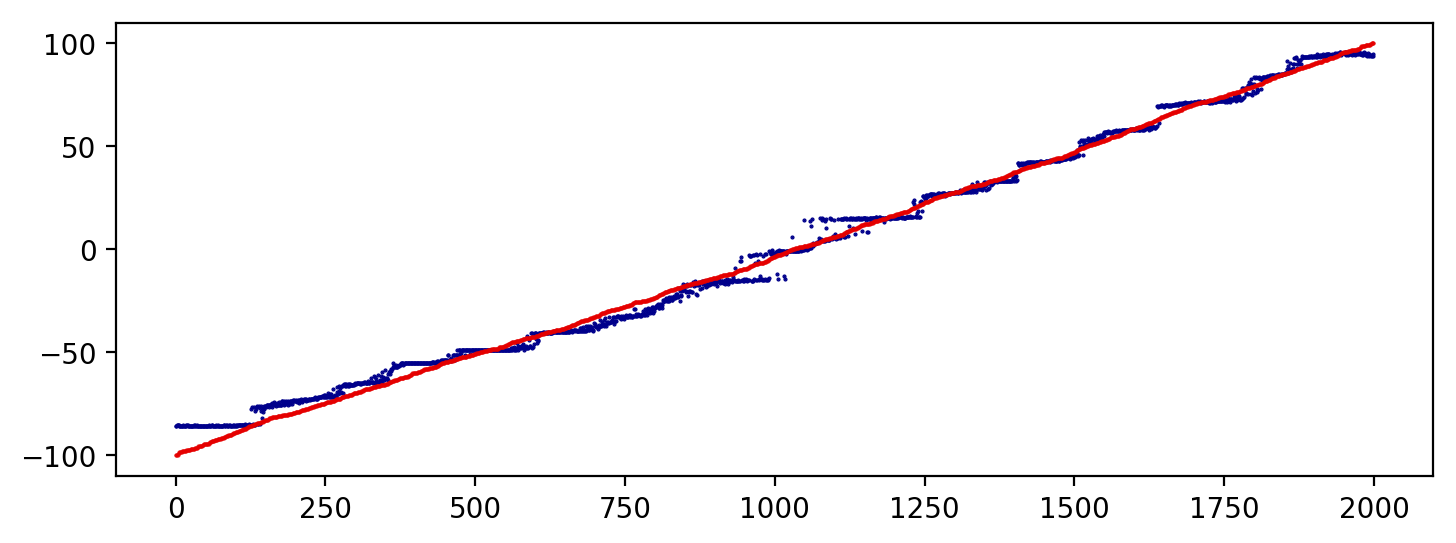

 epoch: 1900 testing_cost: 0.0011525106

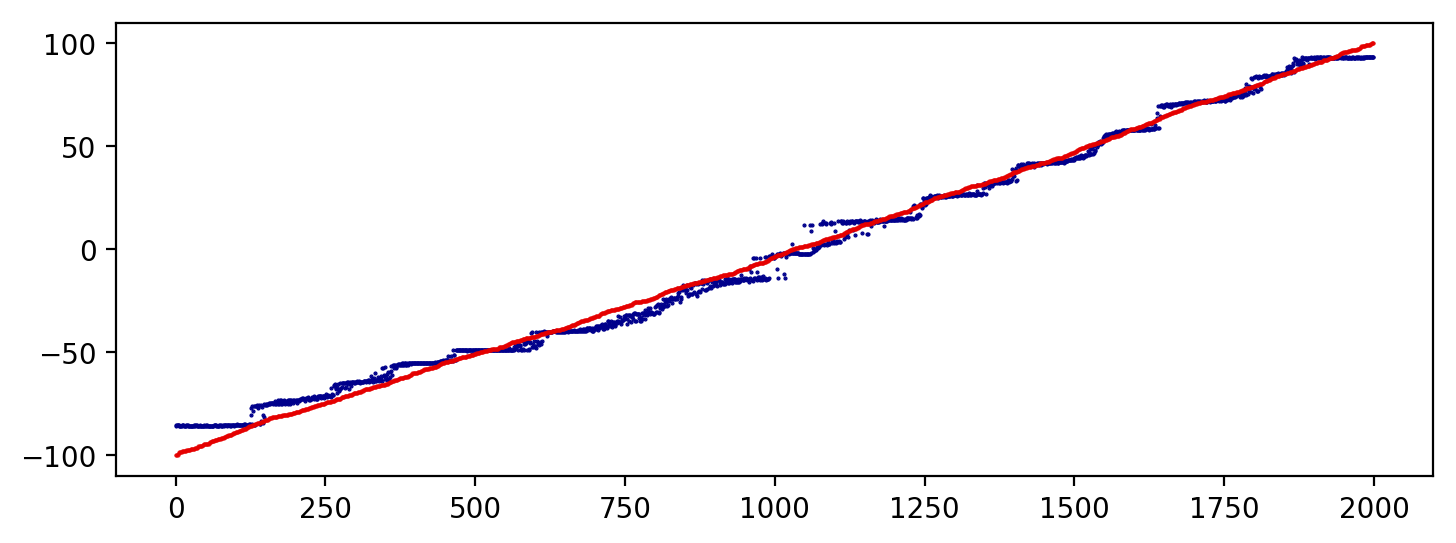

 epoch: 1950 testing_cost: 0.0011579945

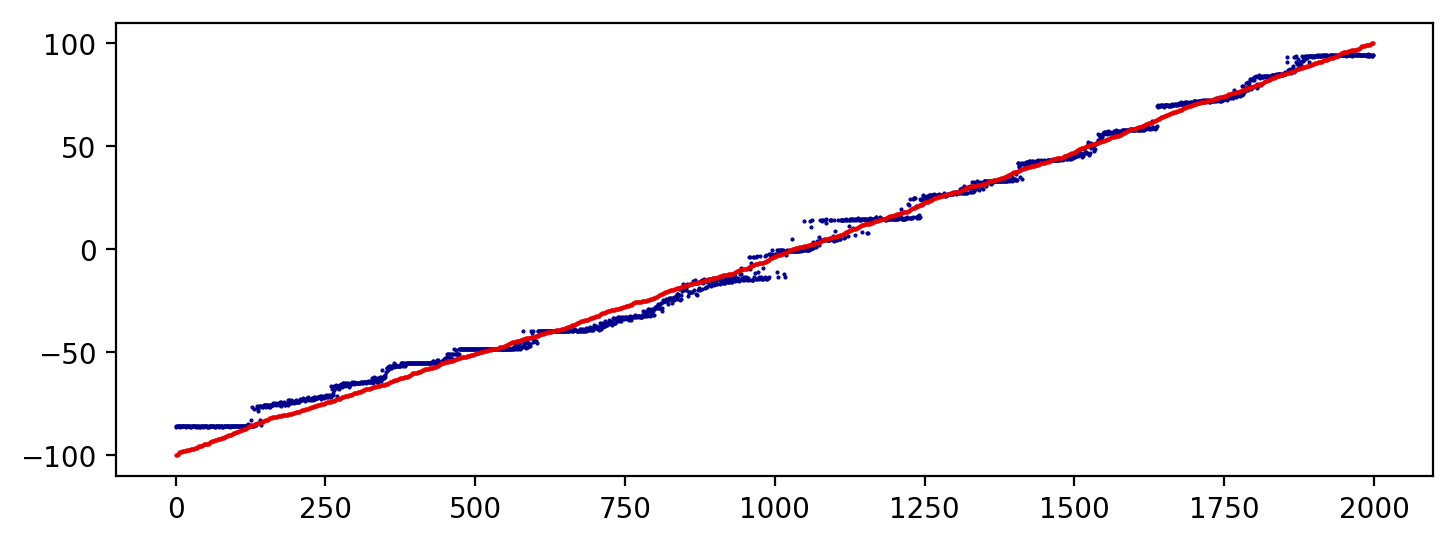

 epoch: 2000 testing_cost: 0.0010317476

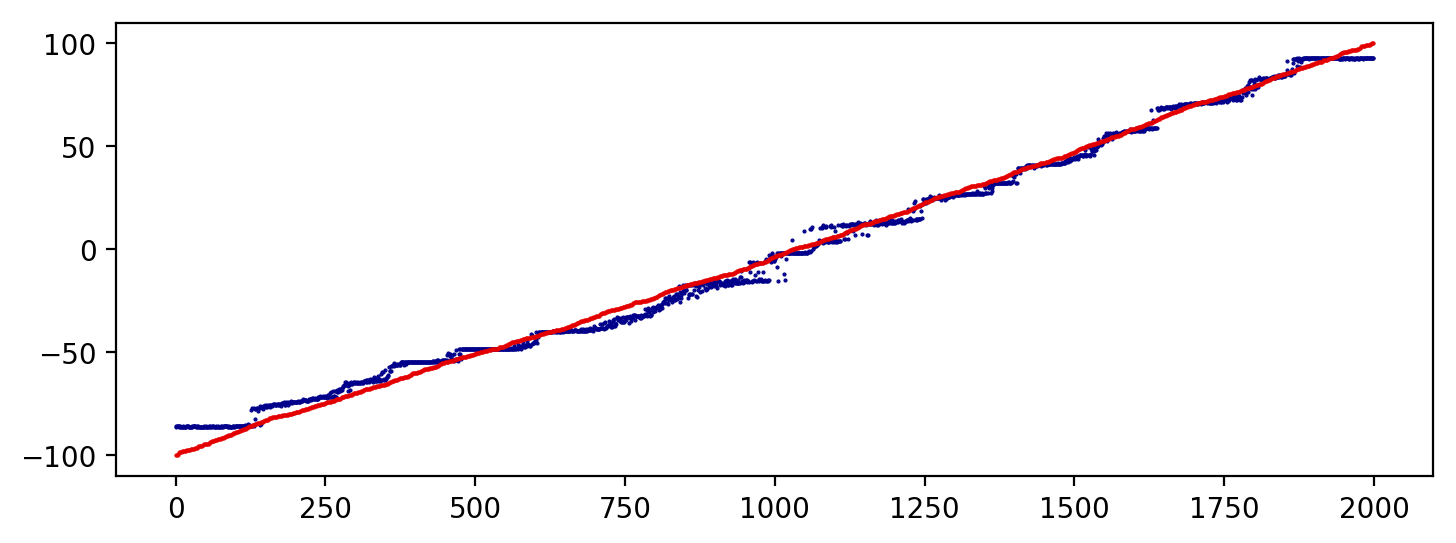

 epoch: 2050 testing_cost: 0.0022256724

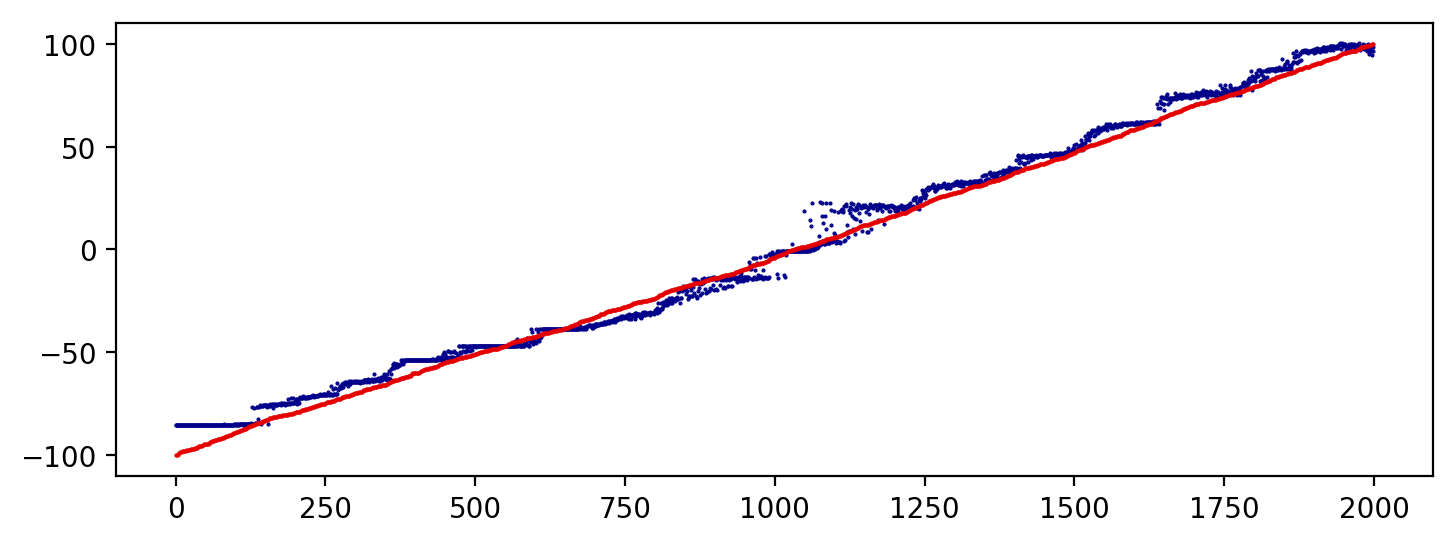

 epoch: 2100 testing_cost: 0.0021859228

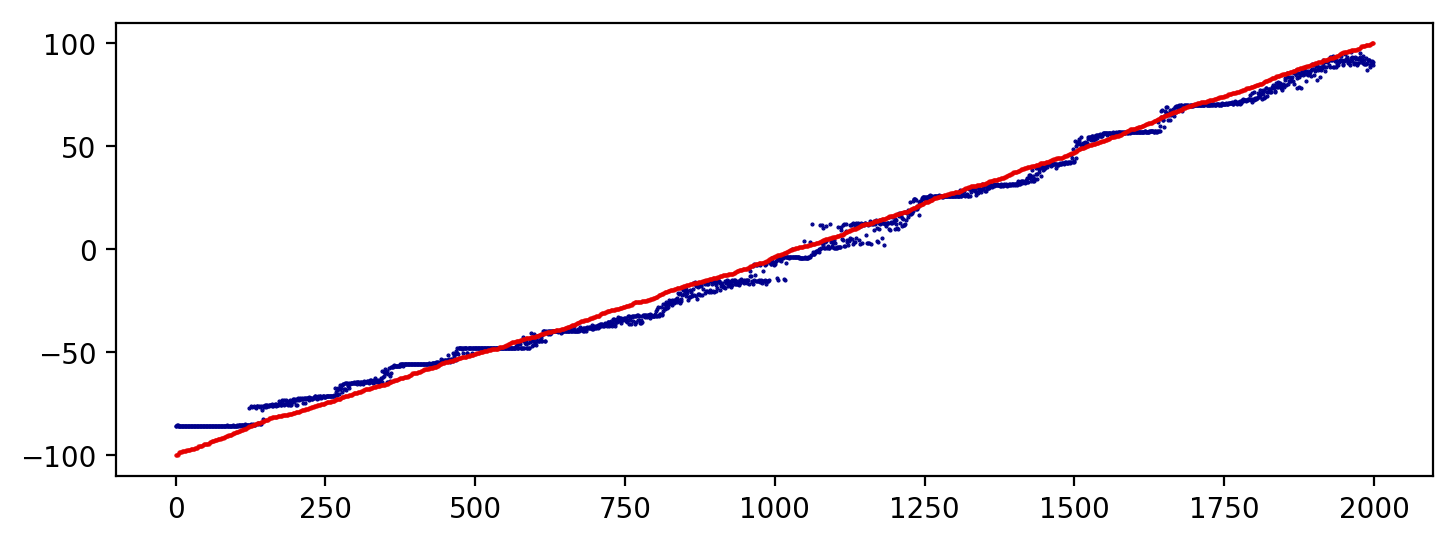

 epoch: 2150 testing_cost: 0.0012095518

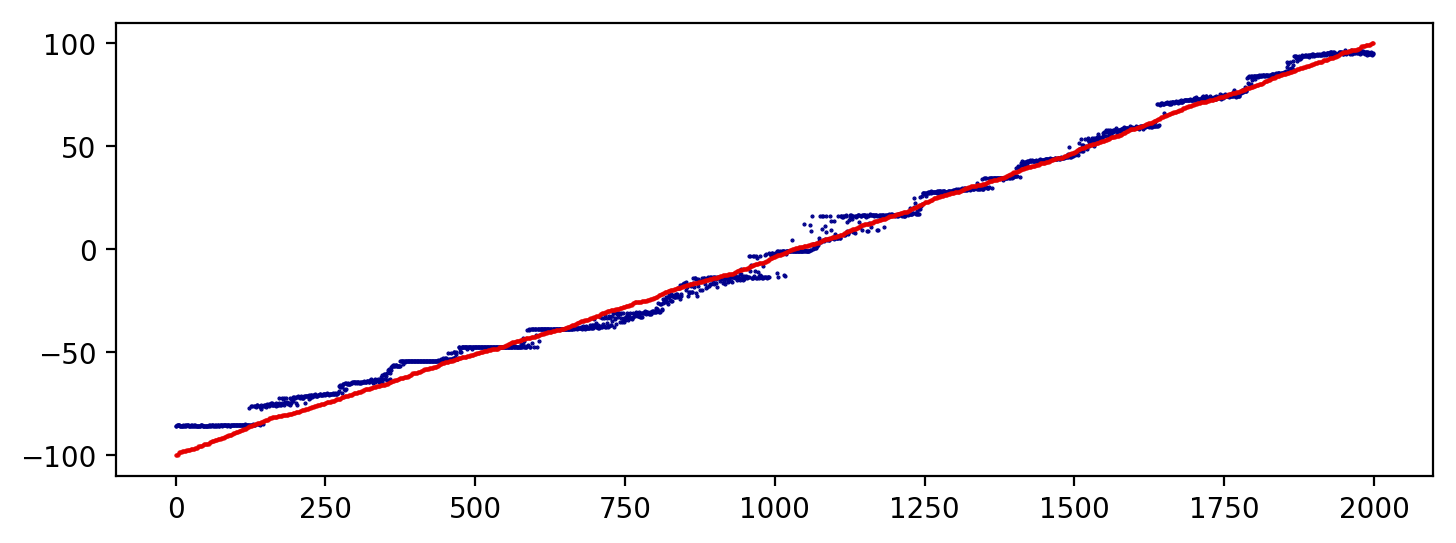

 epoch: 2200 testing_cost: 0.0015093400

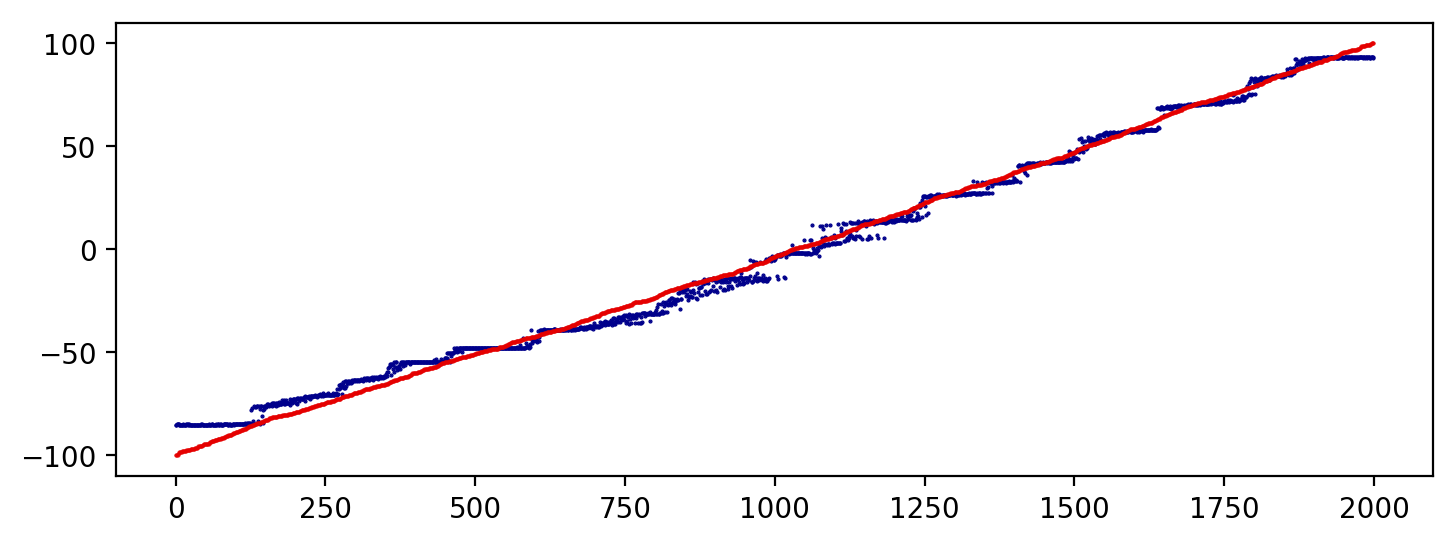

 epoch: 2250 testing_cost: 0.0013313830

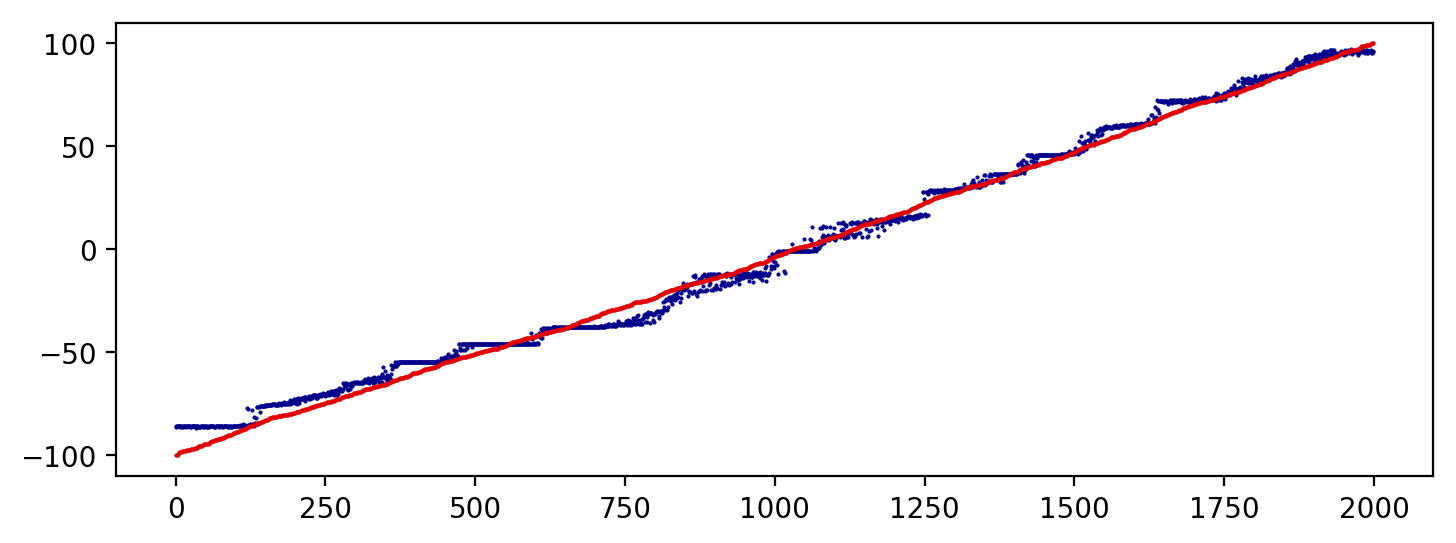

 epoch: 2300 testing_cost: 0.0012070778

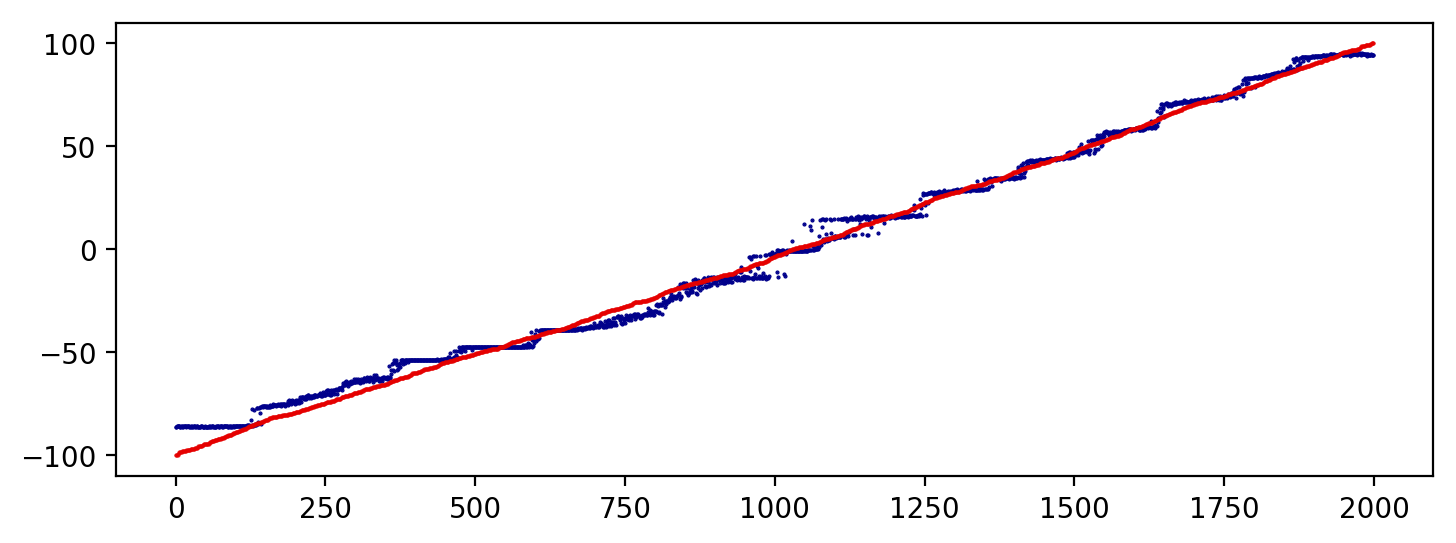

 epoch: 2350 testing_cost: 0.0012917347

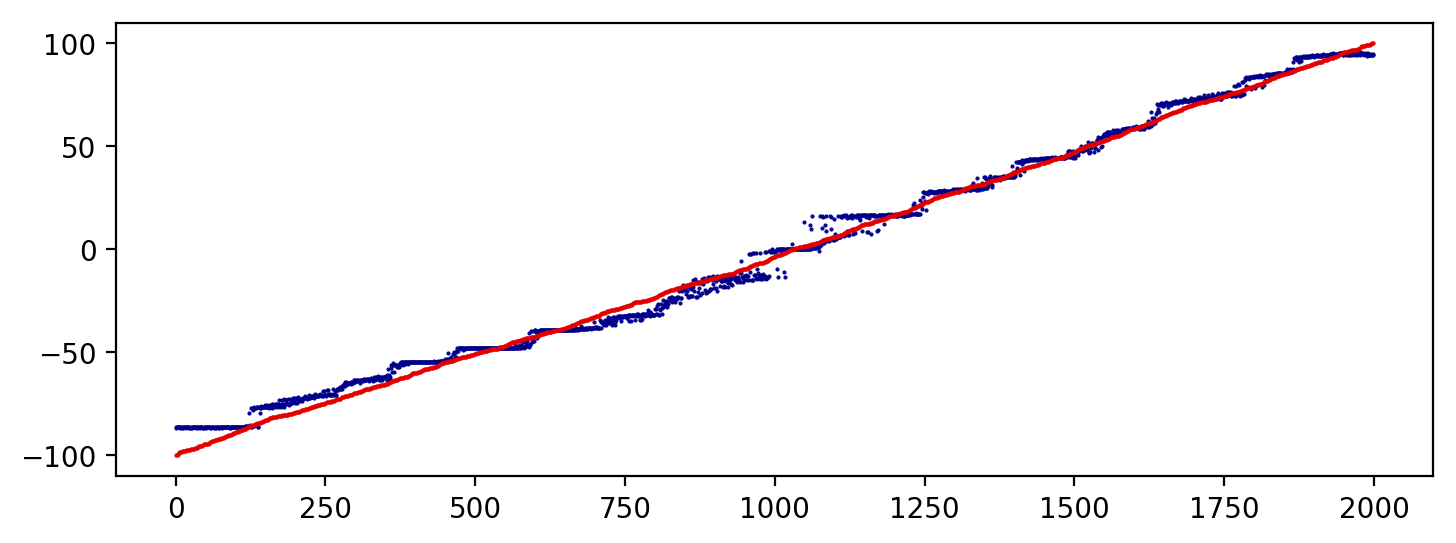

 epoch: 2400 testing_cost: 0.0011022505

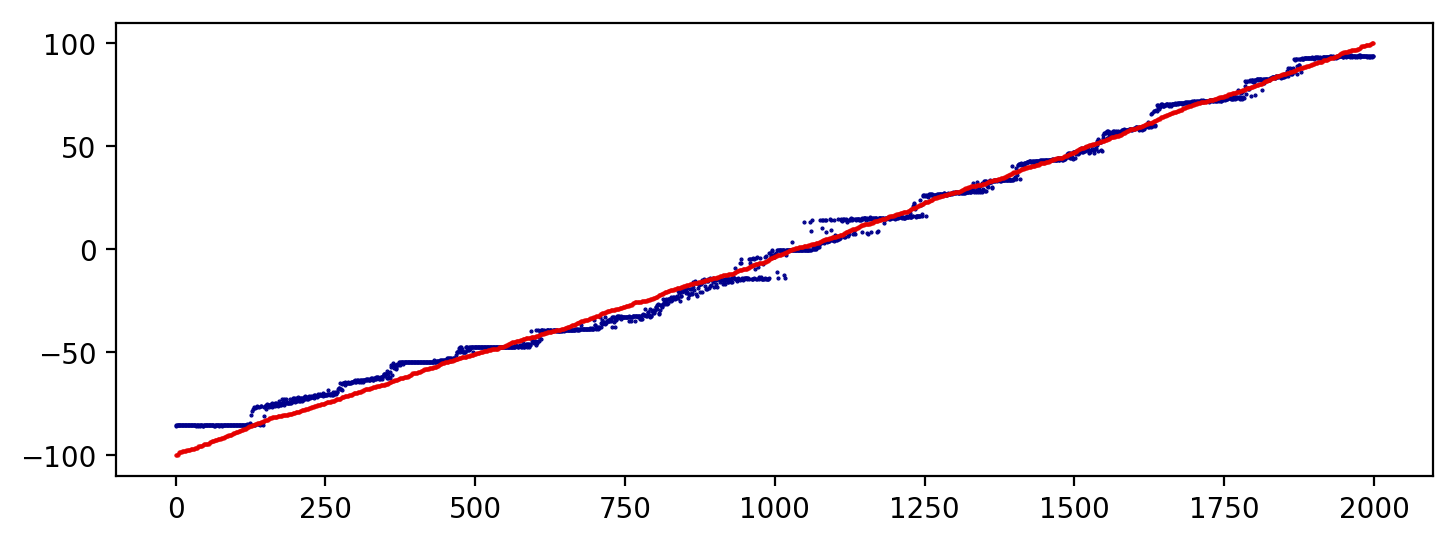

 epoch: 2450 testing_cost: 0.0011920565

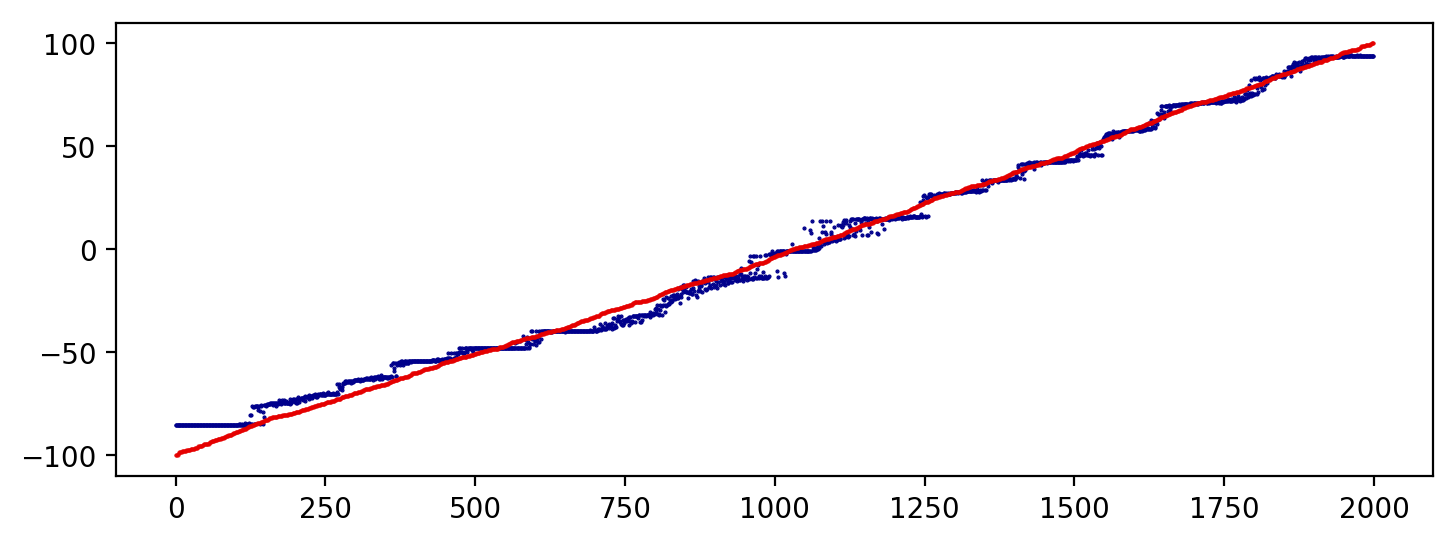

 epoch: 2500 testing_cost: 0.0013288705

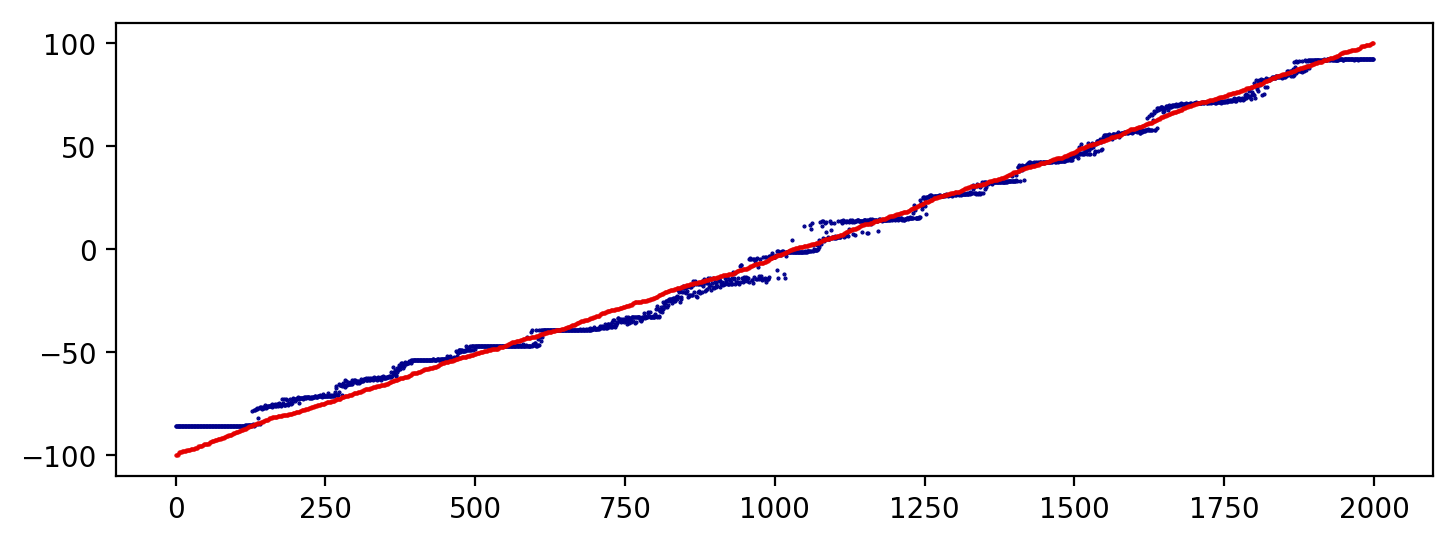

 epoch: 2550 testing_cost: 0.0014030481

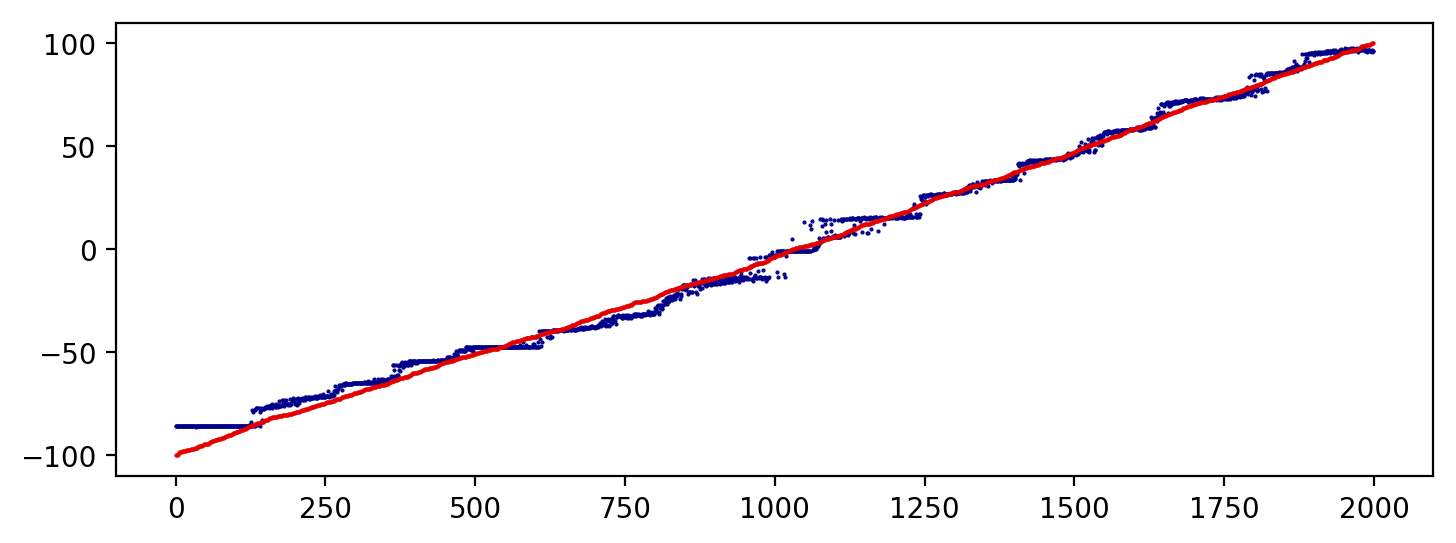

 epoch: 2600 testing_cost: 0.0010880517

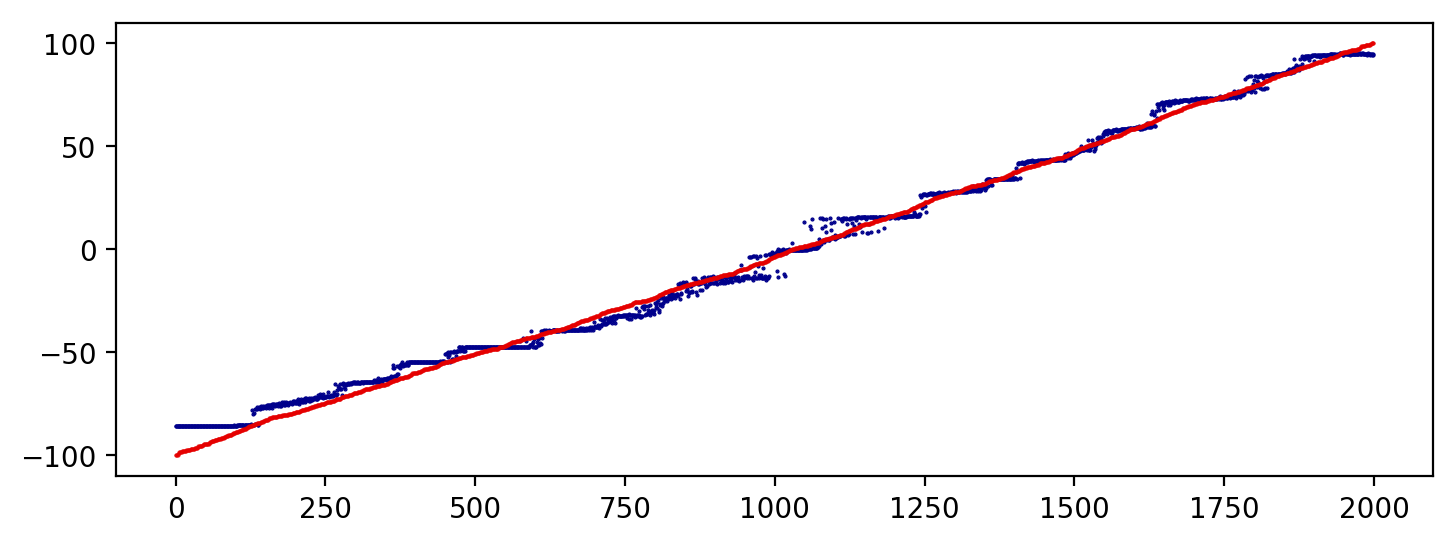

 epoch: 2650 testing_cost: 0.0018951781

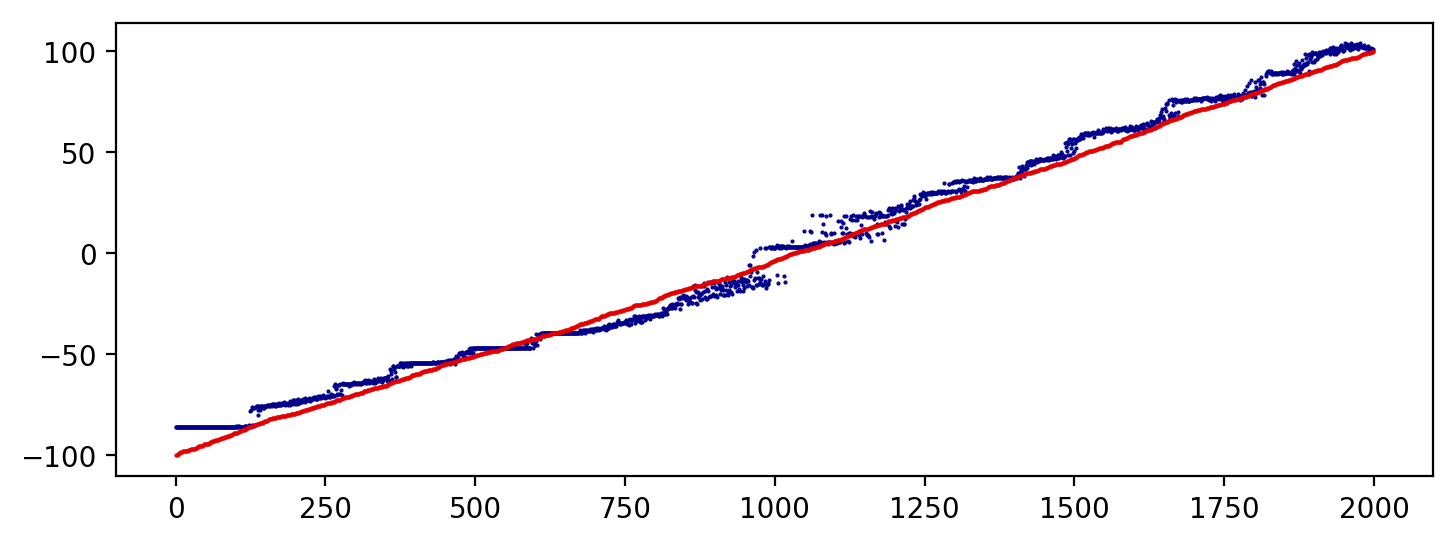

 epoch: 2700 testing_cost: 0.0019678115

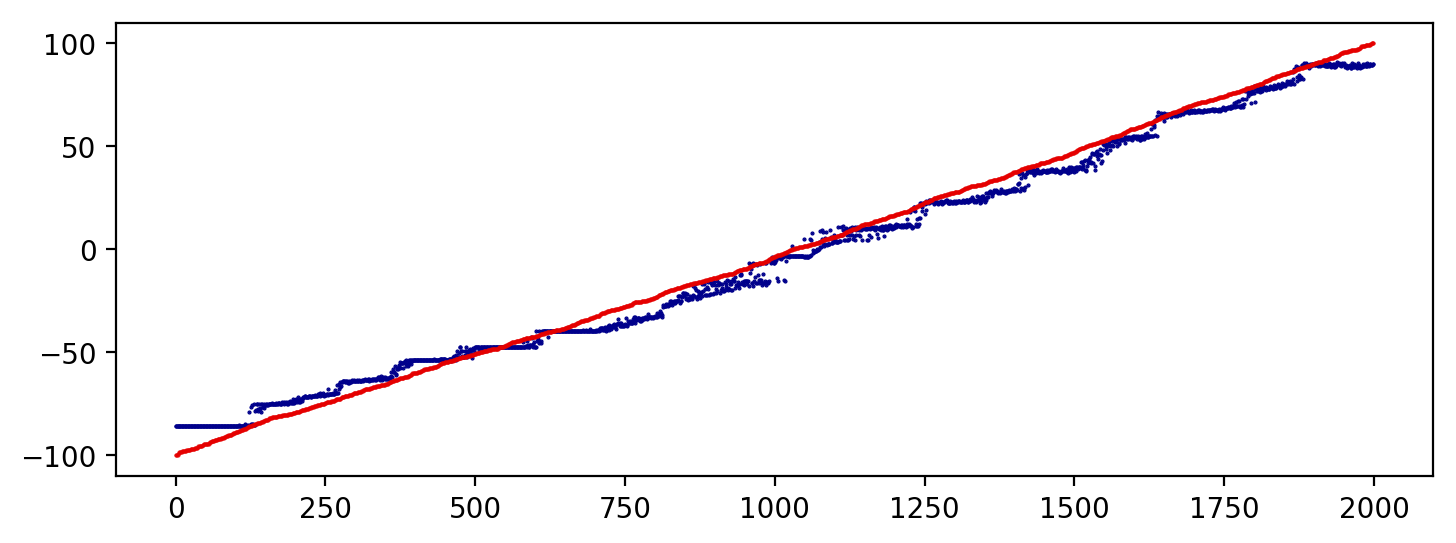

 epoch: 2750 testing_cost: 0.0033099693

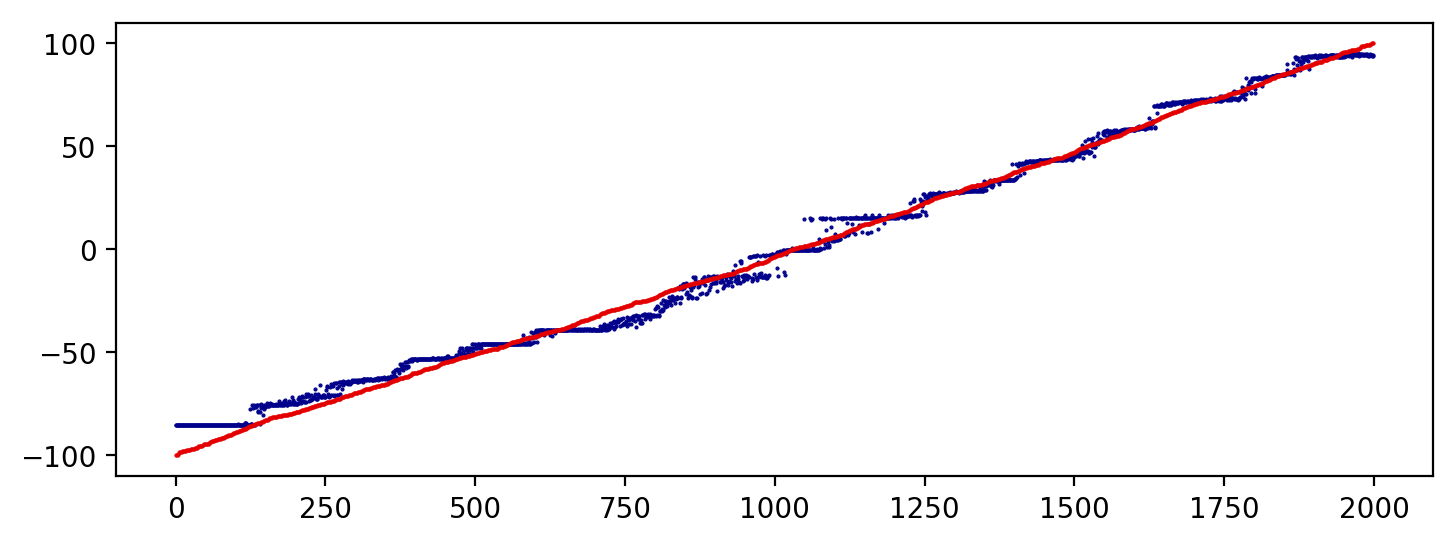

 epoch: 2800 testing_cost: 0.0013576202

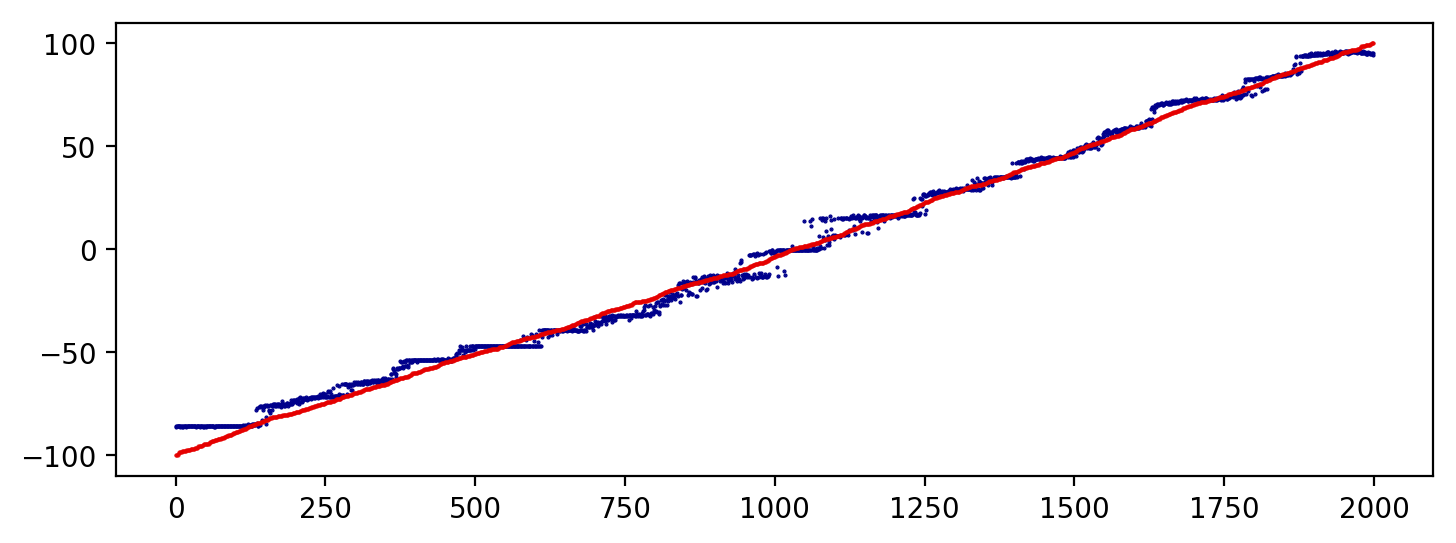

 epoch: 2850 testing_cost: 0.0011509390

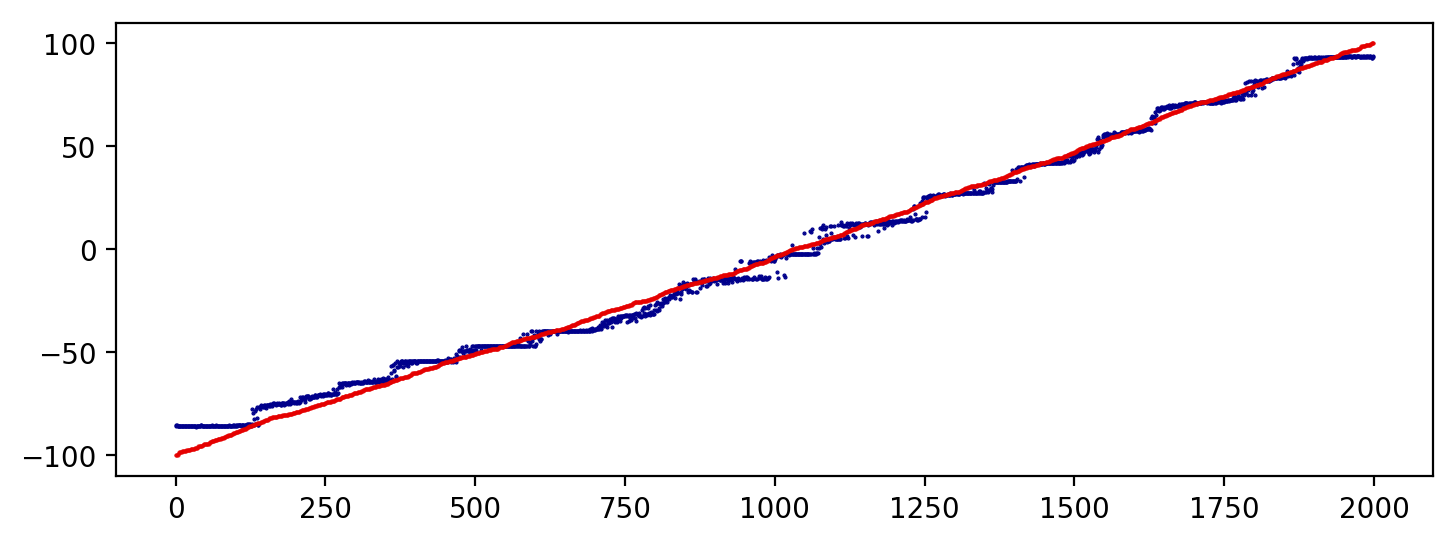

 epoch: 2900 testing_cost: 0.0010927613

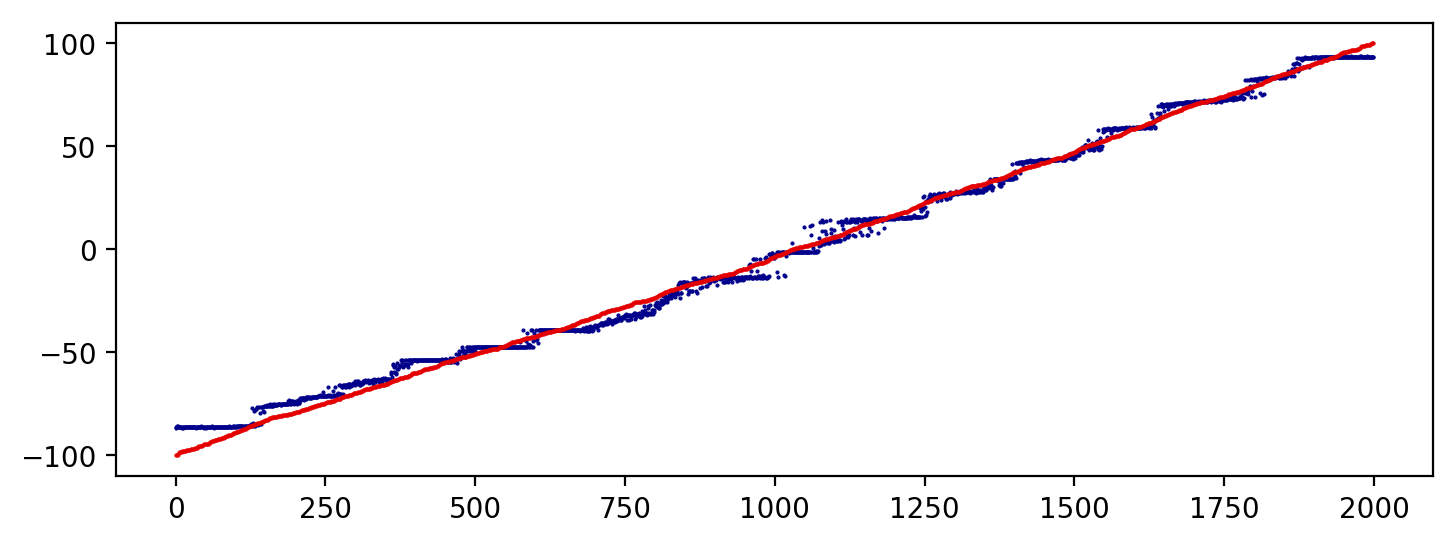

 epoch: 2950 testing_cost: 0.0016124452

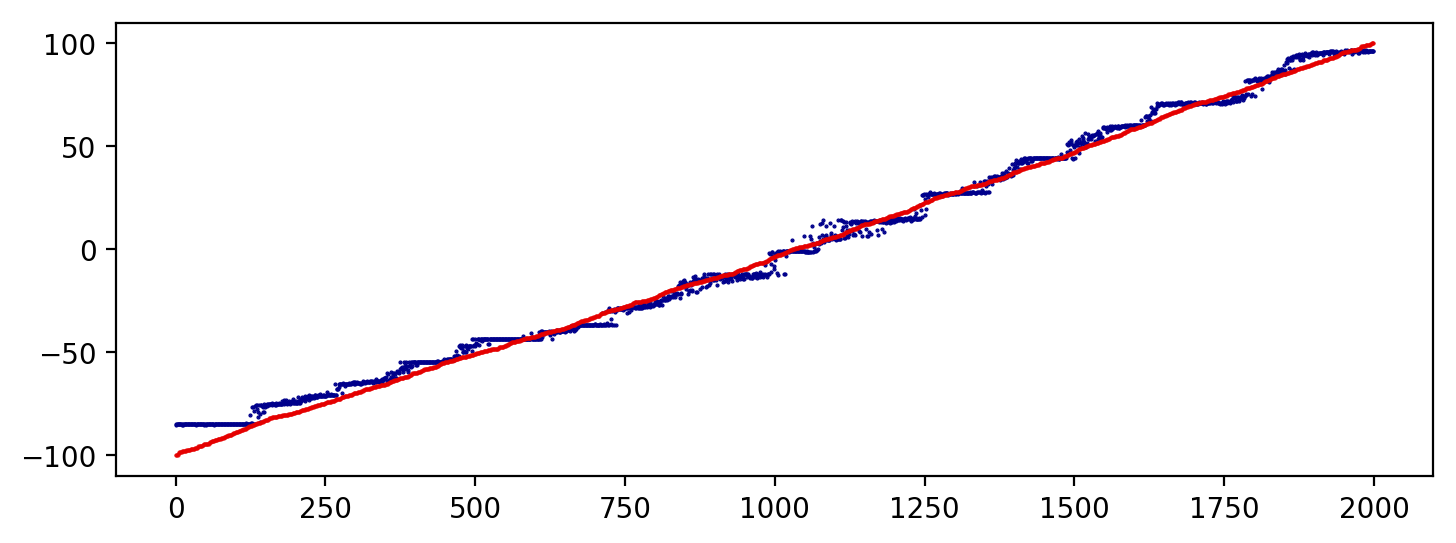

 epoch: 2999 testing_cost: 0.0020760081

In [14]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-1499')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 1*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [15]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.8638336968531796
2.4990975658085532


In [16]:
#import data
data_df = pd.read_csv('../../data/wrapped_10000_gaussian_spikes_five_percent_C.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/517631/trained_model.ckpt-2999
 epoch: 3000 testing_cost: 0.0023867411

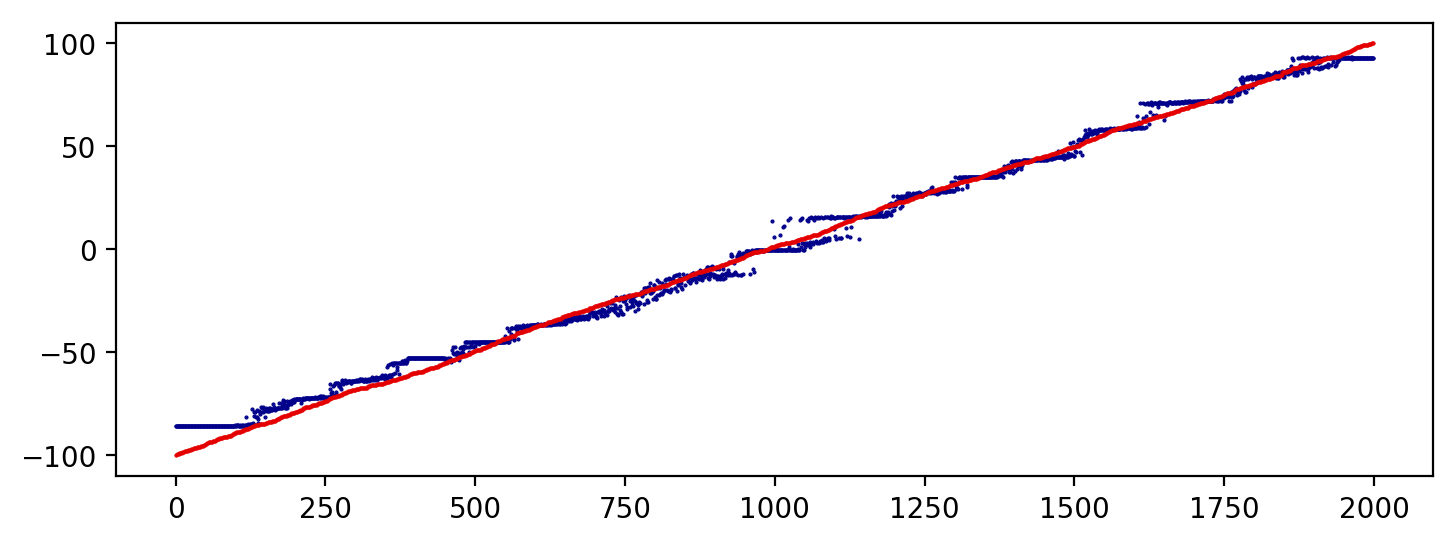

 epoch: 3050 testing_cost: 0.0015228676

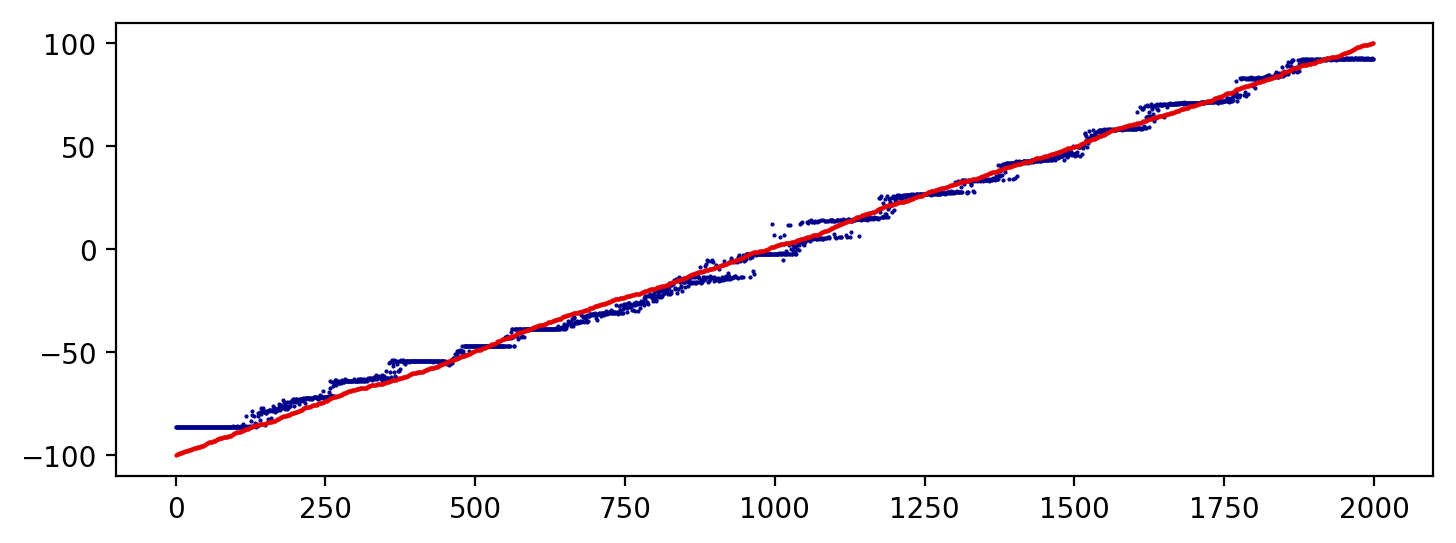

 epoch: 3100 testing_cost: 0.0011409089

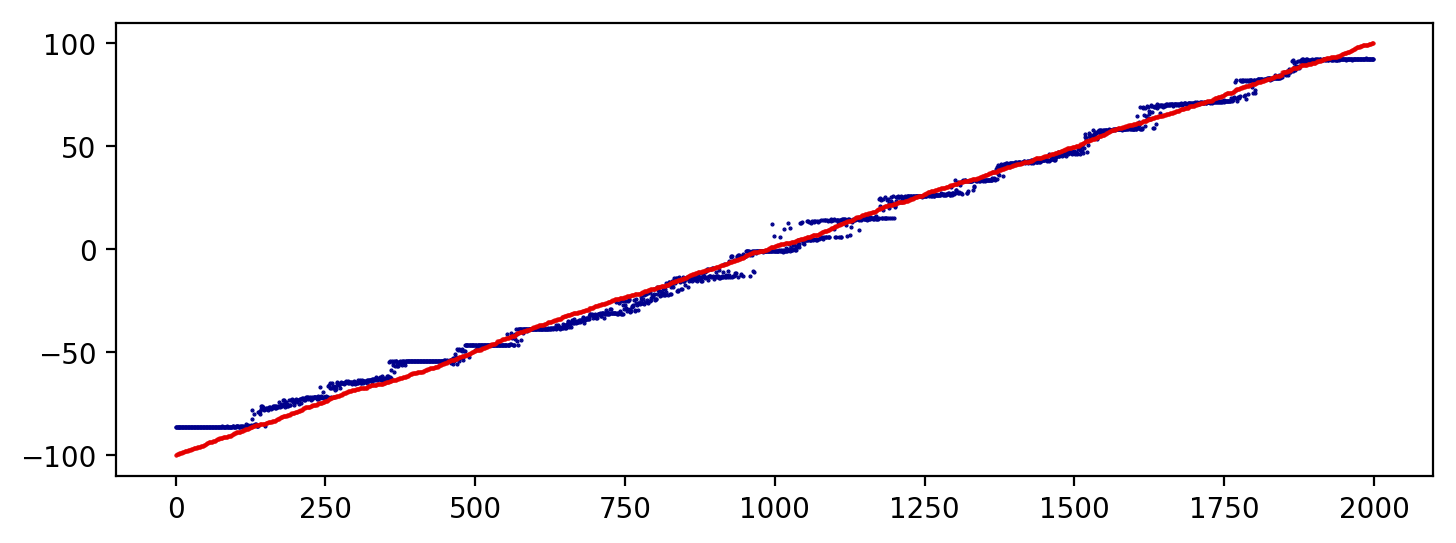

 epoch: 3150 testing_cost: 0.0014139618

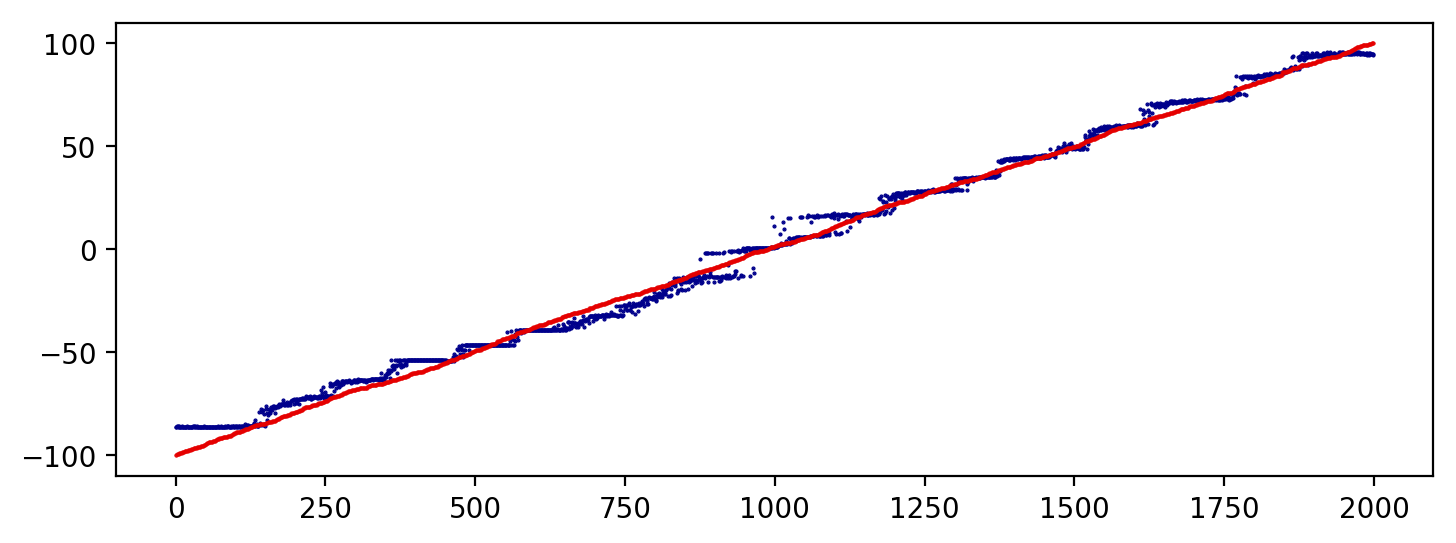

 epoch: 3200 testing_cost: 0.0013468777

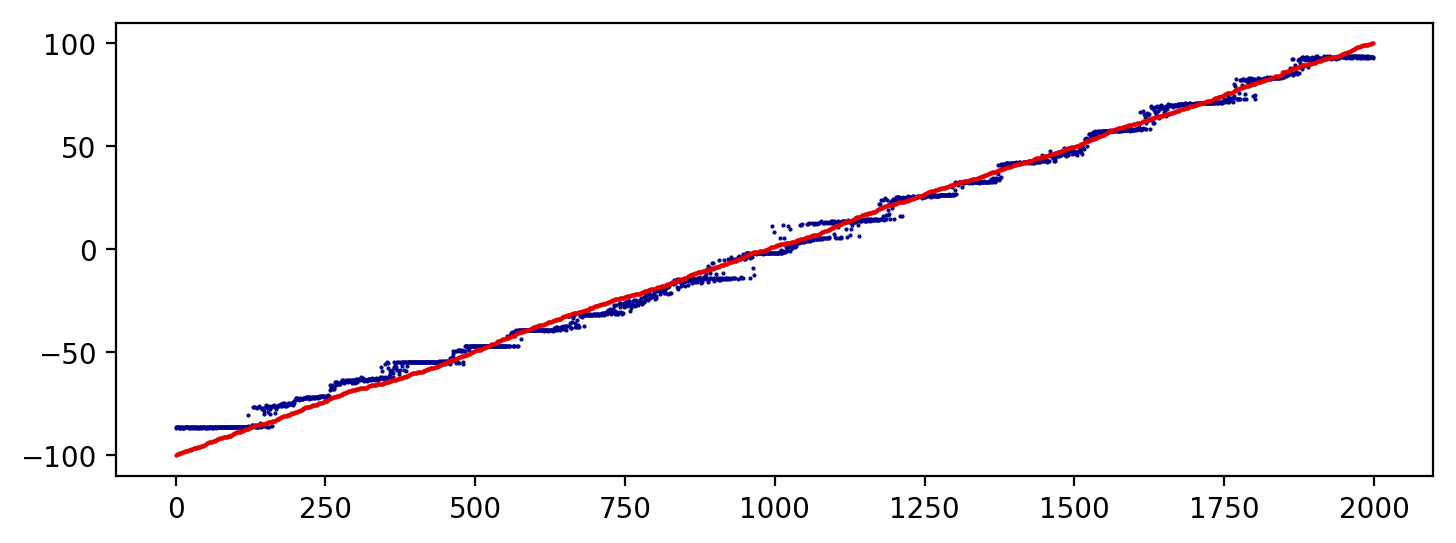

 epoch: 3250 testing_cost: 0.0022020892

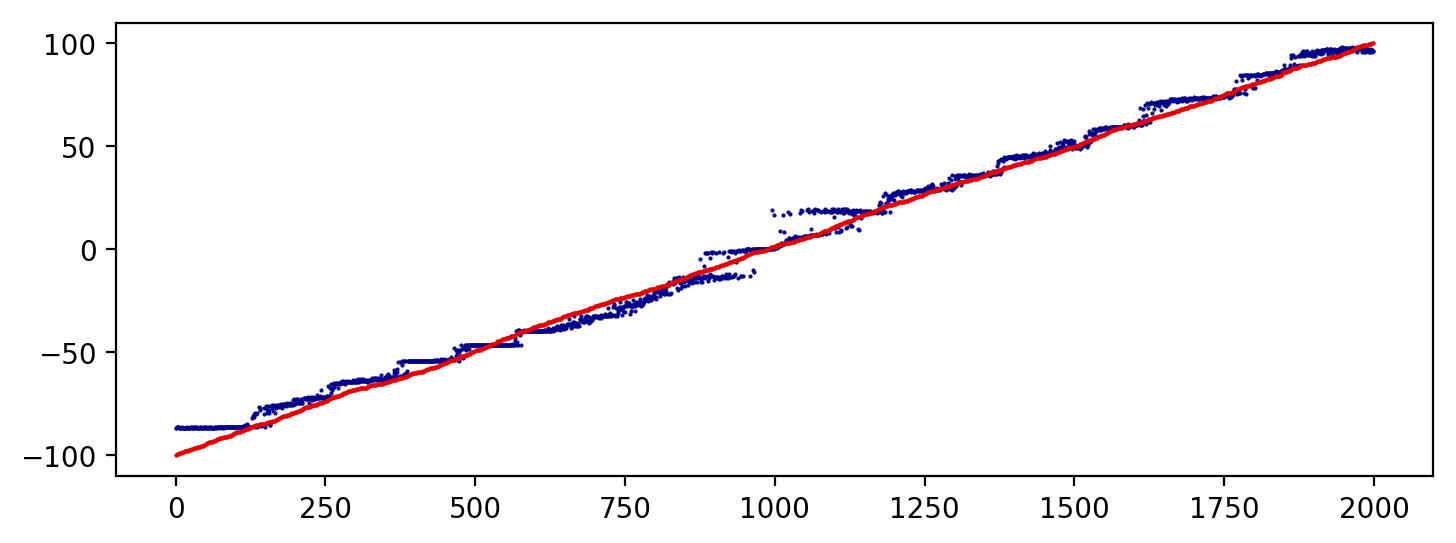

 epoch: 3300 testing_cost: 0.0014870665

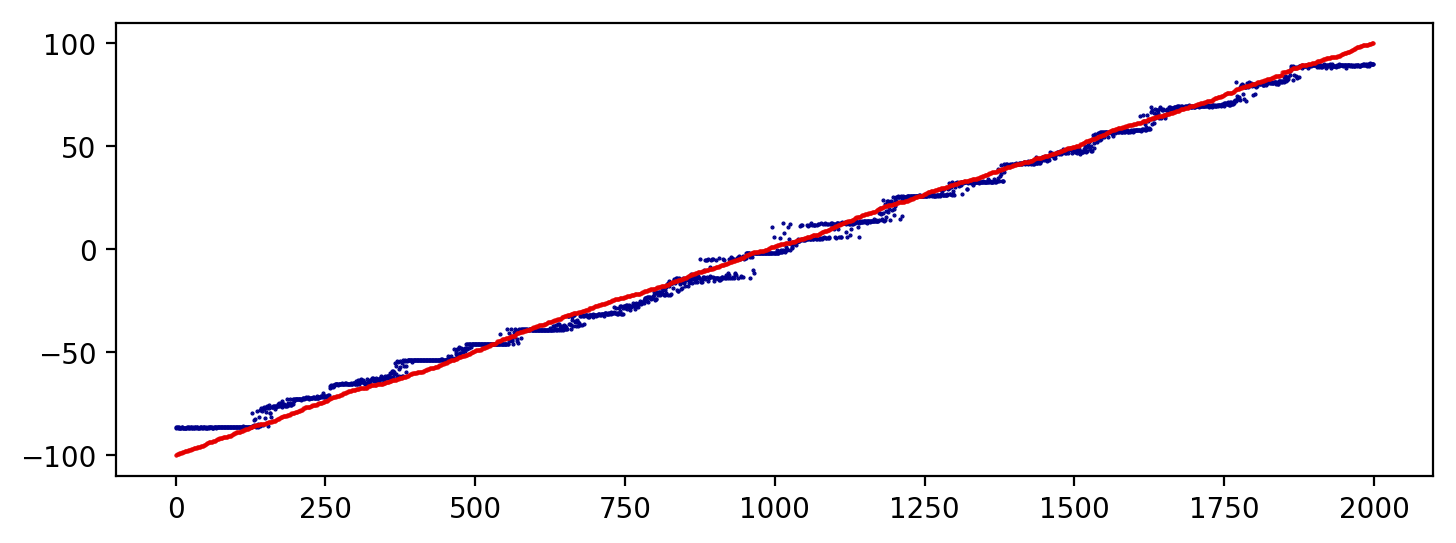

 epoch: 3350 testing_cost: 0.0010539958

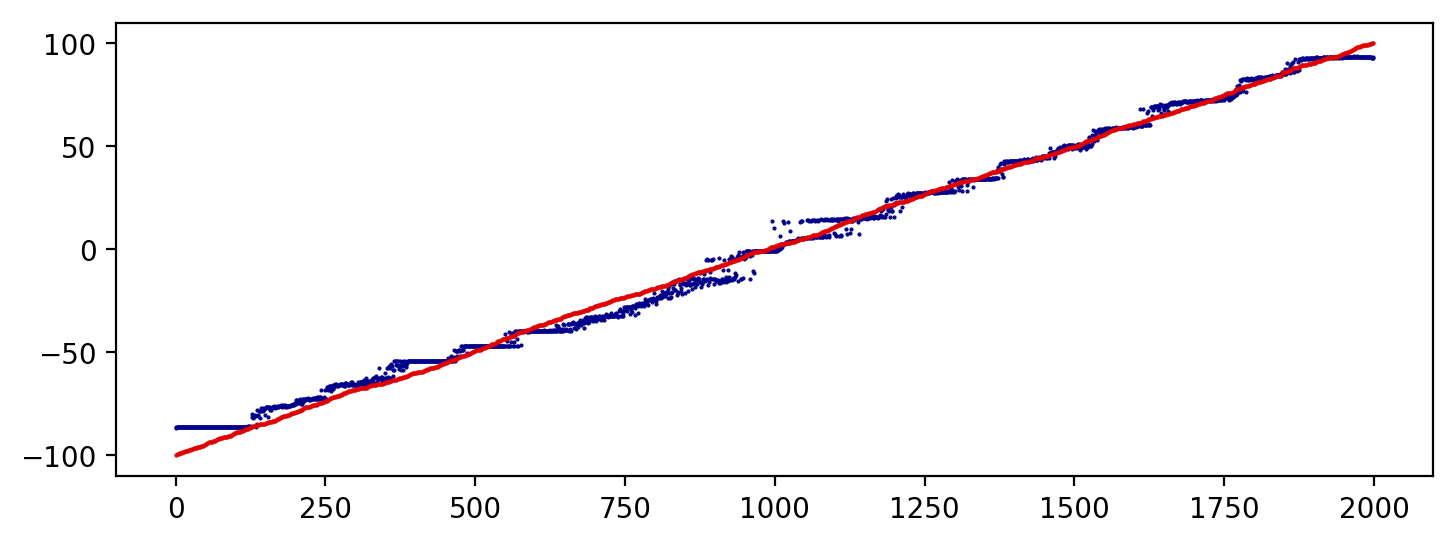

 epoch: 3400 testing_cost: 0.0011868055

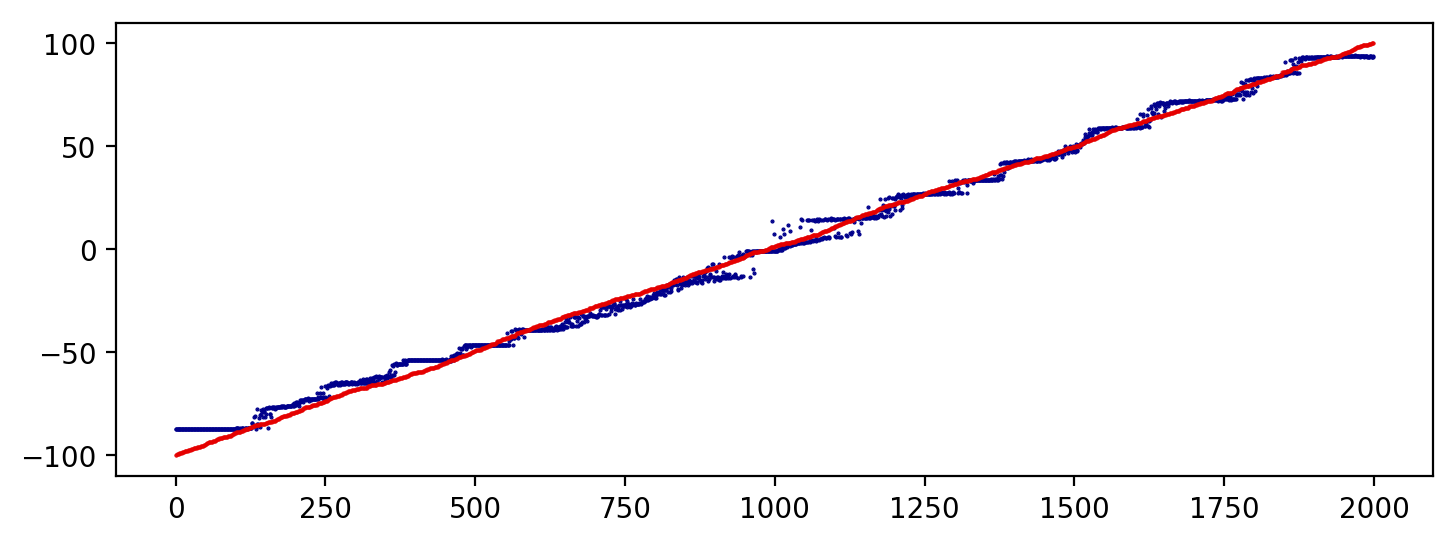

 epoch: 3450 testing_cost: 0.0018003498

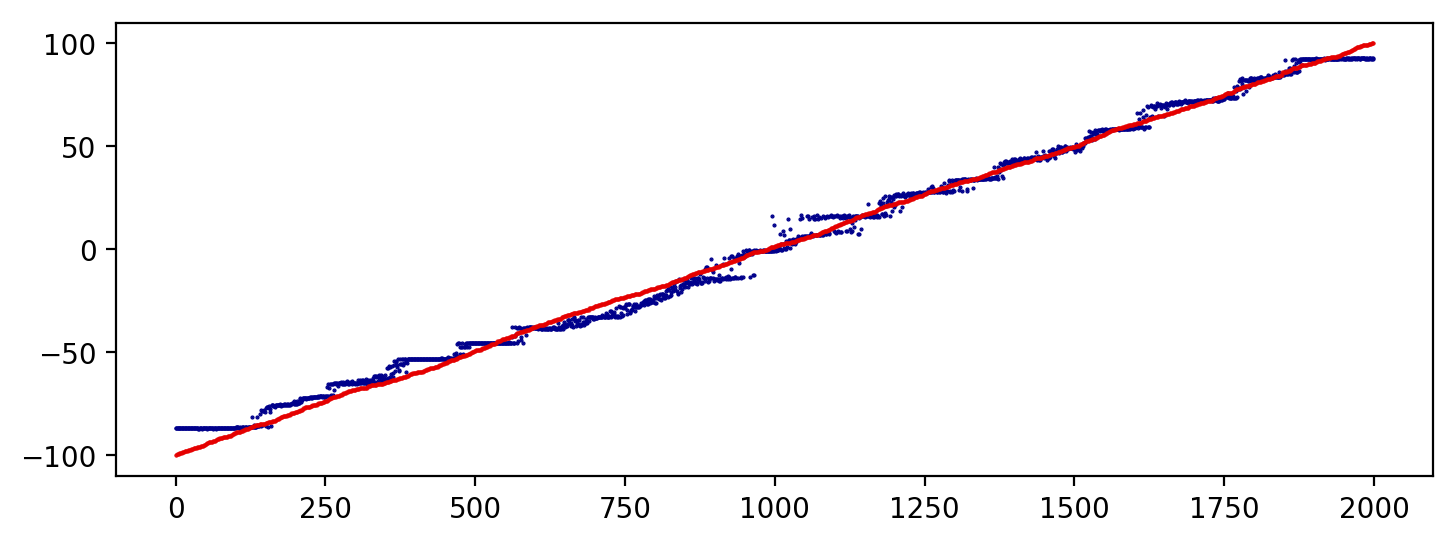

 epoch: 3500 testing_cost: 0.0015177178

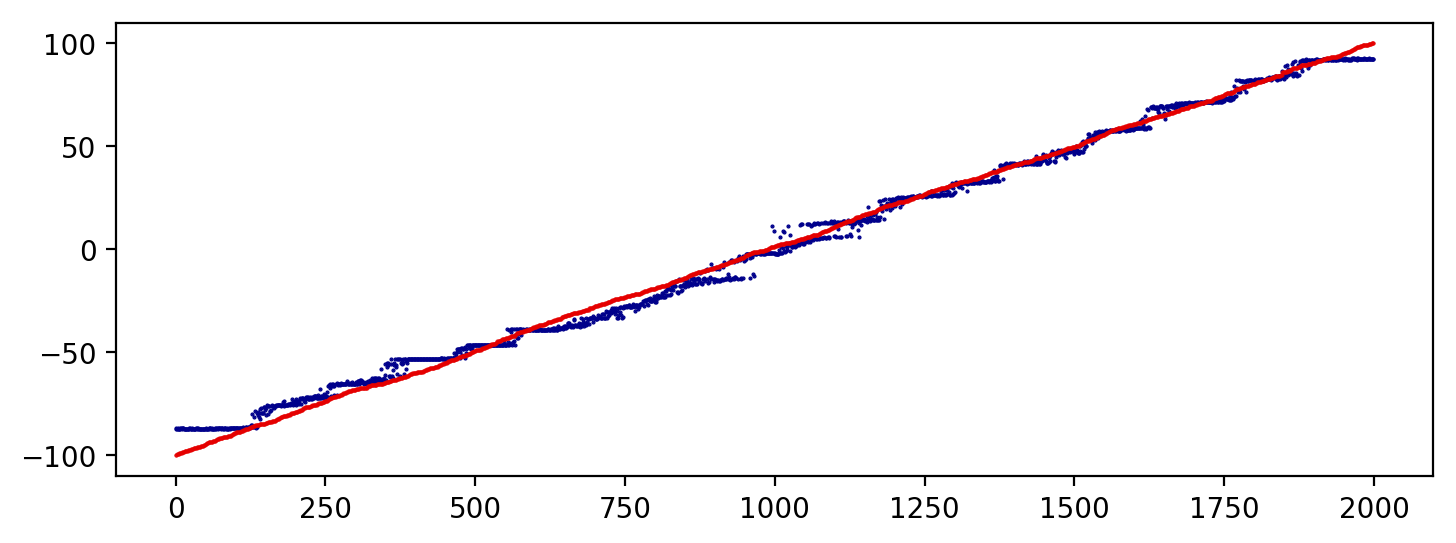

 epoch: 3550 testing_cost: 0.0012498221

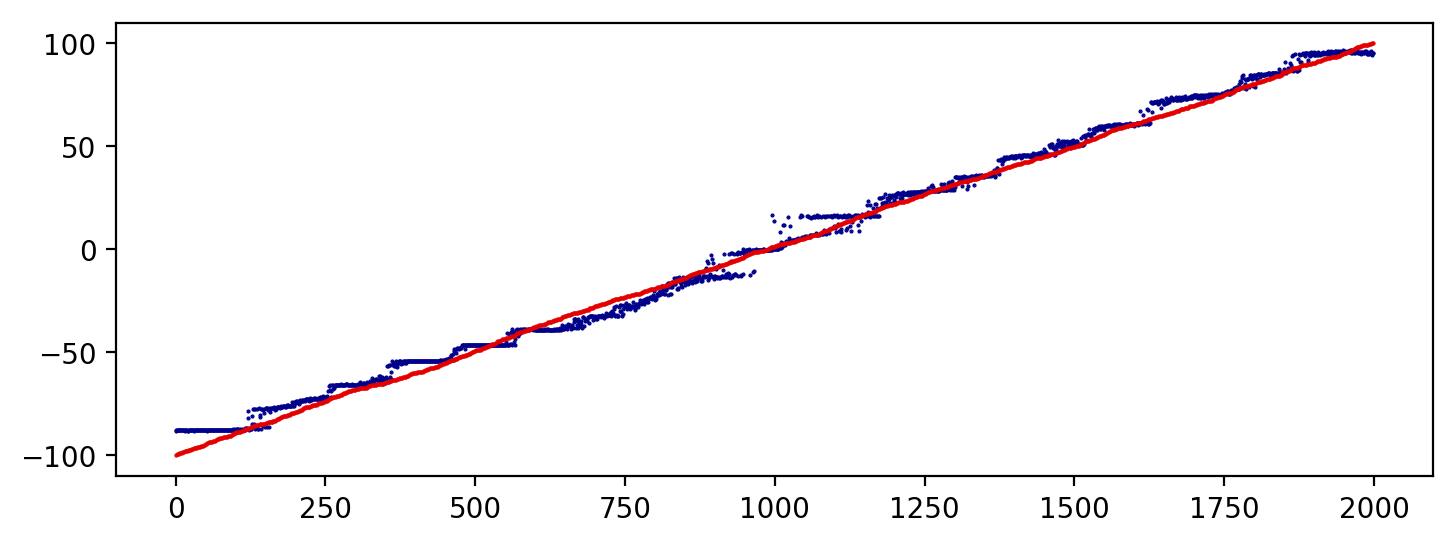

 epoch: 3600 testing_cost: 0.0011562075

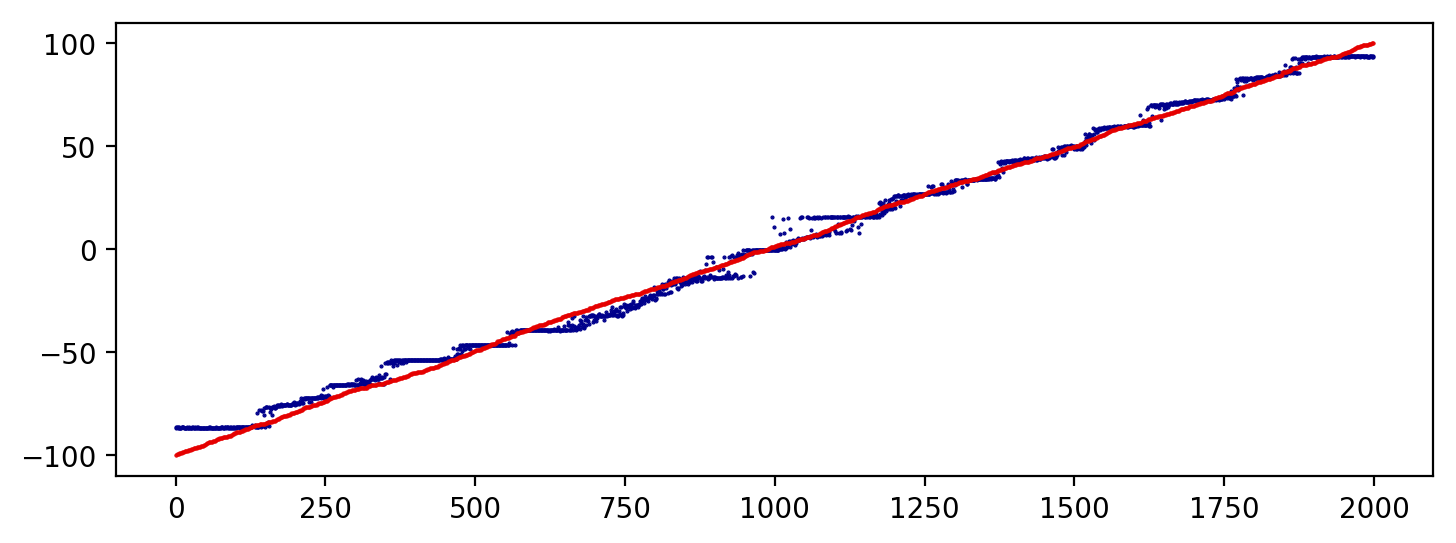

 epoch: 3650 testing_cost: 0.0010694416

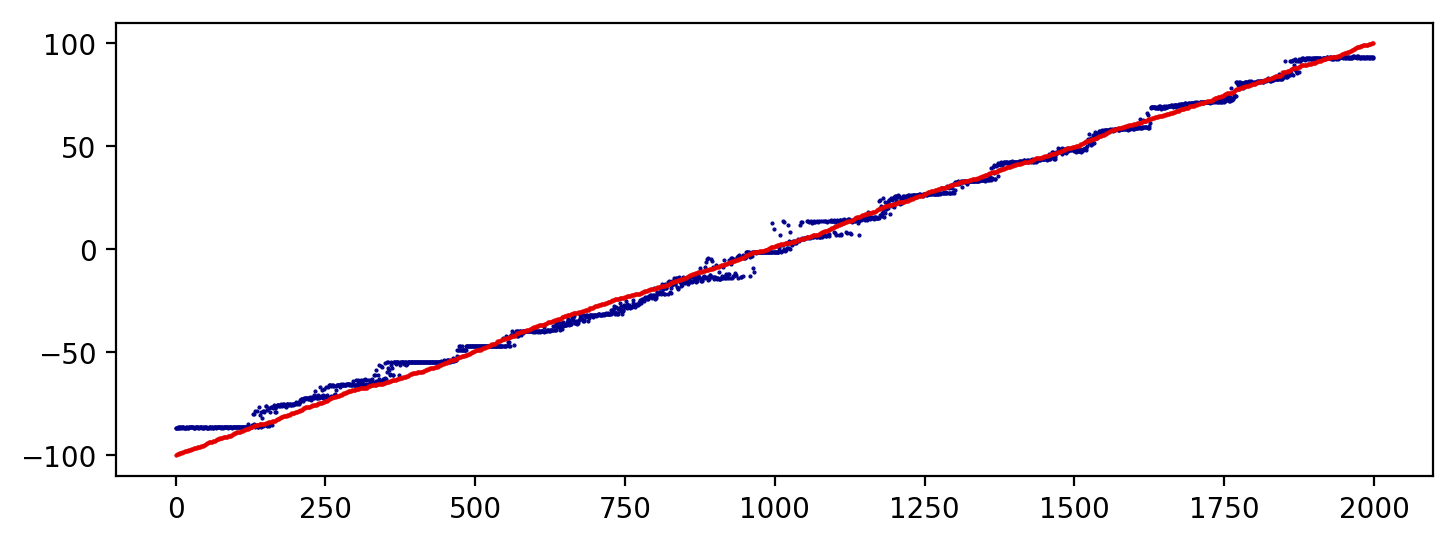

 epoch: 3700 testing_cost: 0.0010538482

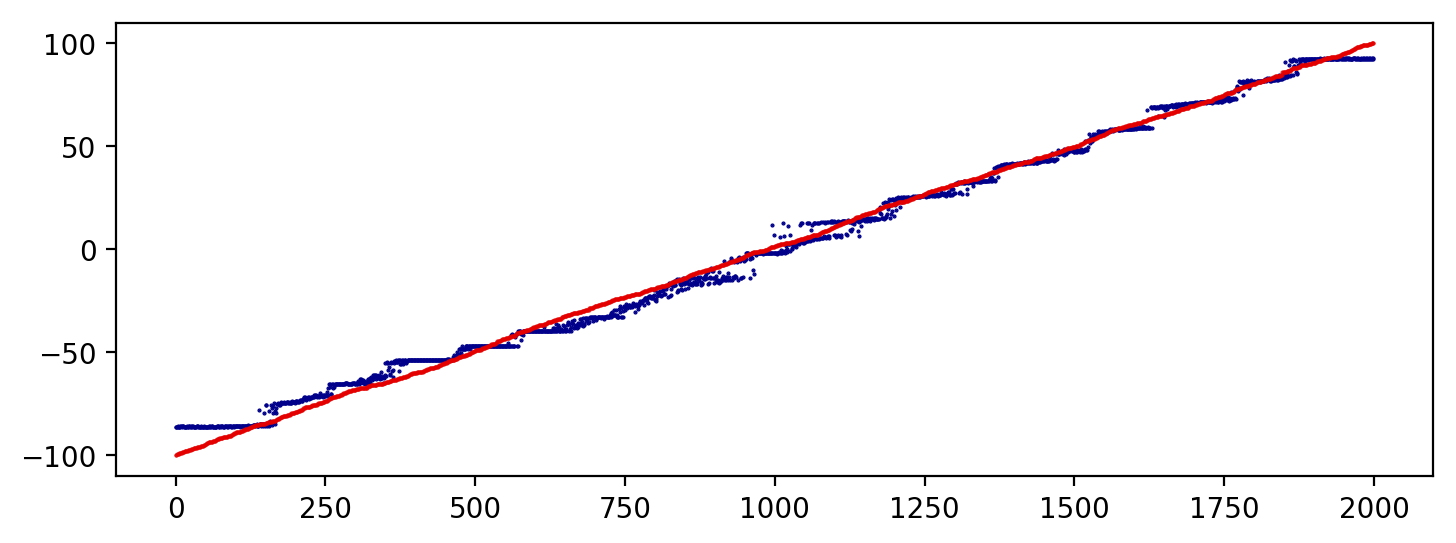

 epoch: 3750 testing_cost: 0.0014741800

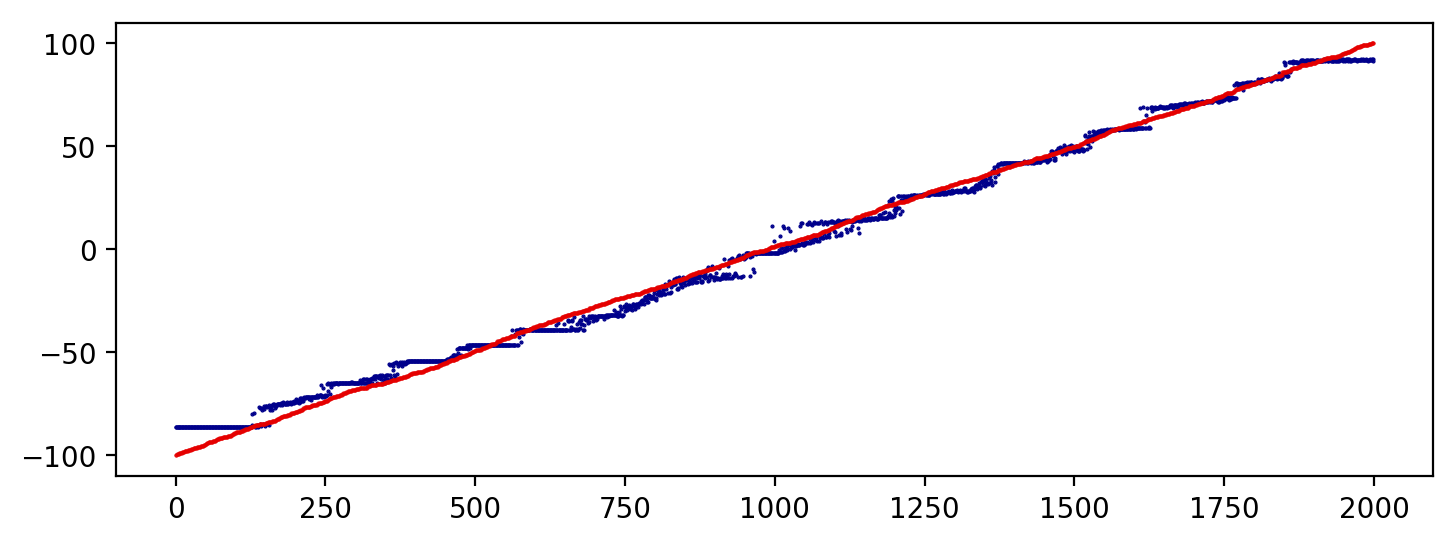

 epoch: 3800 testing_cost: 0.0015949376

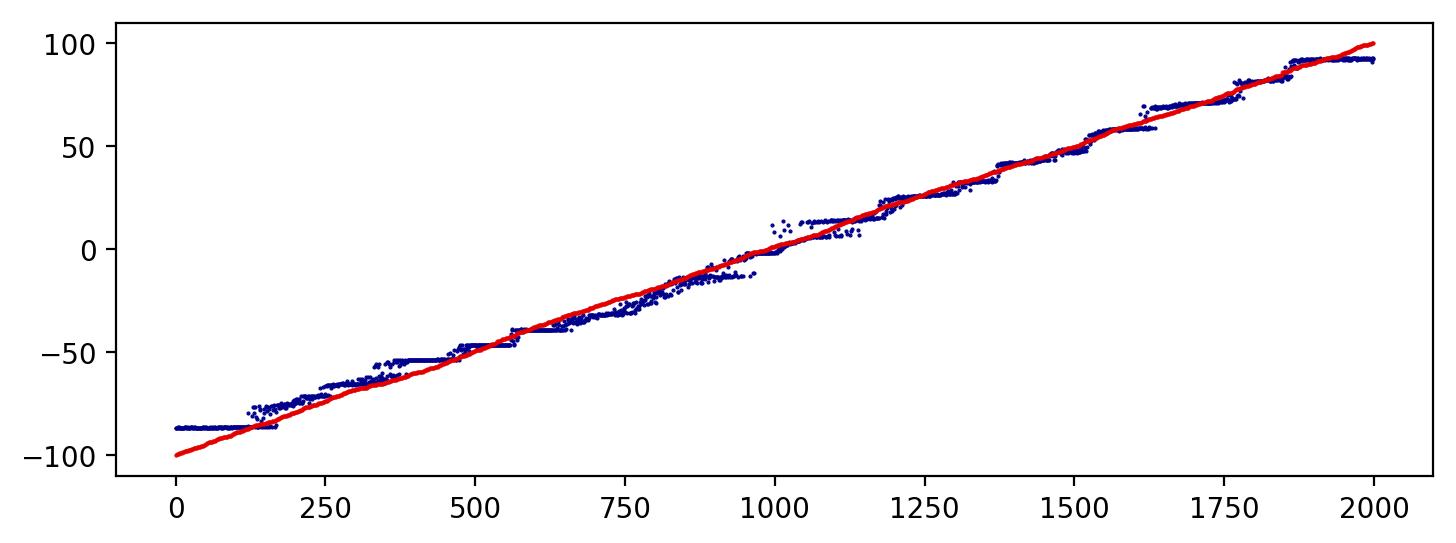

 epoch: 3850 testing_cost: 0.0013144005

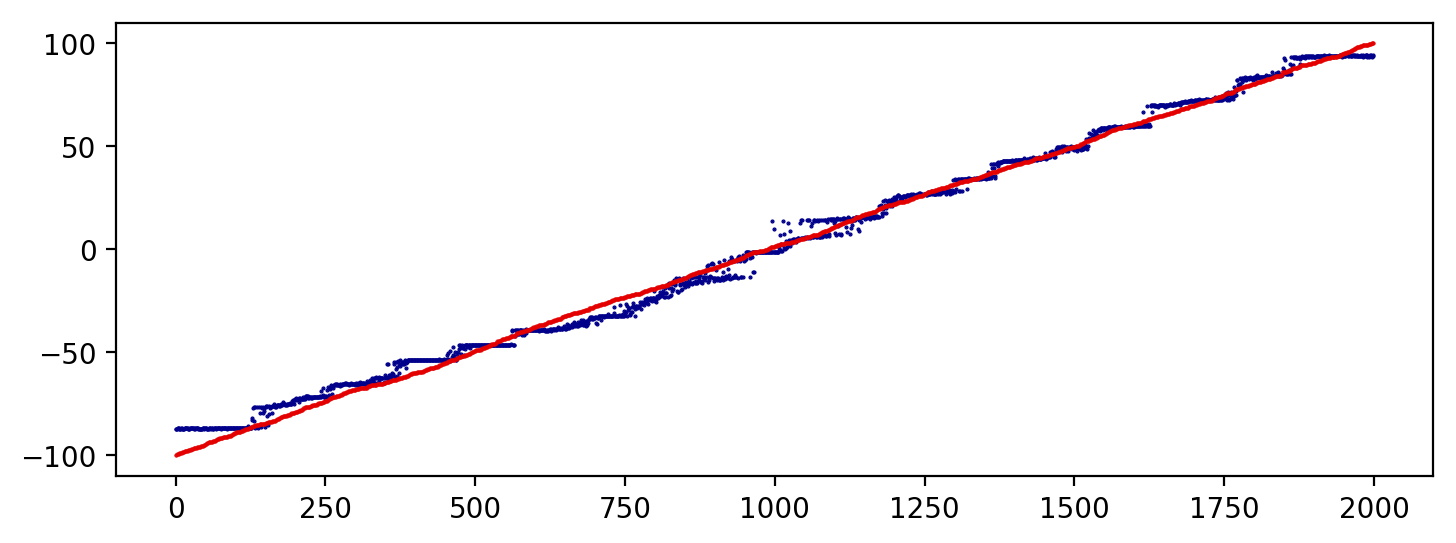

 epoch: 3900 testing_cost: 0.0015799061

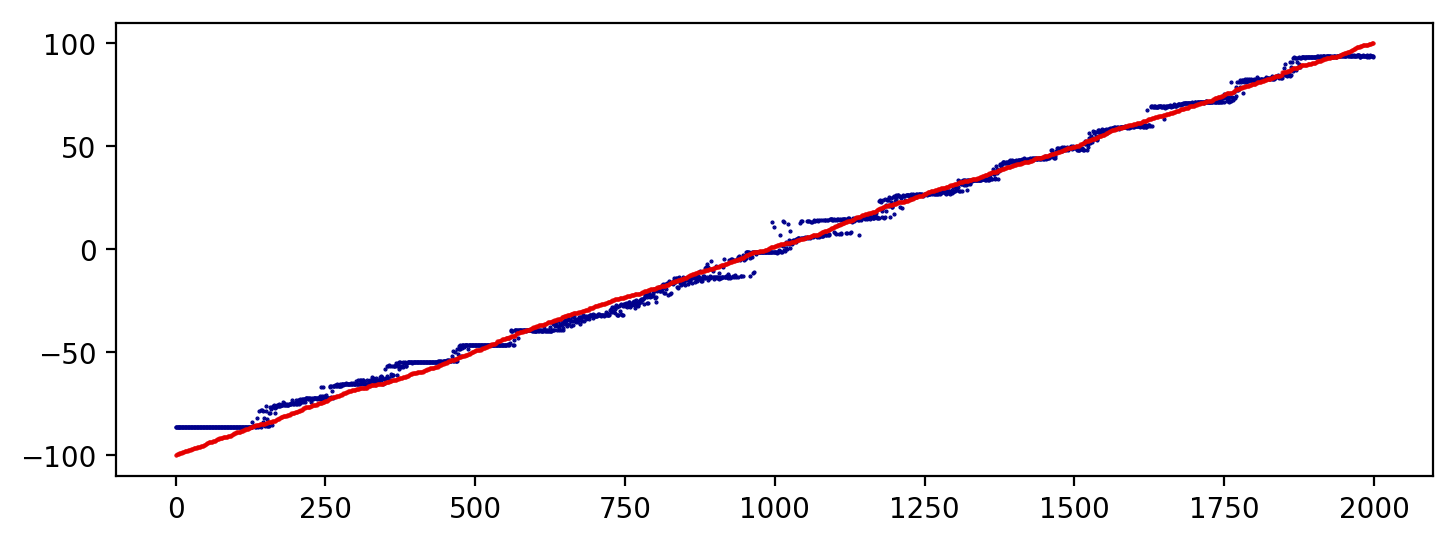

 epoch: 3950 testing_cost: 0.0017917473

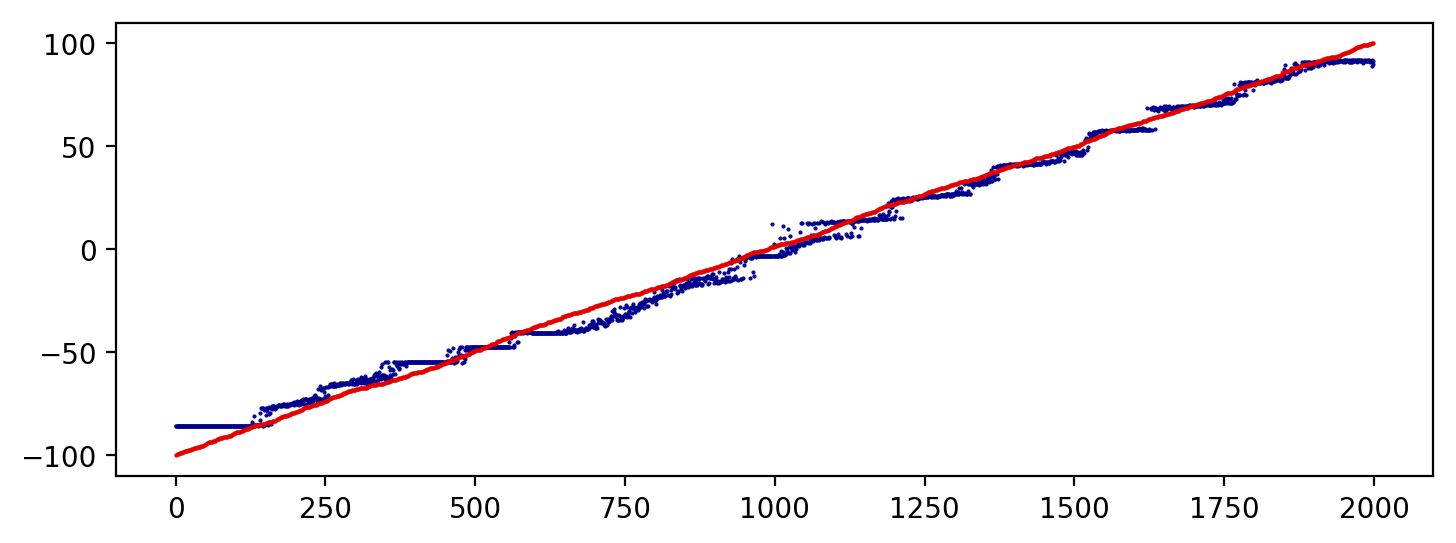

 epoch: 4000 testing_cost: 0.0012513222

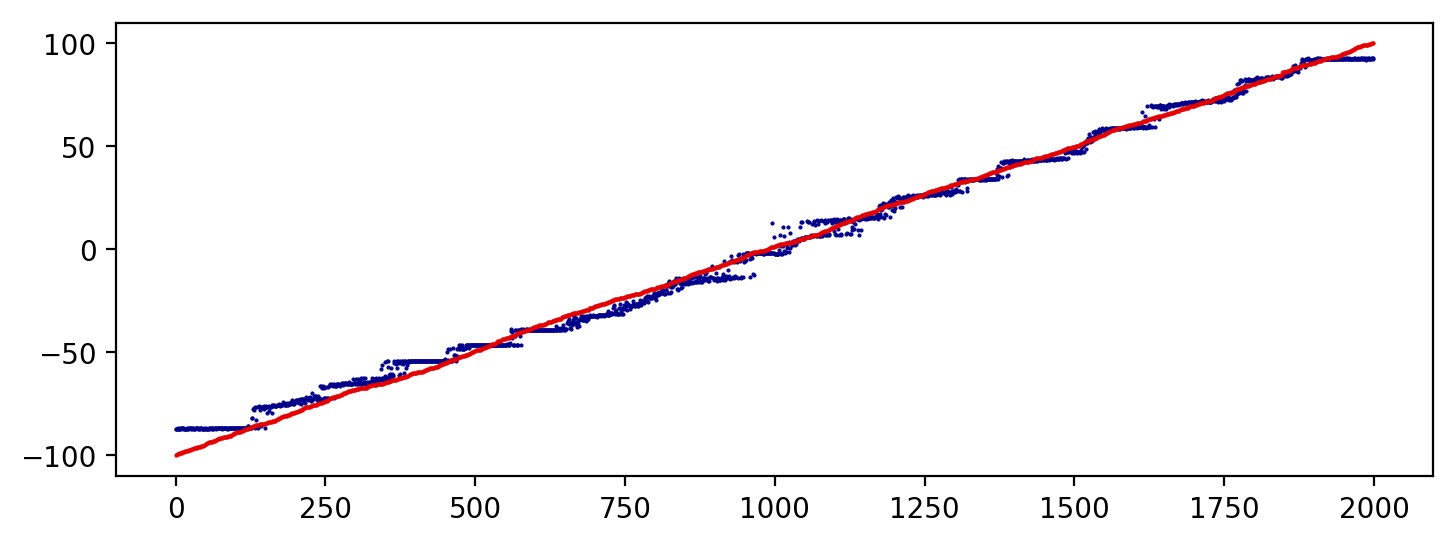

 epoch: 4050 testing_cost: 0.0011748831

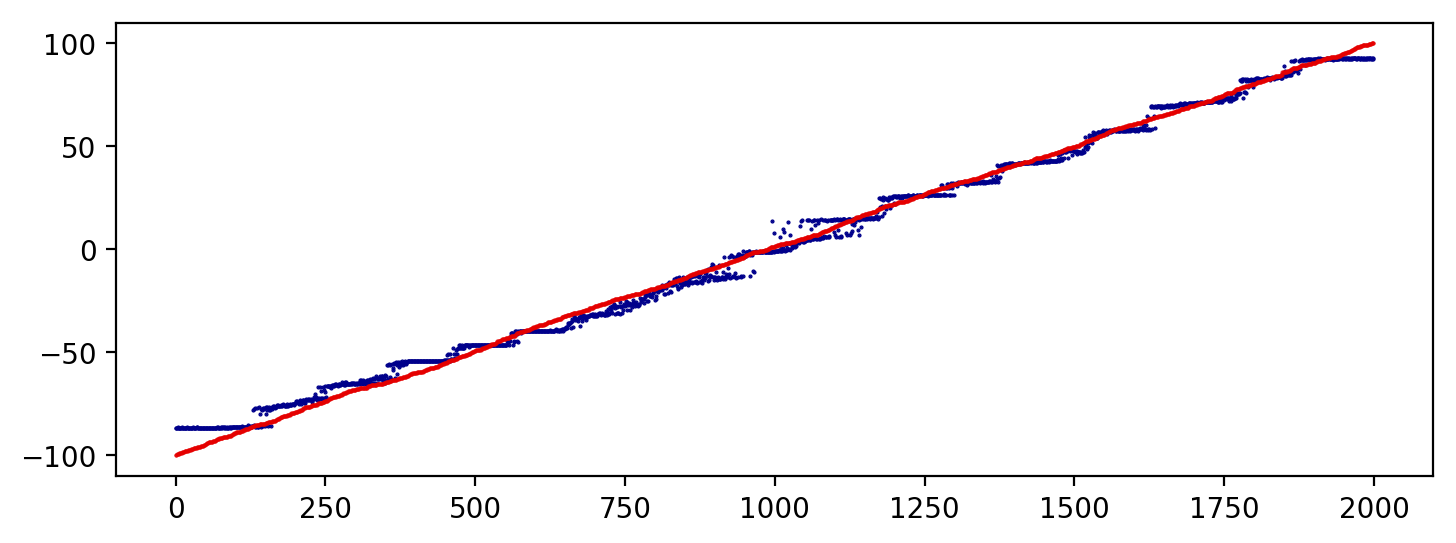

 epoch: 4100 testing_cost: 0.0014712882

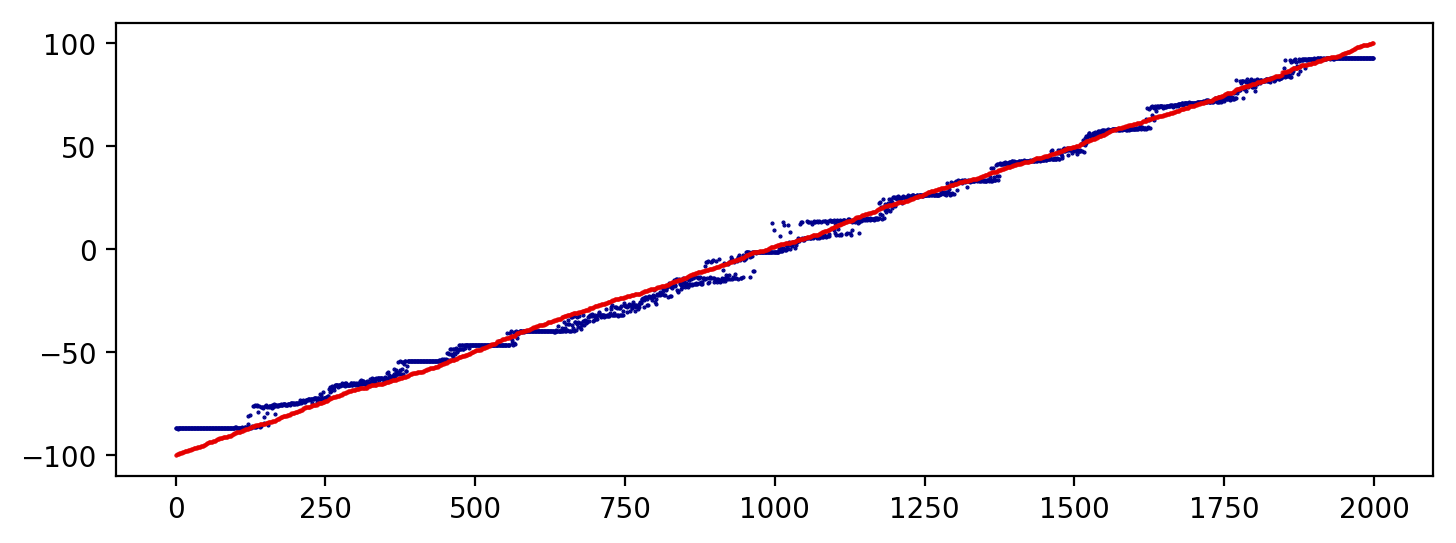

 epoch: 4150 testing_cost: 0.0012781260

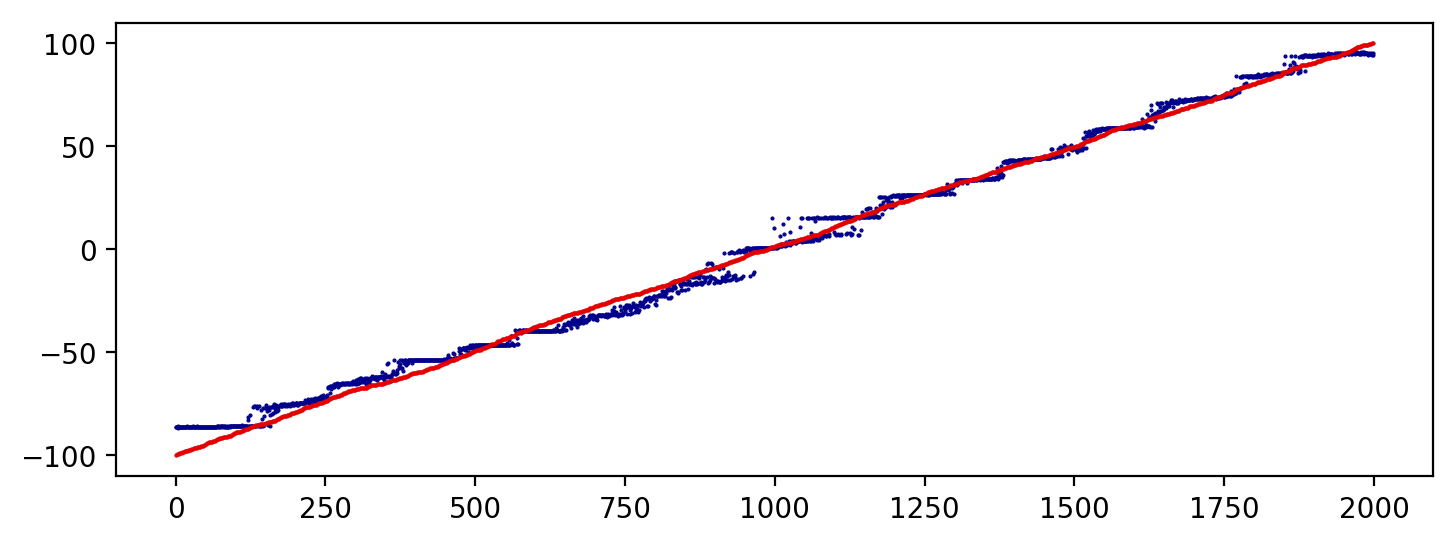

 epoch: 4200 testing_cost: 0.0012013618

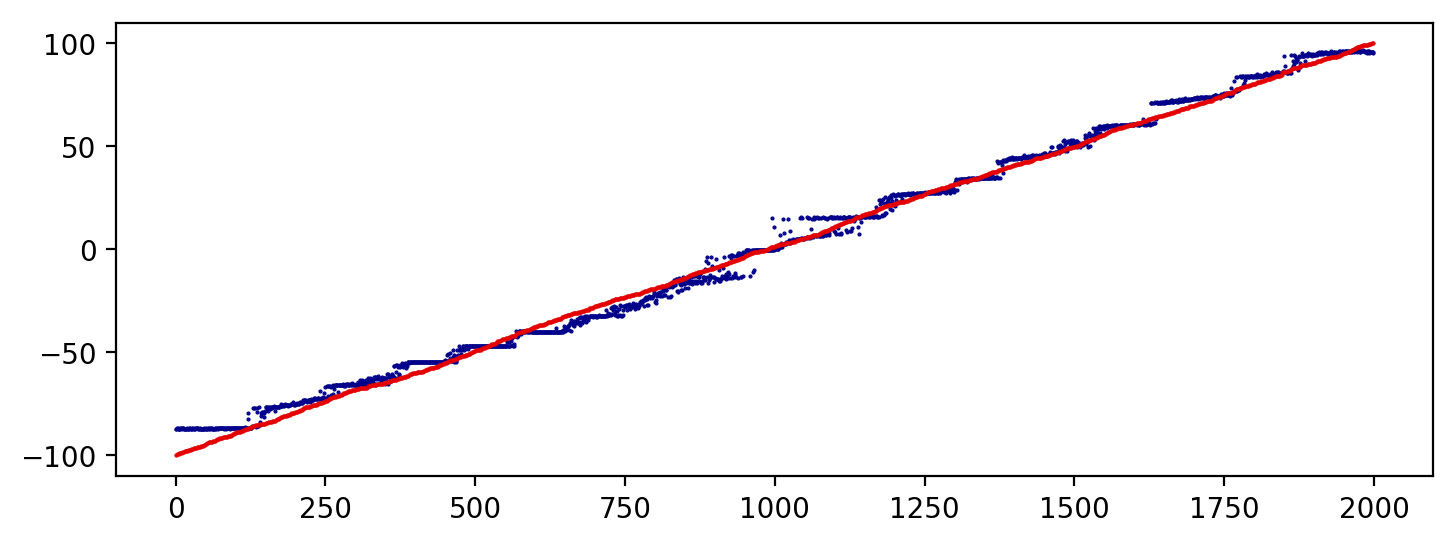

 epoch: 4250 testing_cost: 0.0030219234

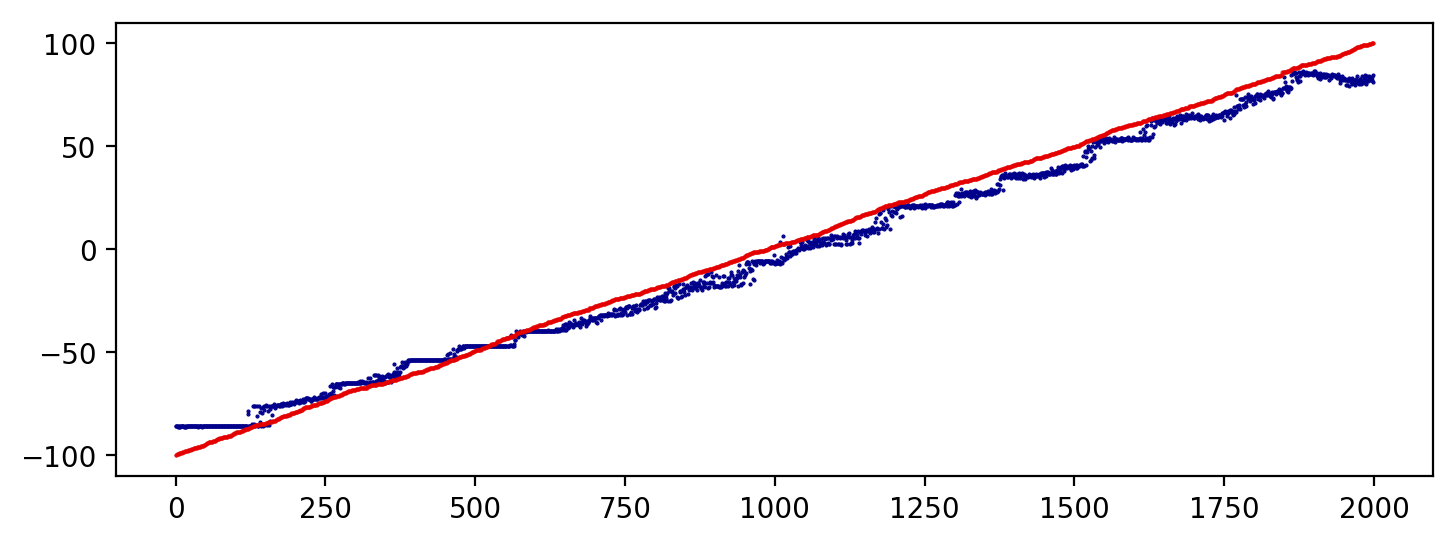

 epoch: 4300 testing_cost: 0.0012759903

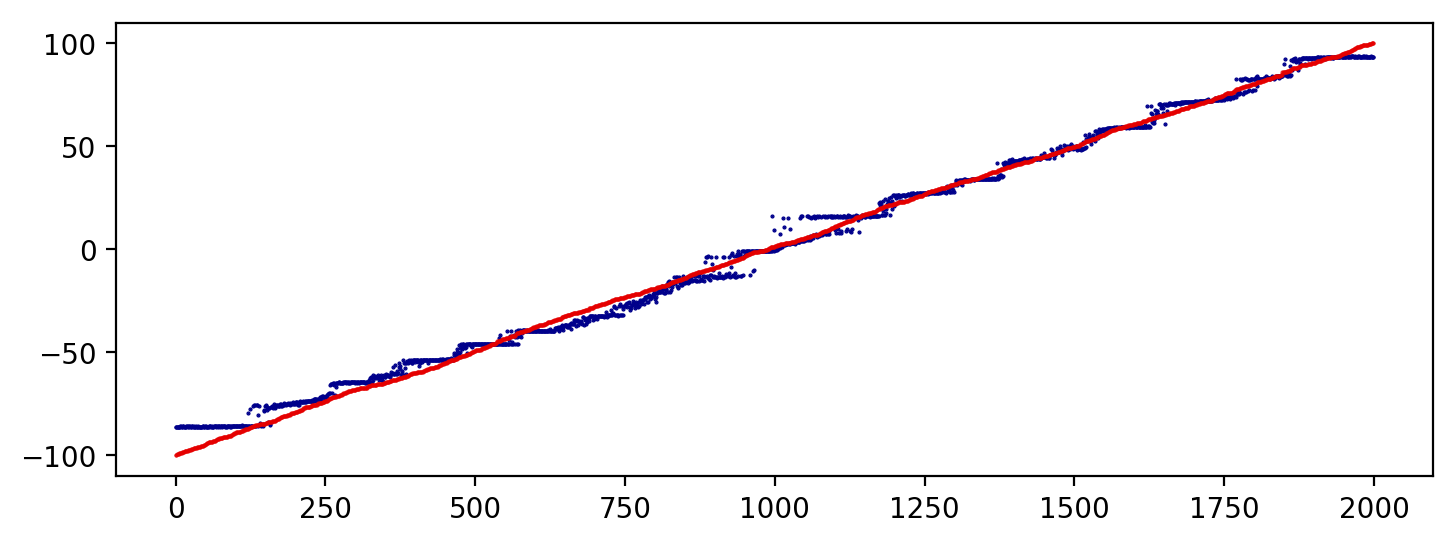

 epoch: 4350 testing_cost: 0.0010881149

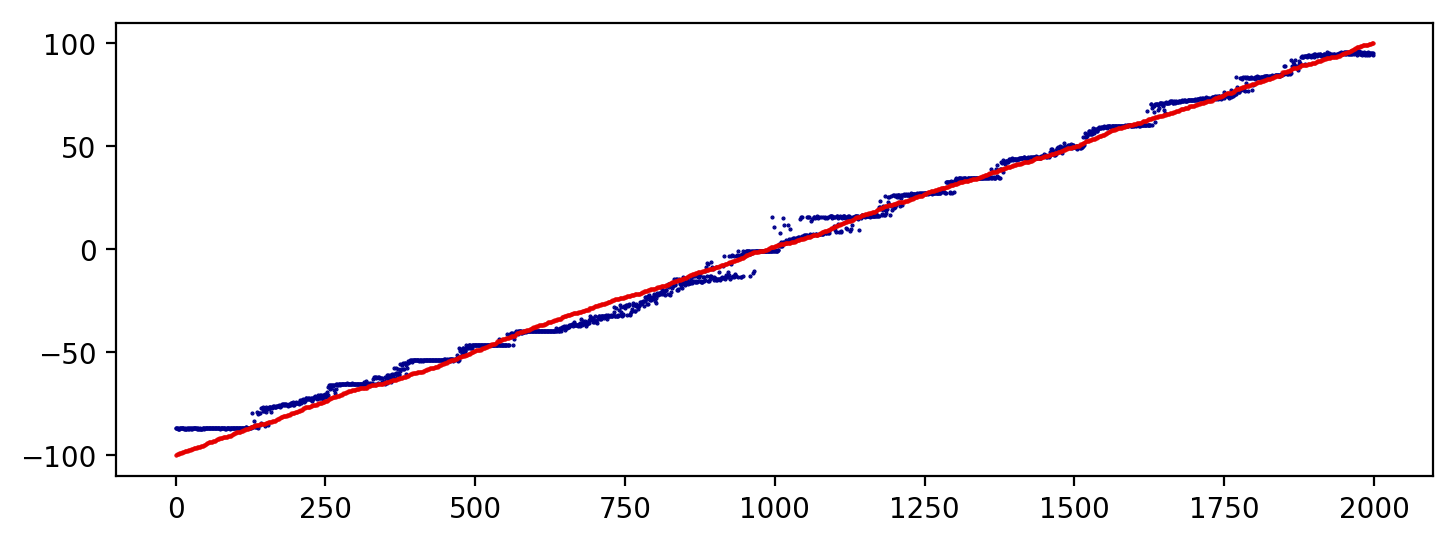

 epoch: 4400 testing_cost: 0.0011369096

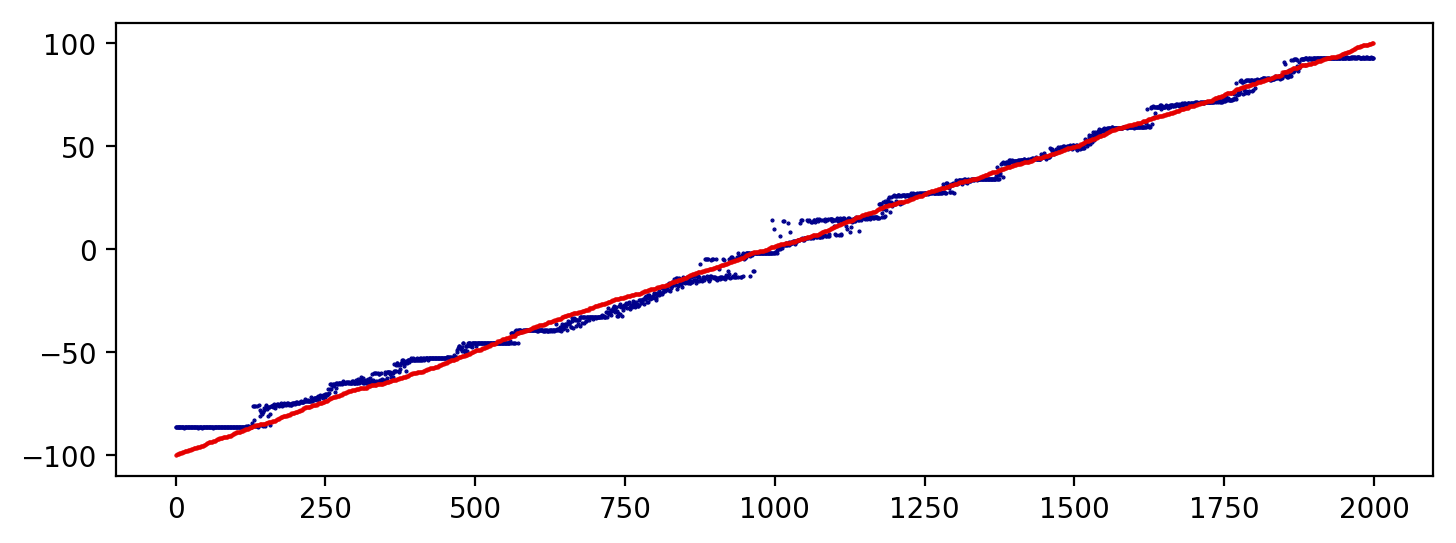

 epoch: 4450 testing_cost: 0.0013340813

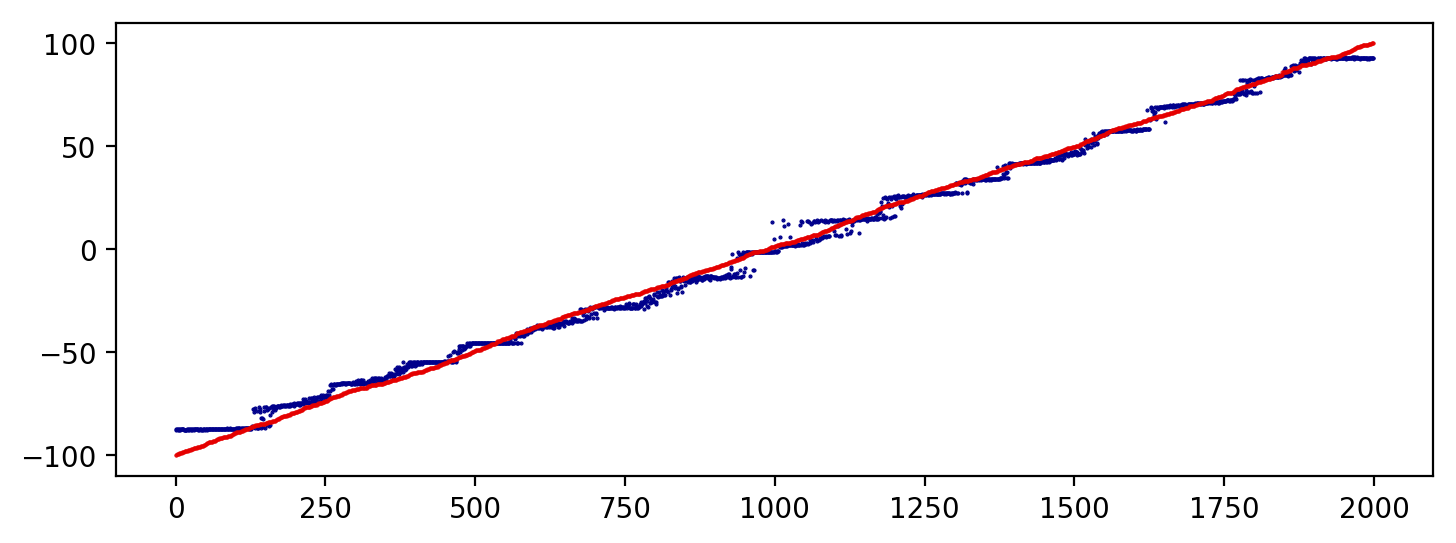

 epoch: 4499 testing_cost: 0.0014567481

In [17]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-2999')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 2*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [18]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.6753946518627426
2.1788421463527445


In [19]:
#import data
data_df = pd.read_csv('../../data/wrapped_10000_gaussian_spikes_five_percent_D.bz2', compression = 'bz2')

# split random 80% / 20%
training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

# scale data
X_scaled_training = X_scaler.transform(X_training)
Y_scaled_training = Y_scaler.transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

INFO:tensorflow:Restoring parameters from ../../logs/517631/trained_model.ckpt-4499
 epoch: 4500 testing_cost: 0.0016256840

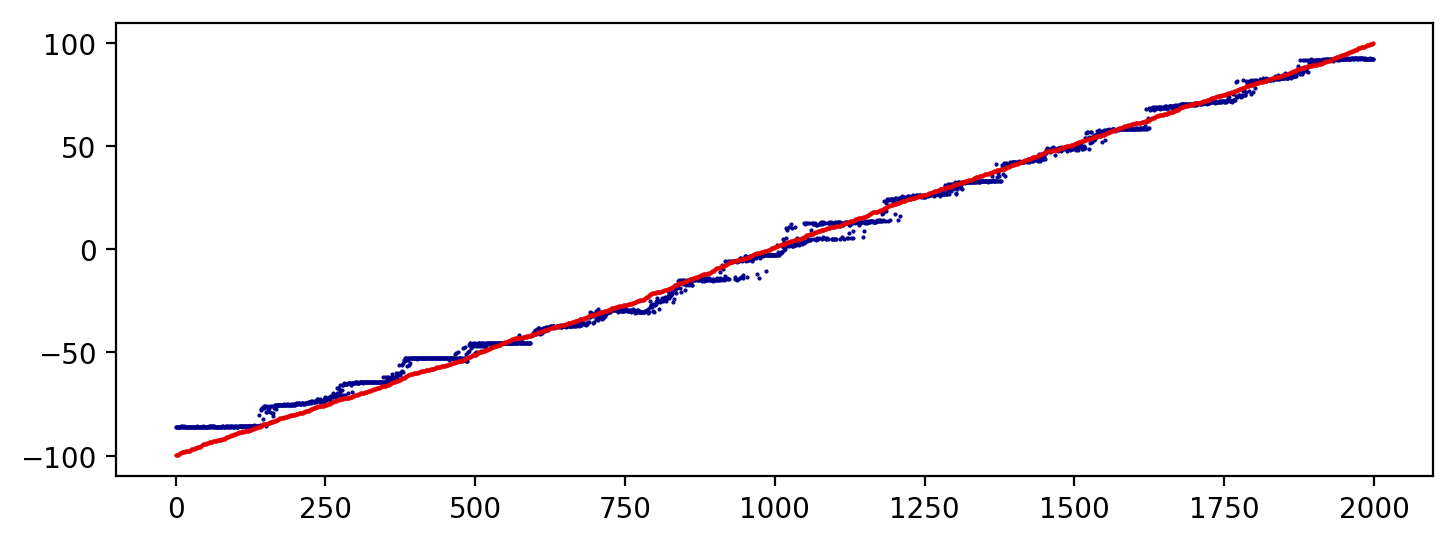

 epoch: 4550 testing_cost: 0.0041225716

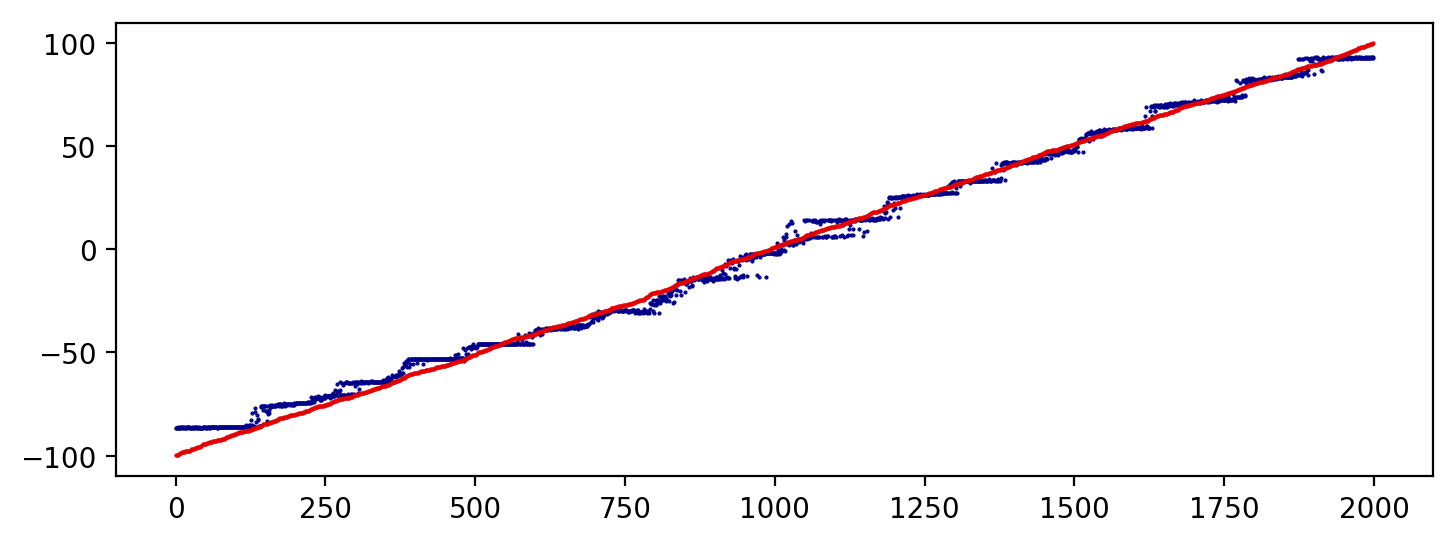

 epoch: 4600 testing_cost: 0.0016524275

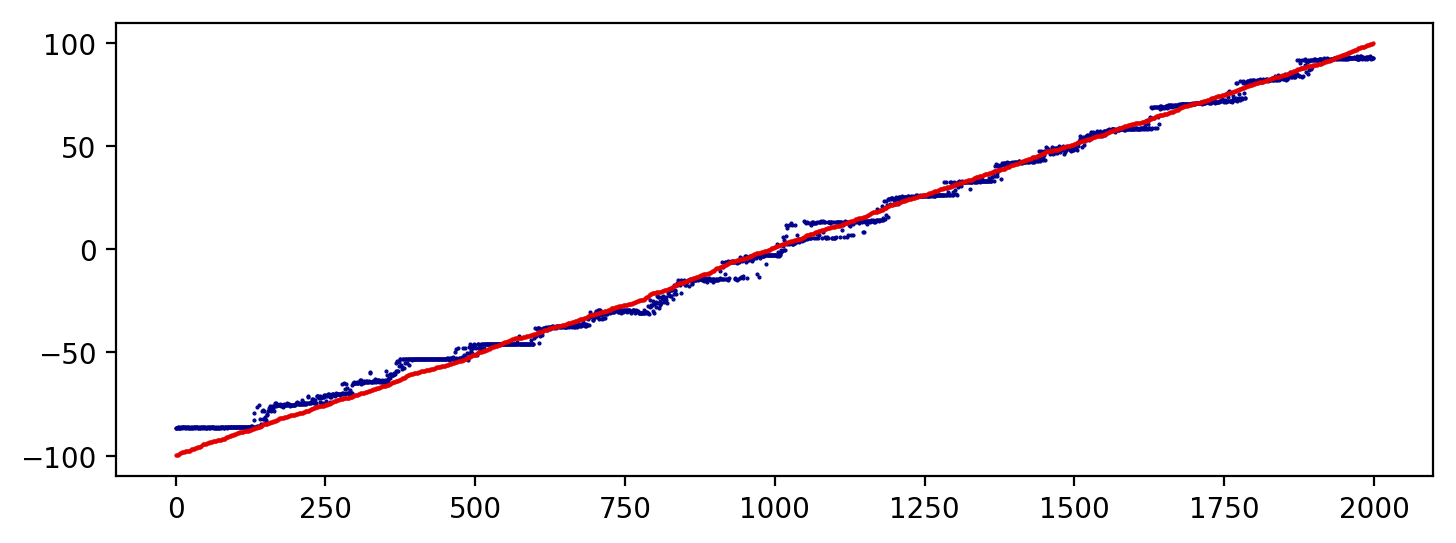

 epoch: 4650 testing_cost: 0.0013551963

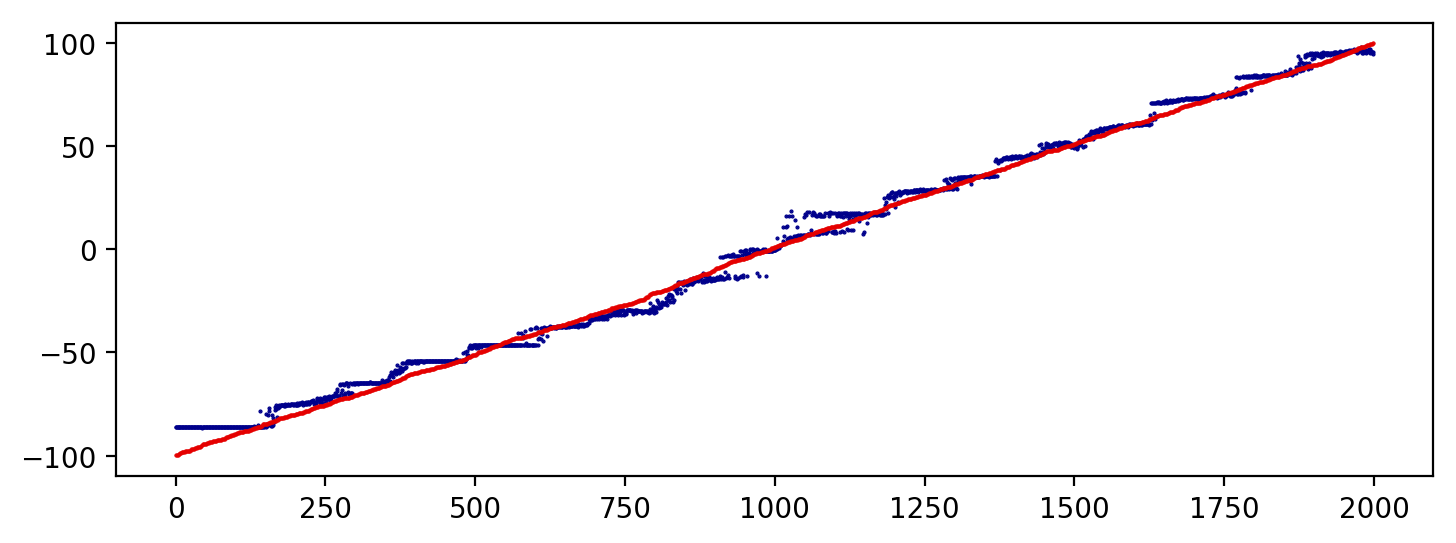

 epoch: 4700 testing_cost: 0.0013588828

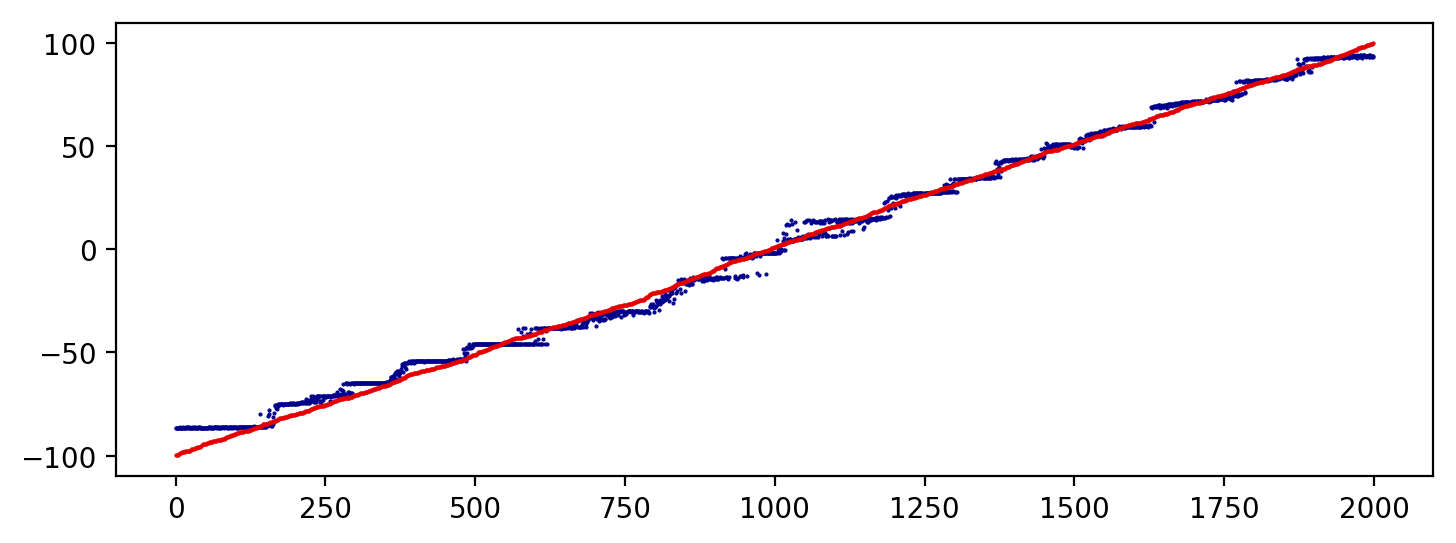

 epoch: 4750 testing_cost: 0.0010774133

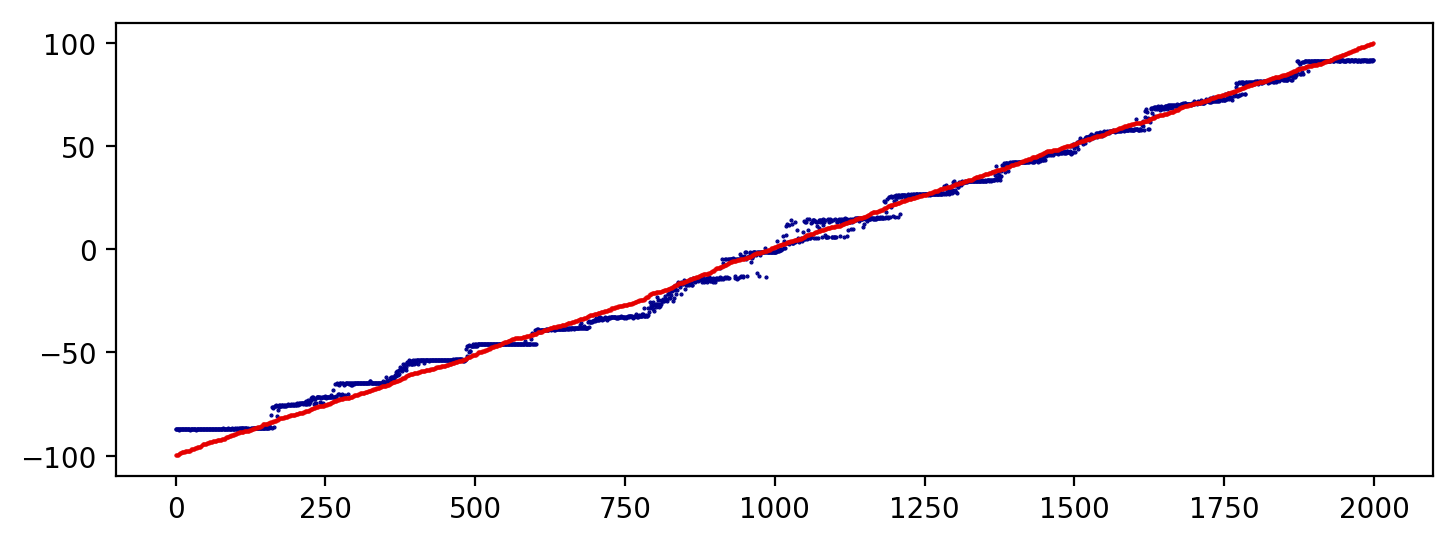

 epoch: 4800 testing_cost: 0.0016015540

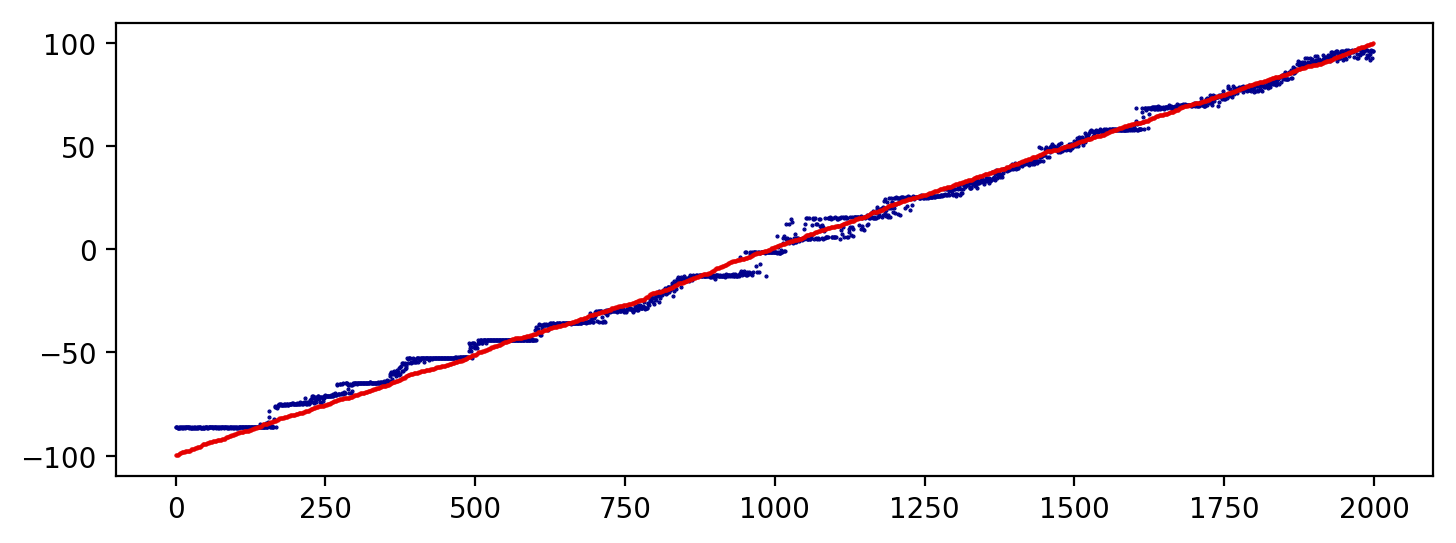

 epoch: 4850 testing_cost: 0.0012682803

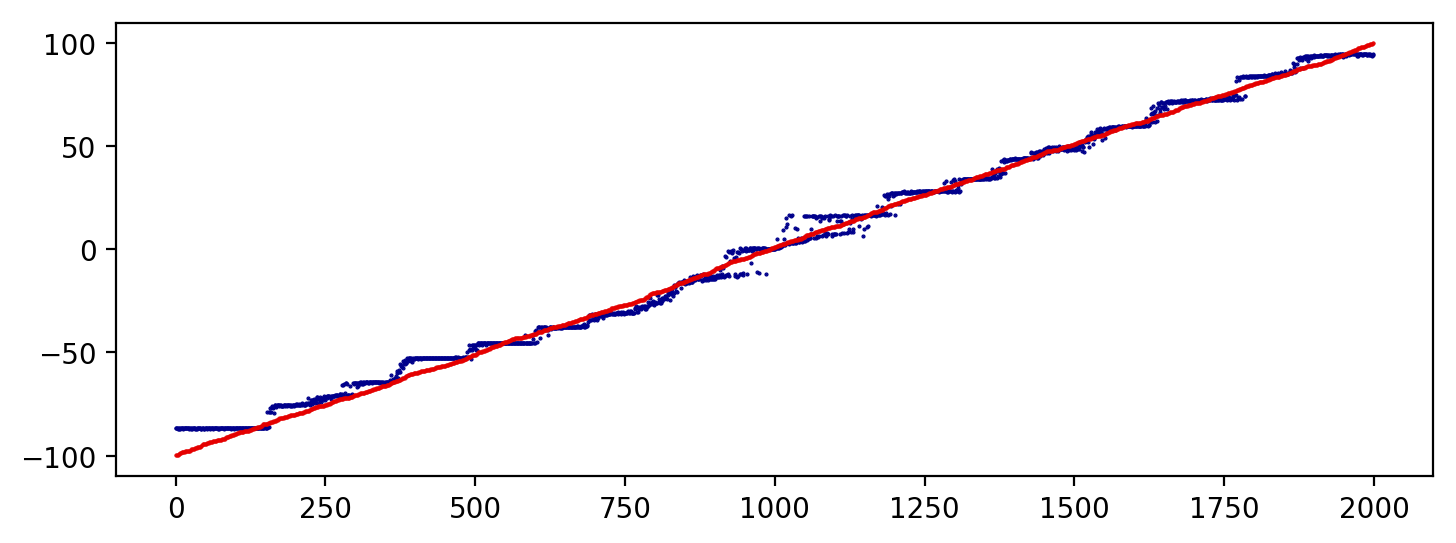

 epoch: 4900 testing_cost: 0.0011562257

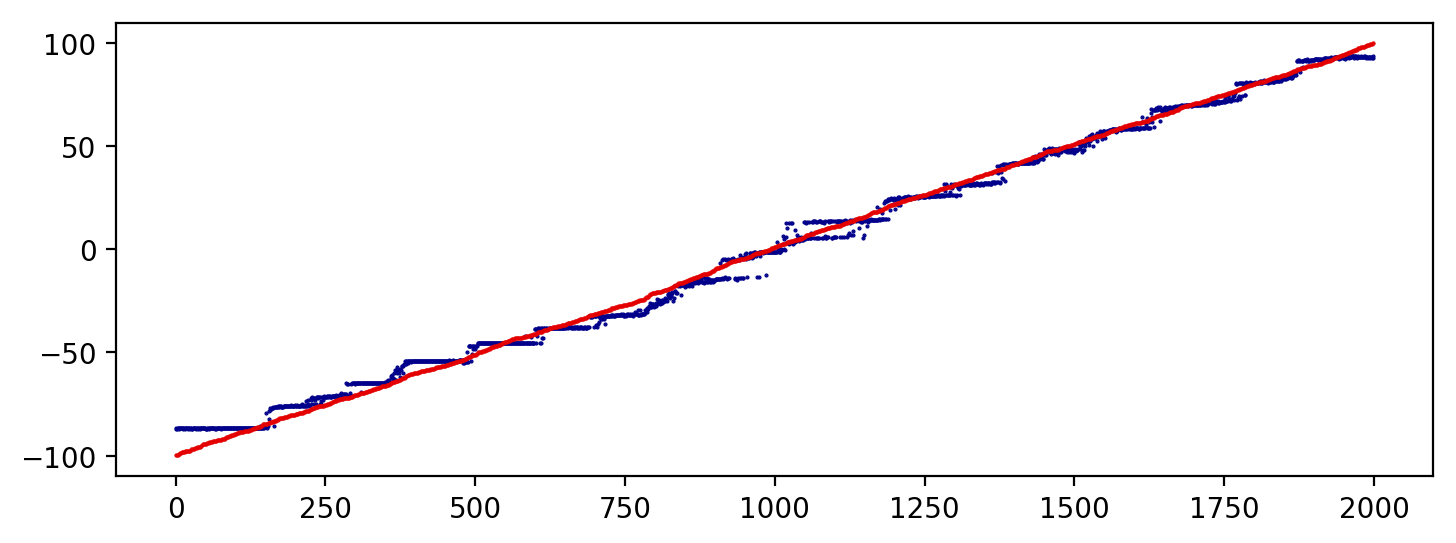

 epoch: 4950 testing_cost: 0.0013987260

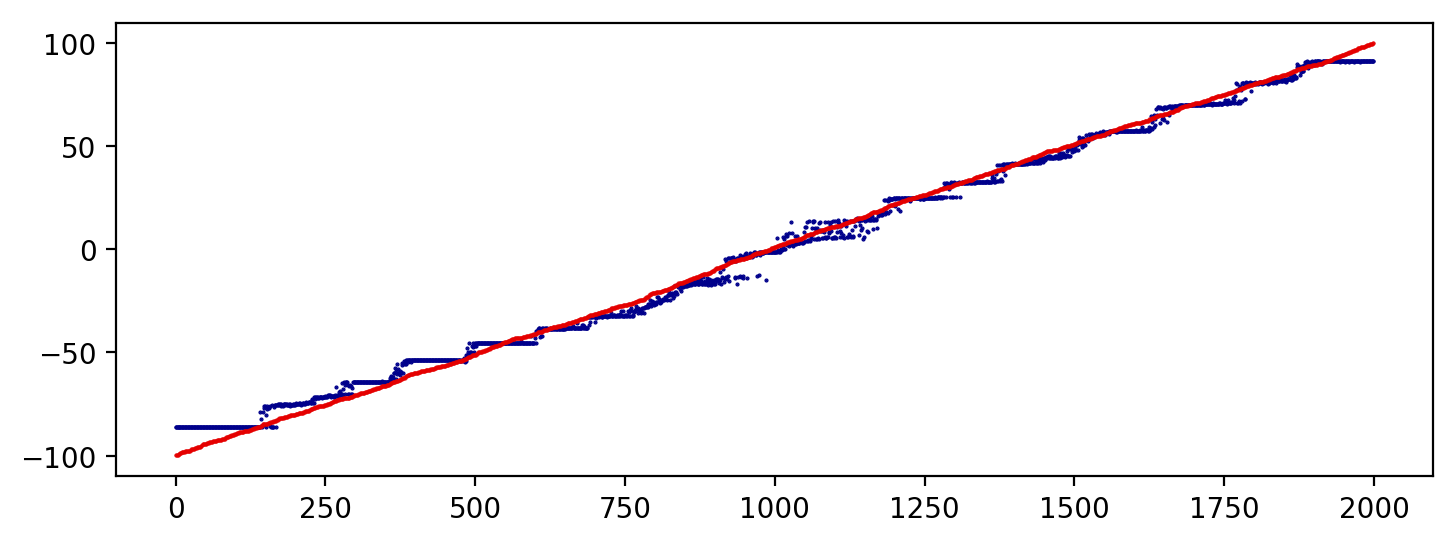

 epoch: 5000 testing_cost: 0.0012676191

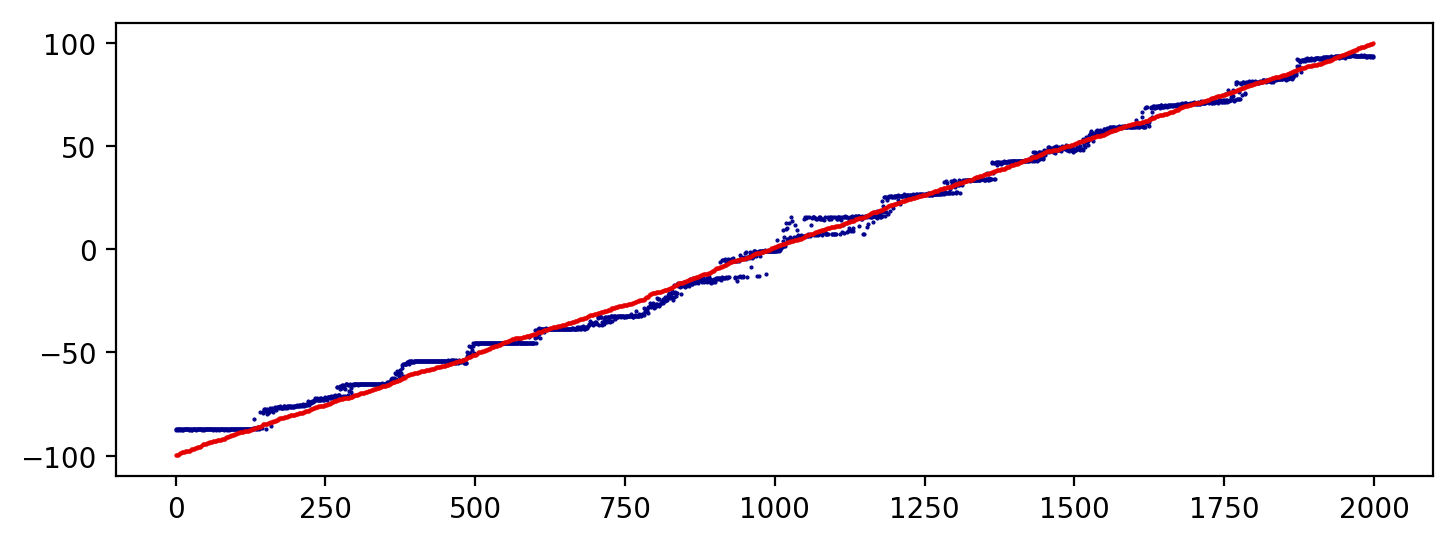

 epoch: 5050 testing_cost: 0.0015681067

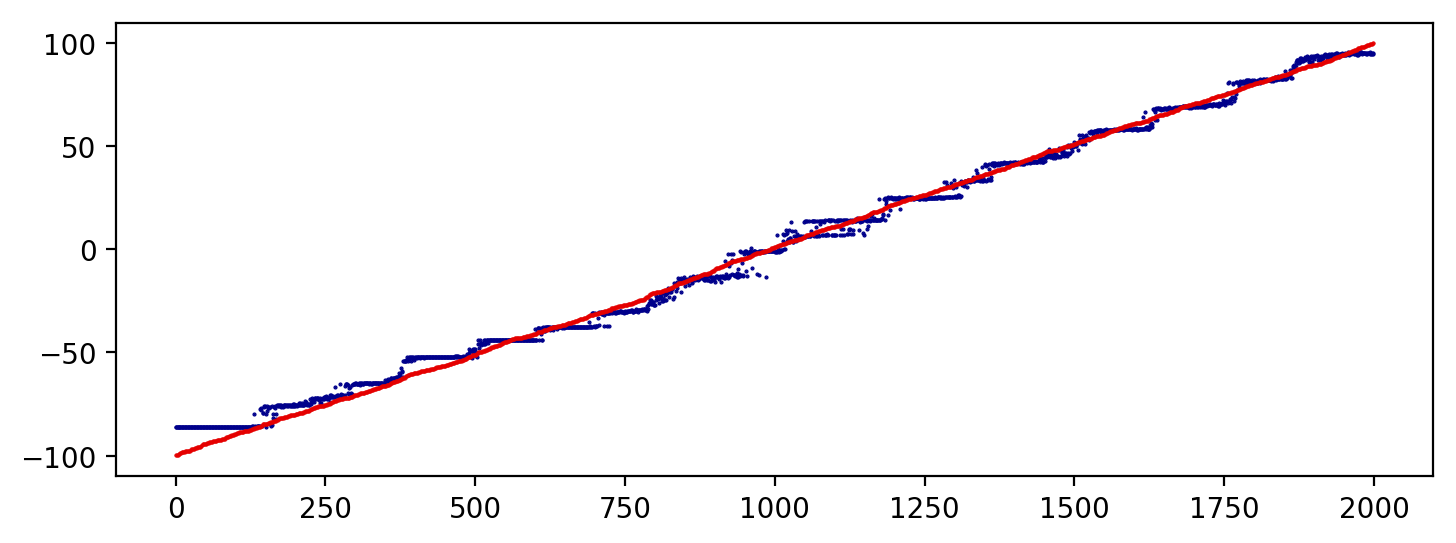

 epoch: 5100 testing_cost: 0.0013942311

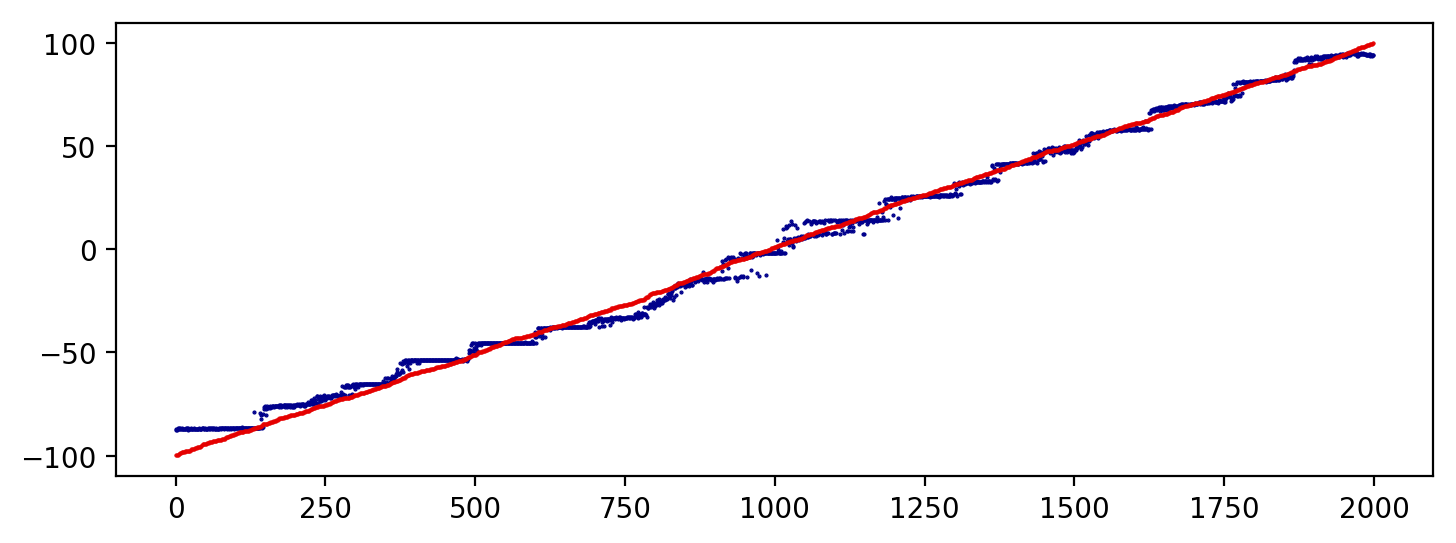

 epoch: 5150 testing_cost: 0.0016341829

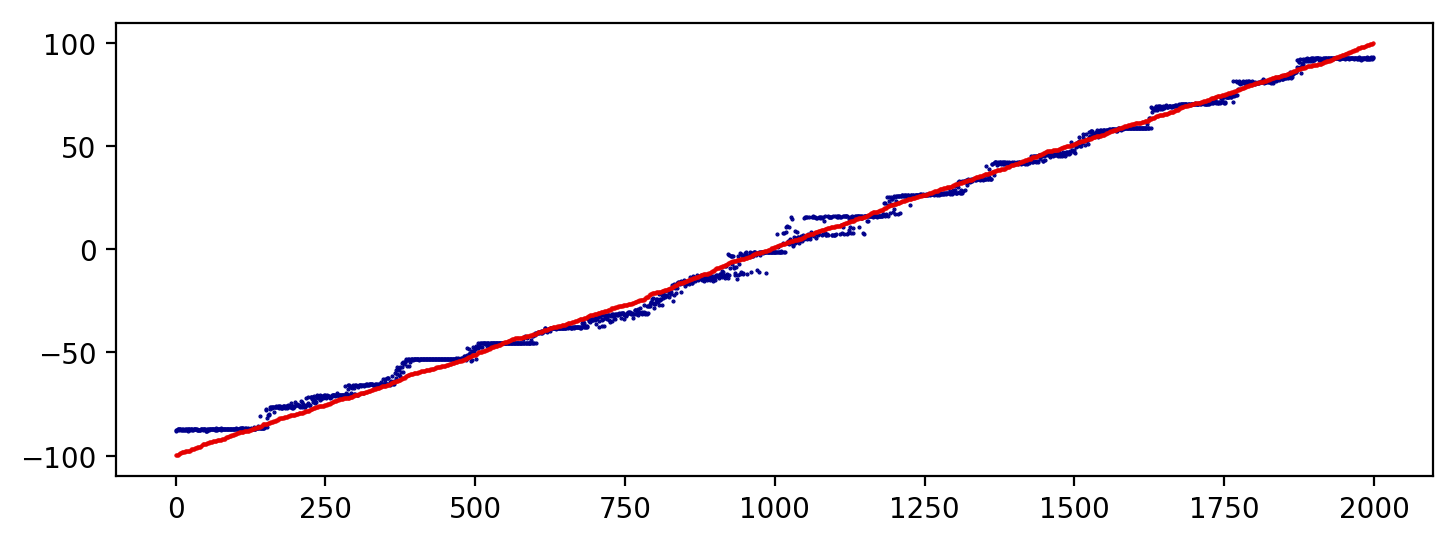

 epoch: 5200 testing_cost: 0.0016009321

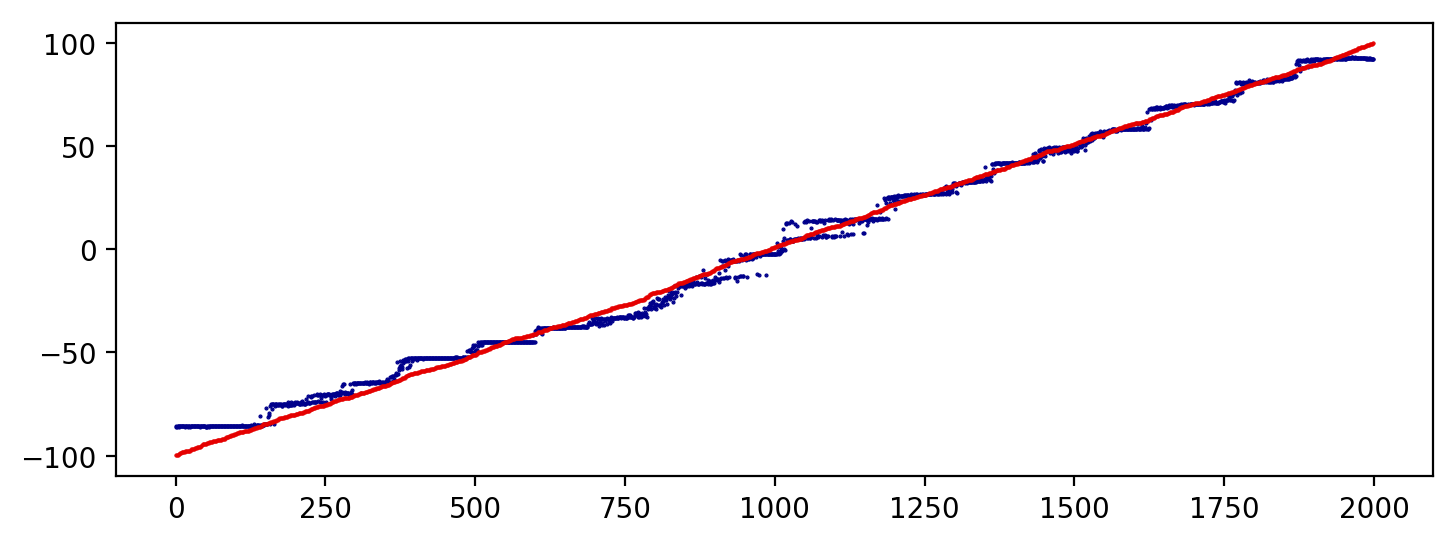

 epoch: 5250 testing_cost: 0.0013202362

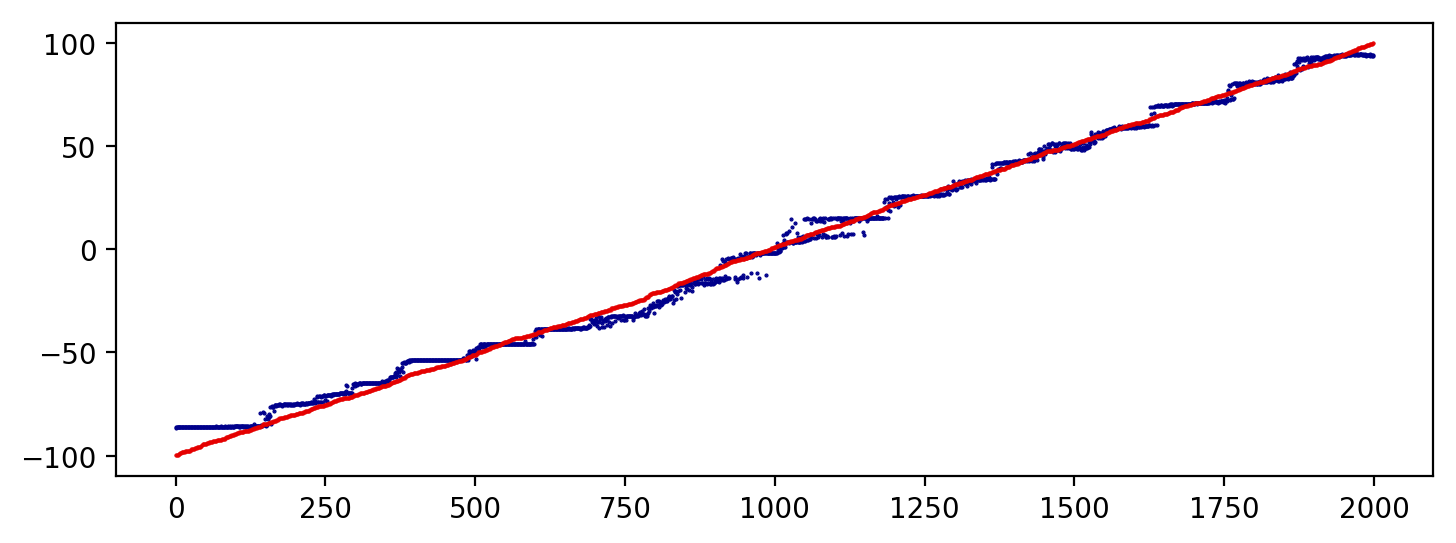

 epoch: 5300 testing_cost: 0.0009229119

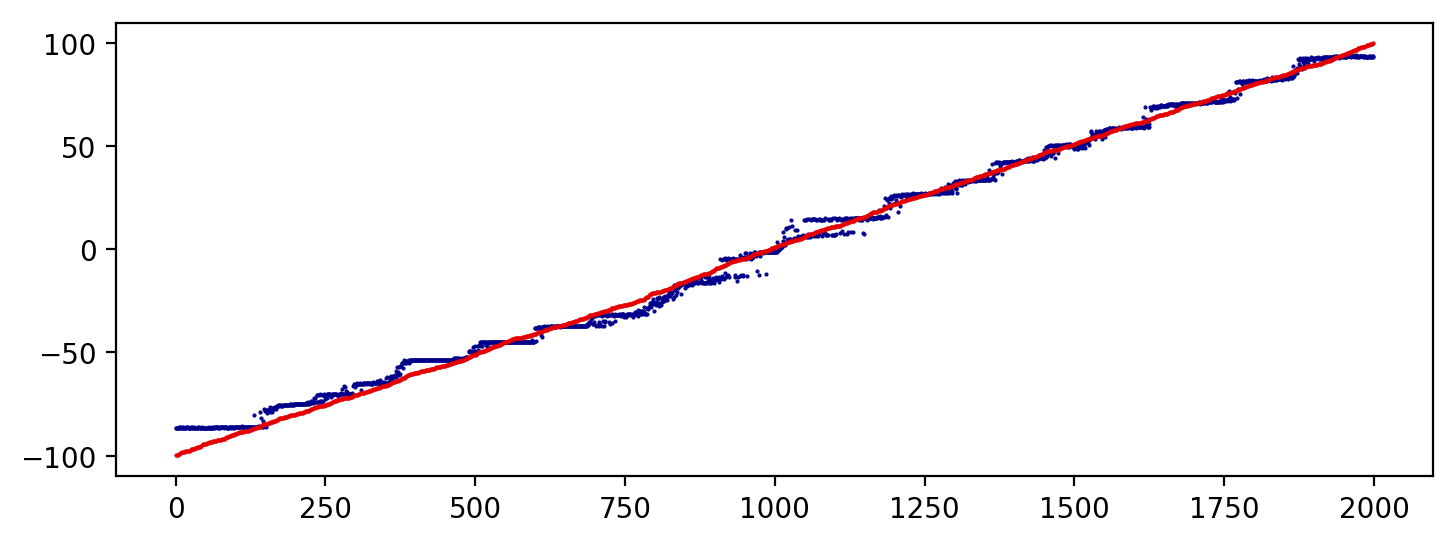

 epoch: 5350 testing_cost: 0.0009961678

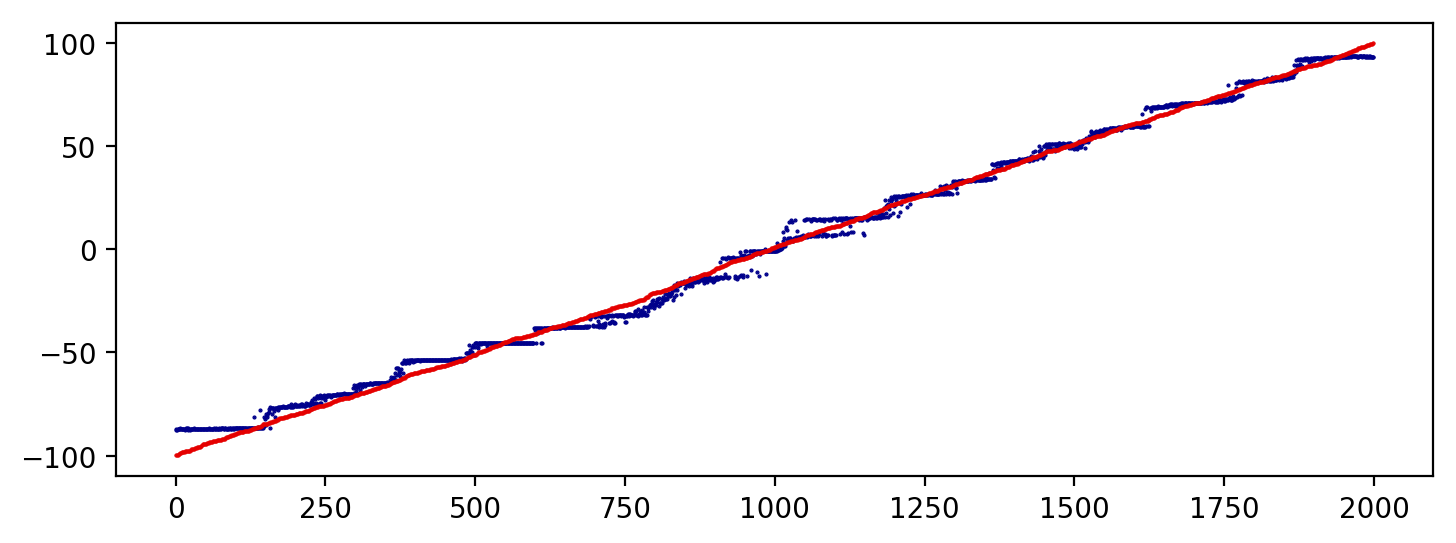

 epoch: 5400 testing_cost: 0.0012340281

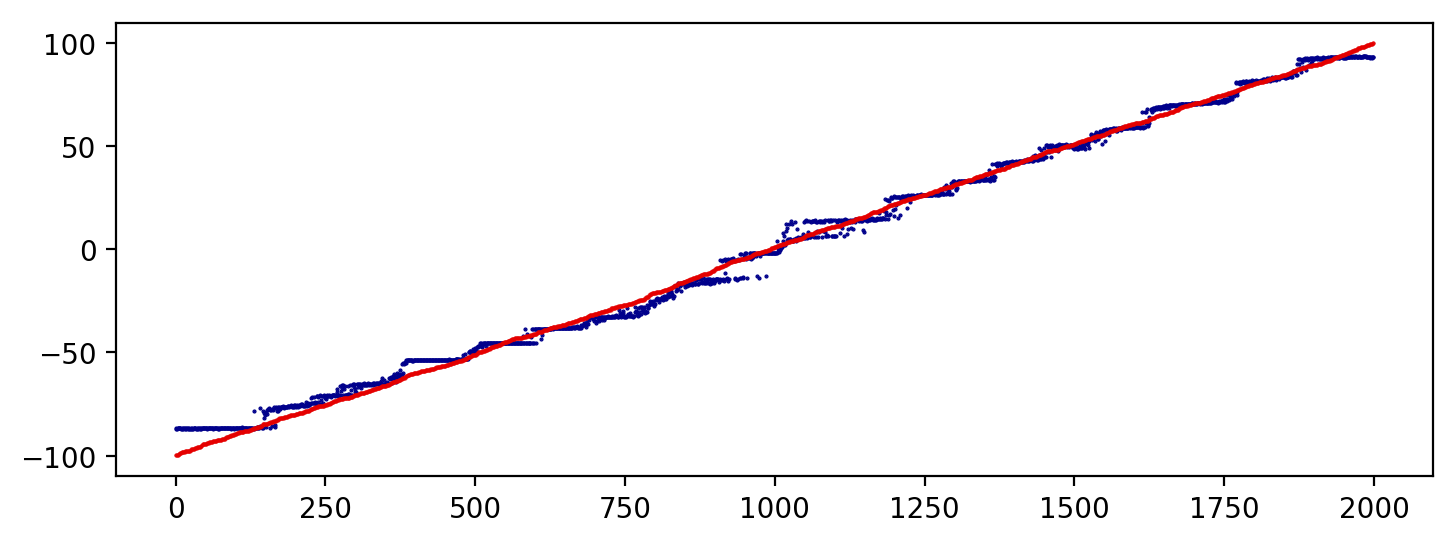

 epoch: 5450 testing_cost: 0.0013051450

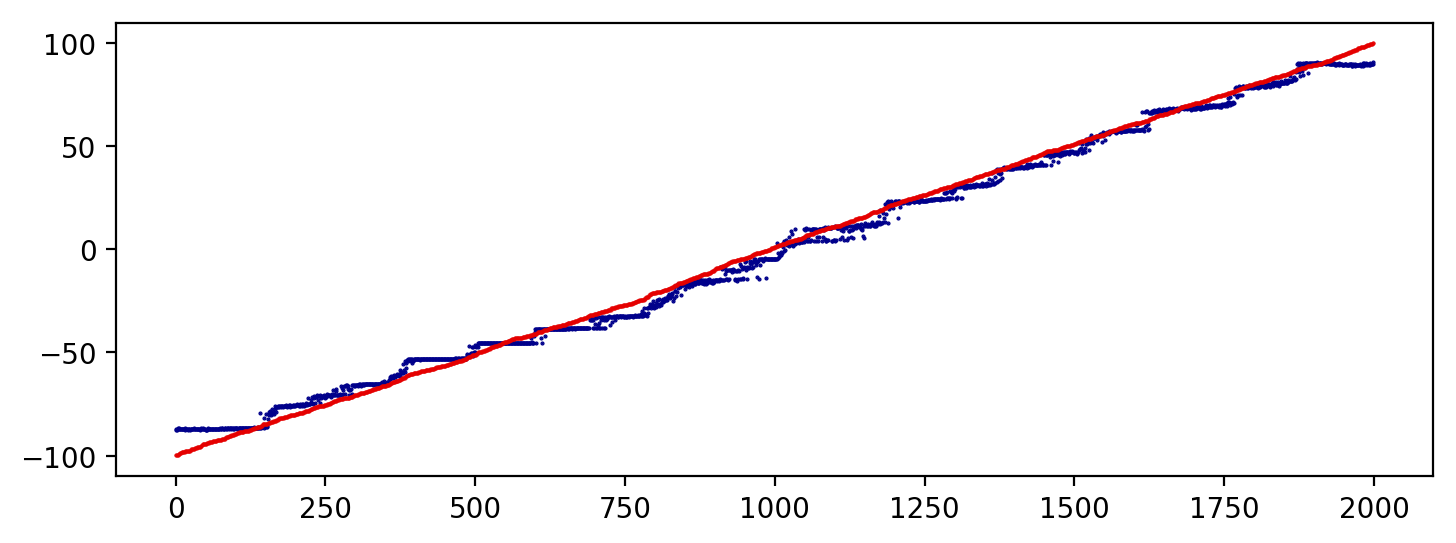

 epoch: 5500 testing_cost: 0.0017039091

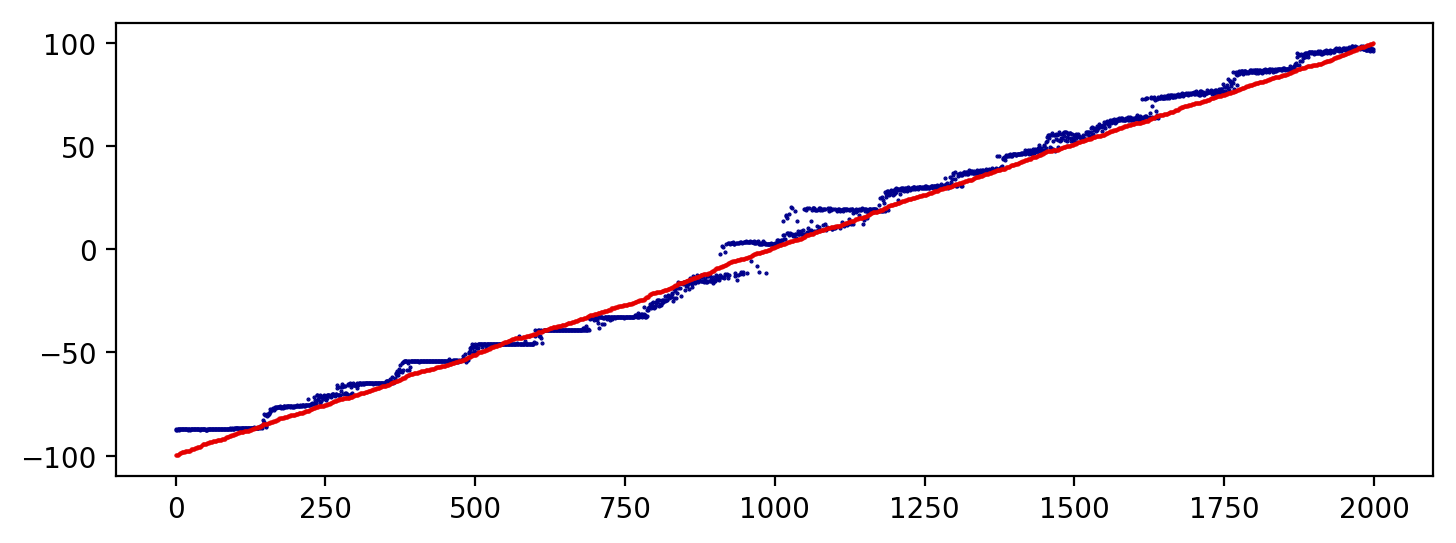

 epoch: 5550 testing_cost: 0.0011480321

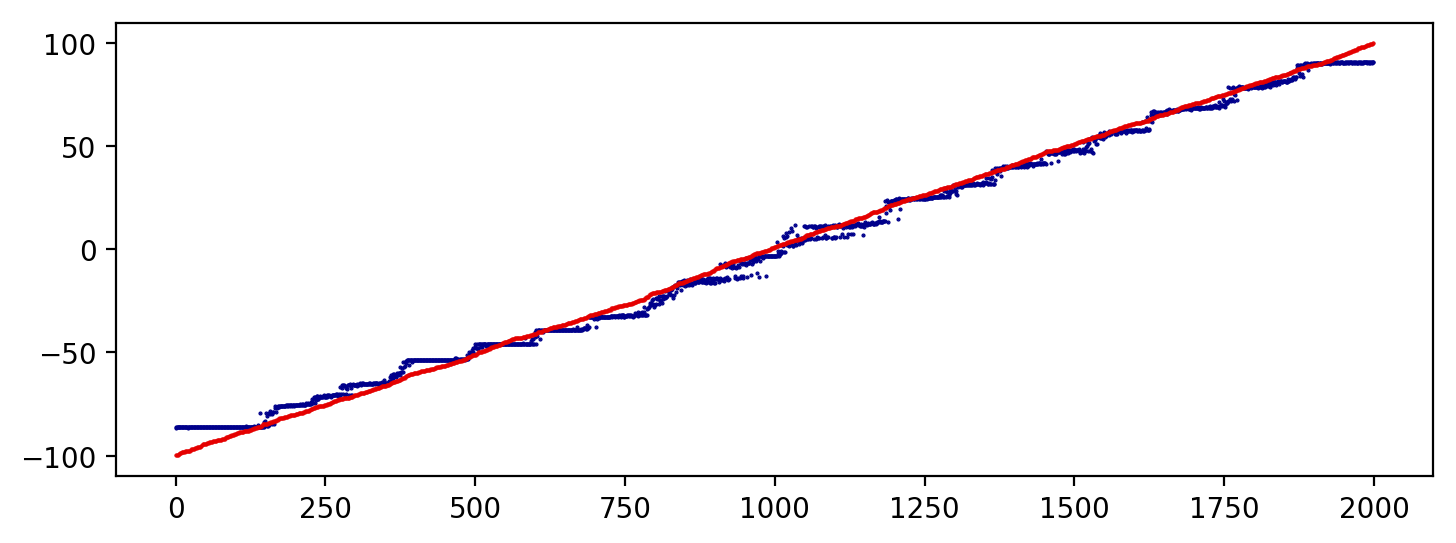

 epoch: 5600 testing_cost: 0.0019773771

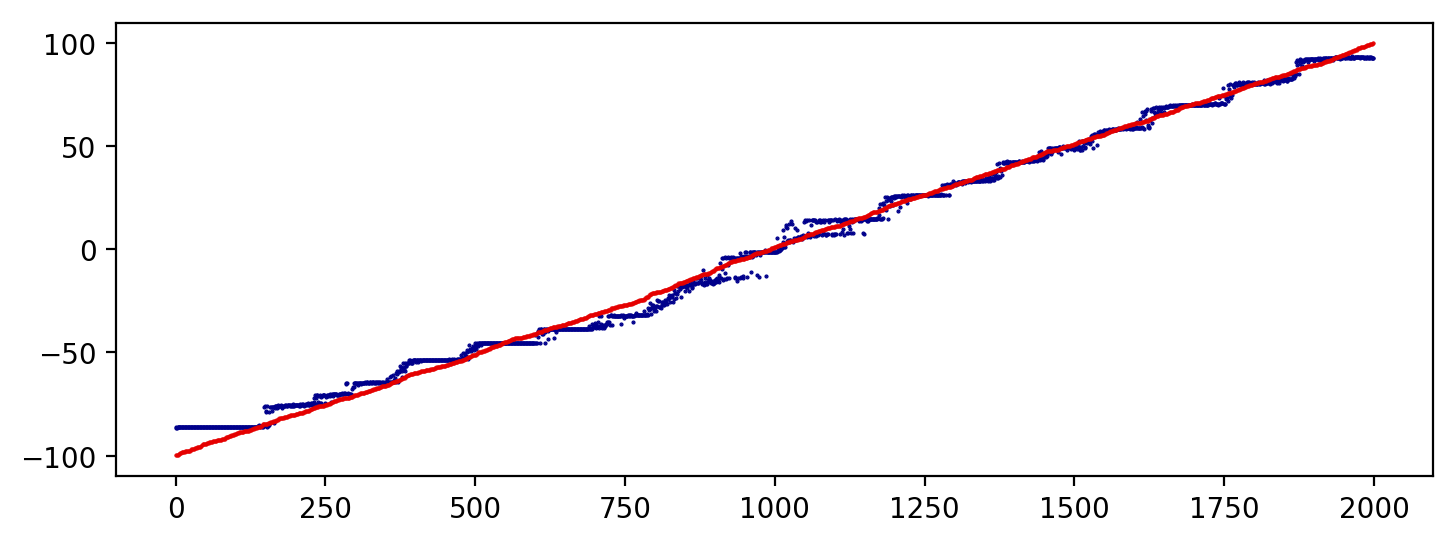

 epoch: 5650 testing_cost: 0.0013853045

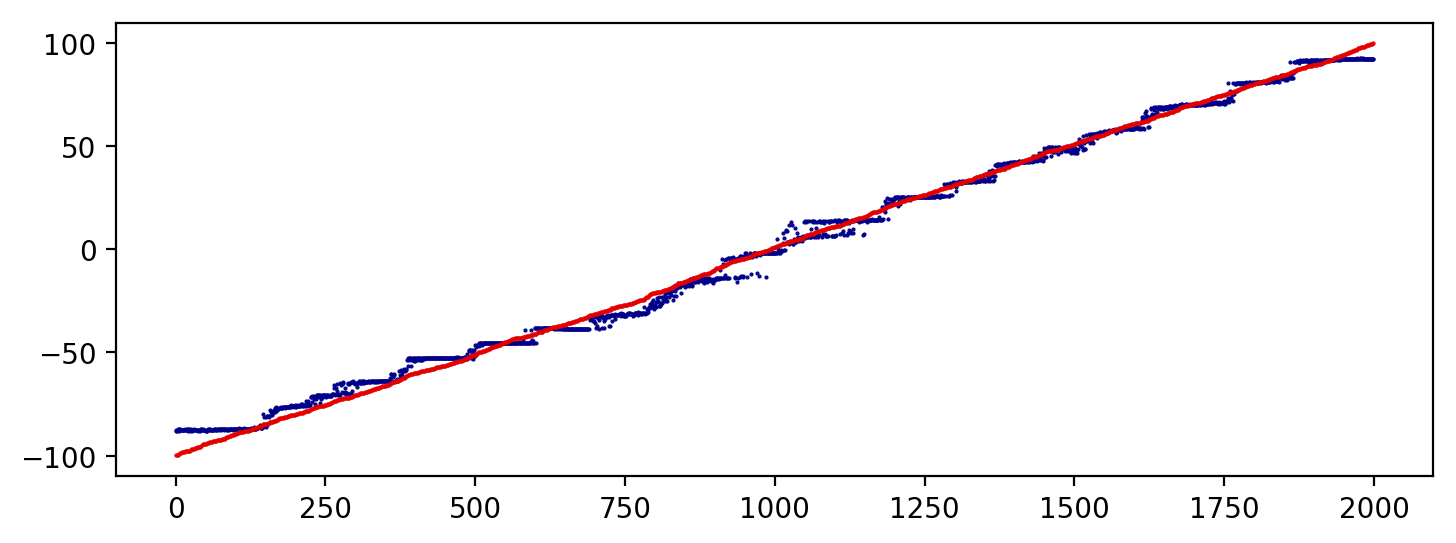

 epoch: 5700 testing_cost: 0.0014176286

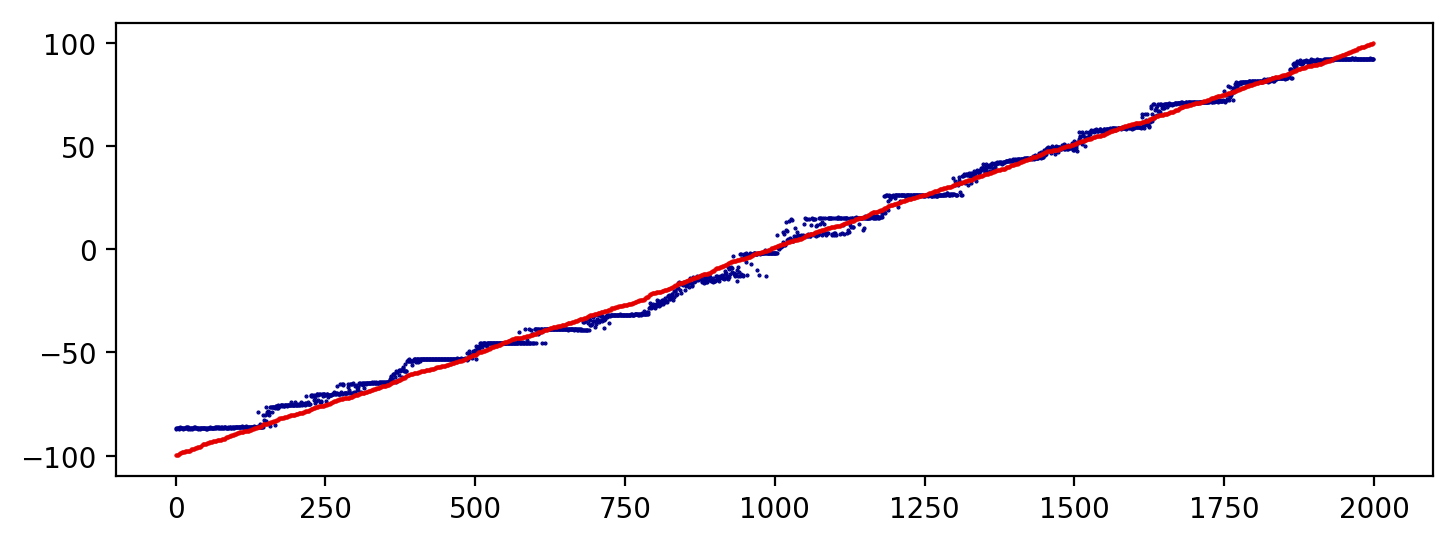

 epoch: 5750 testing_cost: 0.0011122933

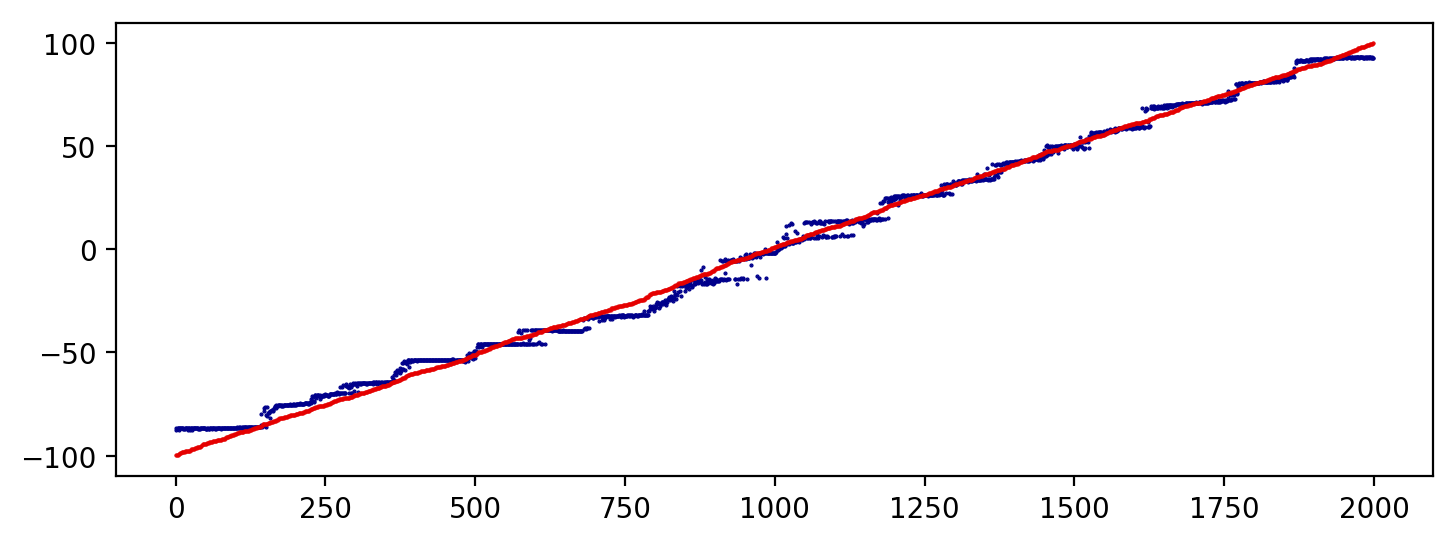

 epoch: 5800 testing_cost: 0.0011721766

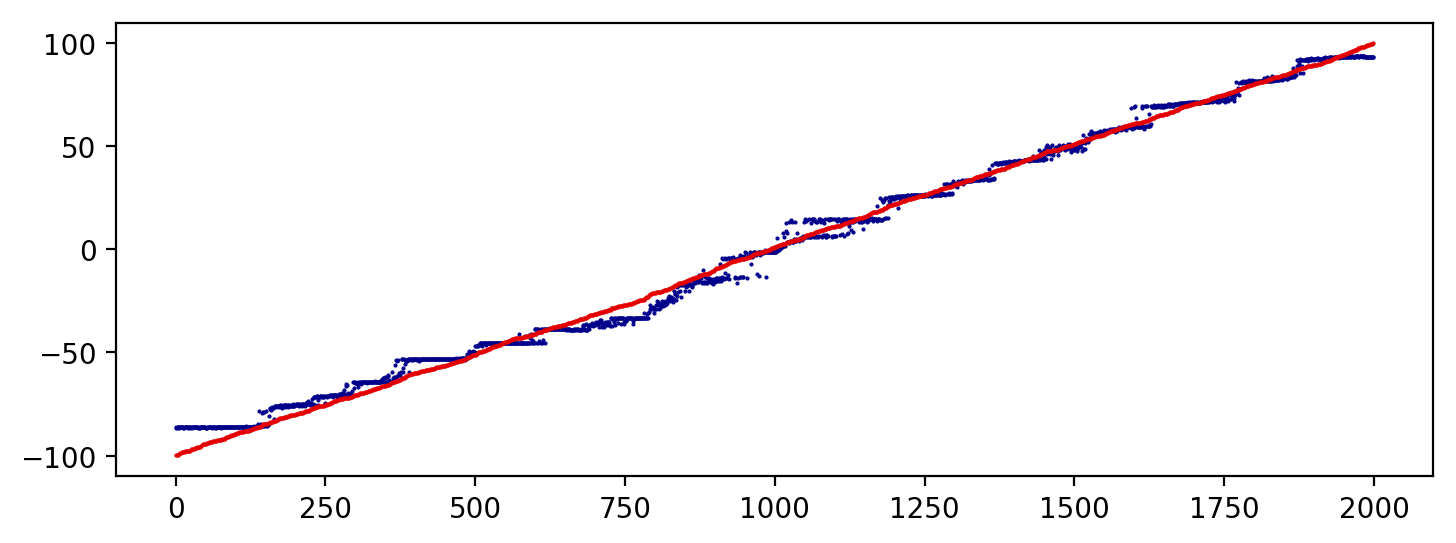

 epoch: 5850 testing_cost: 0.0010581987

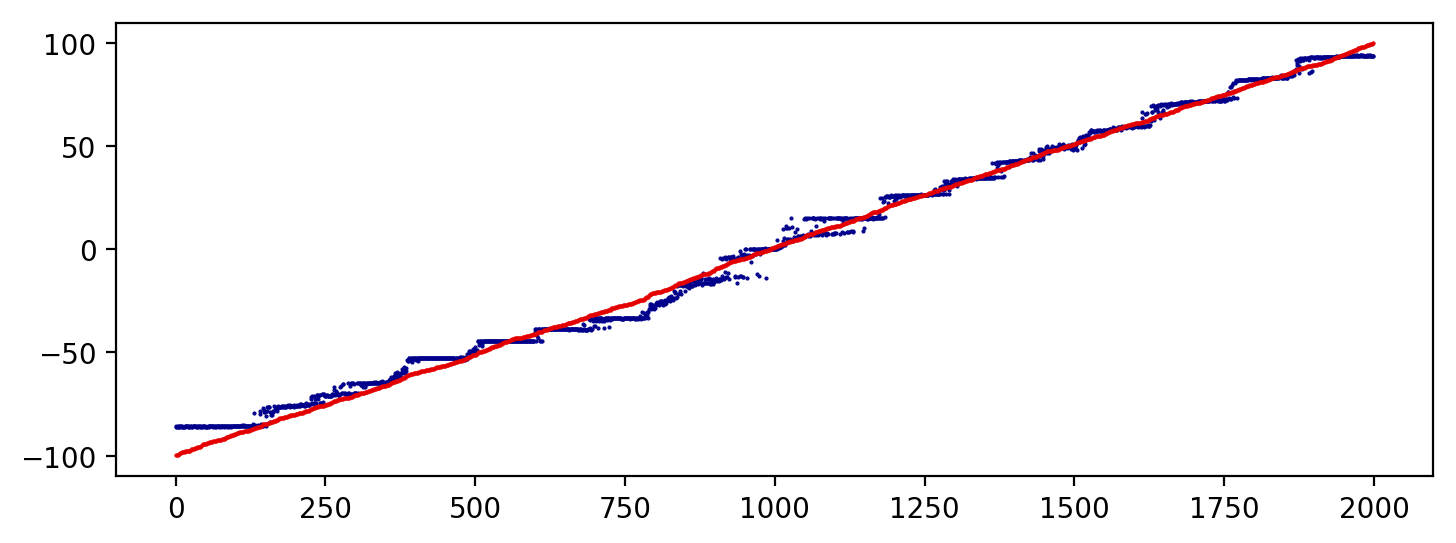

 epoch: 5900 testing_cost: 0.0011782150

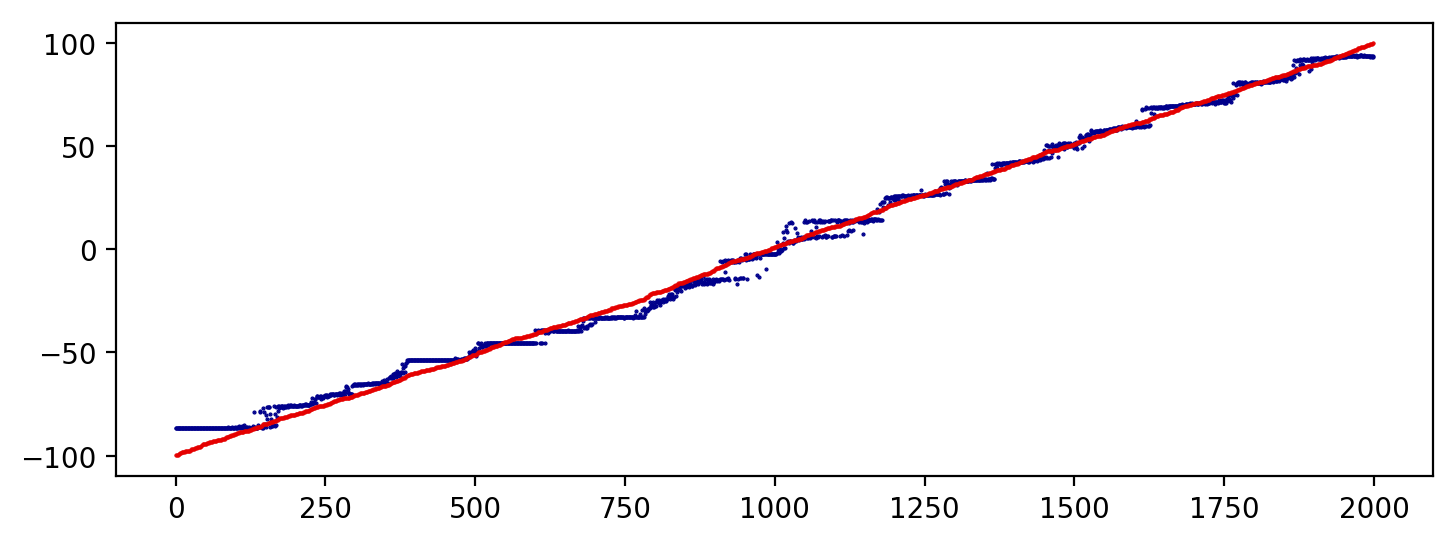

 epoch: 5950 testing_cost: 0.0013378997

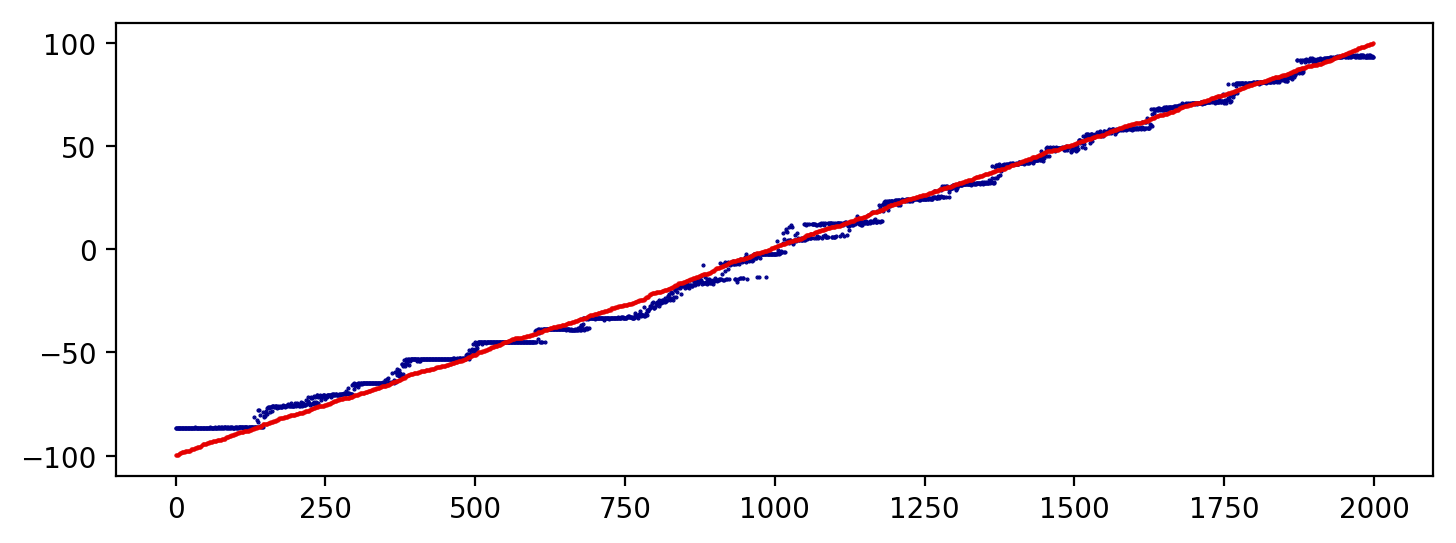

 epoch: 5999 testing_cost: 0.0015380268

In [20]:
with tf.Session() as session:

    saver.restore(session,model_save_location + '-4499')

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(training_epochs):
        epoch = epoch + 3*training_epochs


        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training, keep_prob : 0.50}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0 or epoch == training_epochs:
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob : 1.00})
            prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)
            sorting_idx = np.argsort(Y_testing.T[0])
        
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(Y_testing.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, color = '#E50000')
            plt.show()
            
    saver.save(session, model_save_location, epoch)

In [21]:
print(sum((Y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
print(np.std(abs(Y_testing.T[0] - prediction_unscaled.T[0])))

0.7162757614918478
2.3422929878872716
